In [1]:

import wandb
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import dill
import copy
import numpy as np
from scipy.stats import sem
from scipy.stats import sem
import os

plt.rcParams["axes.xmargin"] = 0

In [2]:
# !pip install scipy

In [3]:
def get_sweeps(project):
    sweeps = []
    for sweep in project:
        sweeps.append((sweep.name, sweep.id))
    return sweeps[::-1]


def get_run_links(sweeps, project_name):
    runs = []
    for sweep_name, sweep_link in sweeps:
        sweep = wandb.Api().sweep(f"lucacorbucci/{project_name}/{sweep_link}")
        run_list_sweep = []
        for run in sweep.runs:
            run_list_sweep.append(run.id)
        runs.append((sweep_name, run_list_sweep[::-1]))
    return runs


def get_run_data(run_links_per_sweep, project_name):
    run_data = []
    for sweep_name, sweep in run_links_per_sweep:
        print("Downloading data for a sweep")
        tmp_run_data = []
        for run_link in sweep:
            run = wandb.Api().run(f"lucacorbucci/{project_name}/{run_link}")

            tmp_run_data.append(pd.DataFrame(run.scan_history()))
        run_data.append((sweep_name, tmp_run_data))
    return run_data


def remove_nan(column_names, dataframe):
    column_names = [
        column_name for column_name in column_names if column_name in dataframe.columns
    ]

    current_df = dataframe[column_names]
    # consider each column in training_data_disparity independently and
    # remove the rows where we have NaN
    new_columns = []

    for column in current_df.columns:
        new_values = list(current_df[column].dropna())
        new_columns.append(new_values)
    
    # if the lists have different lengths, we need to modify them so that
    # we have the same length:
    min_size = min([len(item) for item in new_columns])
    new_columns = [item[:min_size] for item in new_columns]

    # create the new dataframe with baseline_test_nodes_columns_disparity_dataset as columns
    # names and new_columns as values
    new_df = pd.DataFrame(dict(zip(column_names, new_columns)))
    return new_df


def create_avg_dataset(new_list):
    # print(new_list)
    # compute the mean and the std of the data in new_list
    # and create a new dataset with these values
    mean = []
    std = []
    dots_lenght = len(new_list[0])
    for dots in range(dots_lenght):
        current_values = []
        for item in new_list:
            if item[dots] > 0:
                current_values.append(item[dots])
        current_mean = np.mean(current_values)           
        mean.append(current_mean)
        current_std = sem(current_values) #np.std(current_values, axis=0)
        std.append(current_std)
    # std = sem(new_list)  # np.std(new_list, axis=0)

    df = pd.DataFrame()
    dots_list = []
    increasing_mean = []
    current_max = 0
    new_std = []
    previous_std = -1
    previous_mean = -1
    for value_mean, value_std  in zip(mean, std):
        if value_mean > current_max:
            current_max = value_mean
            dots_list.append(current_max)
        else:
            dots_list.append(None)
        
        if value_mean >= previous_mean:
            new_std.append(value_std)
            increasing_mean.append(value_mean)
            previous_mean = value_mean
            previous_std = value_std
        else:
            new_std.append(previous_std)
            increasing_mean.append(previous_mean)
        
    df["mean"] = increasing_mean #mean
    df["dots"] = dots_list
    df["std"] = new_std # std
    df["index"] = list(range(0, len(mean)))
    return df


def prepare_pareto_frontier(data_lists, expected_num_experiments):
    custom_metrics = []

    for data_list in data_lists:
        tmp_custom_metrics = []
        current_max = 0
        for value in data_list:
            if value >= current_max:
                current_max = value
            tmp_custom_metrics.append(current_max)
        
        if len(tmp_custom_metrics) > 0:
            while len(tmp_custom_metrics) < expected_num_experiments:
                tmp_custom_metrics.append(tmp_custom_metrics[-1])
        custom_metrics.append(copy.deepcopy(tmp_custom_metrics))

    return custom_metrics


def extract_last_custom_metrics(sweep, expected_len):
    custom_metrics = []
    for sweep_dfs in sweep:
        tmp_custom_metrics = []
        for df in sweep_dfs:
            custom_metric = remove_nan(["Custom_metric"], df)
            last_value = custom_metric.values.tolist()[-1][0]
            if last_value == "-Infinity":
                last_value = 0
            if len(custom_metric) != expected_len:
                last_value = 0
            tmp_custom_metrics.append(last_value)
        custom_metrics.append(tmp_custom_metrics)
    return custom_metrics


# Functions to plot
def plot_pareto_frontier(mean_df_tunable, mean_df_fixed, name, target, epsilon):
    plt.figure(figsize=(15, 10))

    # Plot mean as a line
    plt.plot(
        mean_df_tunable["index"],
        mean_df_tunable["mean"],
        label="Tunable Lambda",
        color="blue",
    )
    plt.plot(
        mean_df_fixed["index"],
        mean_df_fixed["mean"],
        label="Fixed Lambda",
        color="green",
    )

    # Plot dots for non-None values in "dots" column
    dots_mask = mean_df_tunable["dots"].notnull()
    plt.scatter(
        mean_df_tunable["index"][dots_mask],
        mean_df_tunable["dots"][dots_mask],
        color="blue",
        marker="o",
    )

    dots_mask = mean_df_fixed["dots"].notnull()
    plt.scatter(
        mean_df_fixed["index"][dots_mask],
        mean_df_fixed["dots"][dots_mask],
        color="green",
        marker="o",
    )

    # Plot std as shaded area
    plt.fill_between(
        mean_df_tunable["index"],
        mean_df_tunable["mean"] - mean_df_tunable["std"],
        mean_df_tunable["mean"] + mean_df_tunable["std"],
        alpha=0.2,
        color="blue",
    )

    plt.fill_between(
        mean_df_fixed["index"],
        mean_df_fixed["mean"] - mean_df_fixed["std"],
        mean_df_fixed["mean"] + mean_df_fixed["std"],
        alpha=0.2,
        color="green",
    )

    # Customize the plot
    plt.title(f"Fixed vs Tunable - Target {target} - Eps {epsilon}")
    plt.xlabel("Experiments")
    plt.ylabel("Maximixed Metric")
    plt.rcParams.update({"font.size": 30})
    plt.ylim(0, 1)
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.tight_layout()

    plt.savefig(f"./plots_paper/Celeba/{name}.png")
    plt.show()


# def plot(project_name):
#     project = wandb.Api().project(project_name).sweeps()
#     sweeps = get_sweeps(project)
#     run_links = get_run_links(sweeps, project_name)
#     data = get_run_data(
#         run_links,
#         project_name,
#     )
#     tunable = [df for name, df in data if name == "celeba_tunable_private"]
#     fixed = [df for name, df in data if name == "celeba_fixed_private"]
#     custom_metrics_tunable = extract_last_custom_metrics(tunable)
#     custom_metrics_fixed = extract_last_custom_metrics(fixed)
#     pareto_list_tunable = prepare_pareto_frontier(custom_metrics_tunable)
#     pareto_list_fixed = prepare_pareto_frontier(custom_metrics_fixed)
#     df_pareto_tunable = create_avg_dataset(pareto_list_tunable)
#     df_pareto_fixed = create_avg_dataset(pareto_list_fixed)
#     plot_pareto_frontier(df_pareto_tunable, df_pareto_fixed, project_name)


def prepare_mean_and_std(
    tunable_experiments,
    fixed_experiments,
    baseline_experiments,
    accuracy_experiments_type="Train",
    disparity_experiments_type="Training",
):
    tunable_train_accuracy = []
    tunable_train_disparity = []
    for experiment in tunable_experiments:
        experiment = remove_nan(
            [
                accuracy_experiments_type,
                disparity_experiments_type,
            ],
            experiment,
        )
        tunable_train_accuracy.append(list(experiment[accuracy_experiments_type])[0:40])
        tunable_train_disparity.append(
            list(experiment[disparity_experiments_type])[0:40]
        )

    fixed_train_accuracy = []
    fixed_train_disparity = []
    for experiment in fixed_experiments:
        experiment = remove_nan(
            [
                accuracy_experiments_type,
                disparity_experiments_type,
            ],
            experiment,
        )
        fixed_train_accuracy.append(list(experiment[accuracy_experiments_type])[0:40])
        fixed_train_disparity.append(list(experiment[disparity_experiments_type])[0:40])

    fixed_mean_train_accuracy = np.mean(fixed_train_accuracy, axis=0)
    fixed_mean_train_disparity = np.mean(fixed_train_disparity, axis=0)
    if len(fixed_train_accuracy) > 1:
        fixed_std_train_accuracy = sem(
            fixed_train_accuracy
        )  # np.std(fixed_train_accuracy, axis=0)
        fixed_std_train_disparity = sem(
            fixed_train_disparity
        )  # np.std(fixed_train_disparity, axis=0)
    else:
        fixed_std_train_accuracy = fixed_train_accuracy
        fixed_std_train_disparity = fixed_train_disparity

    # for item in tunable_train_accuracy:
    #     print(len(item))
    tunable_mean_train_accuracy = np.mean(tunable_train_accuracy, axis=0)
    tunable_mean_train_disparity = np.mean(tunable_train_disparity, axis=0)
    if len(tunable_train_accuracy) > 1:
        tunable_std_train_accuracy = sem(
            tunable_train_accuracy
        )  # np.std(tunable_train_accuracy, axis=0)
        tunable_std_train_disparity = sem(
            tunable_train_disparity
        )  # np.std(tunable_train_disparity, axis=0)
    else:
        tunable_std_train_accuracy = tunable_train_accuracy
        tunable_std_train_disparity = tunable_train_disparity

    baseline_train_accuracy = []
    baseline_train_disparity = []
    for experiment in baseline_experiments:
        experiment = remove_nan(
            [
                accuracy_experiments_type,
                disparity_experiments_type,
            ],
            experiment,
        )
        baseline_train_accuracy.append(
            list(experiment[accuracy_experiments_type])[0:40]
        )
        baseline_train_disparity.append(
            list(experiment[disparity_experiments_type])[0:40]
        )

    baseline_mean_train_accuracy = np.array([0] * len(tunable_std_train_accuracy))
    baseline_mean_train_disparity = np.array([0] * len(tunable_std_train_accuracy))
    baseline_std_train_accuracy = np.array([0] * len(tunable_std_train_accuracy))
    baseline_std_train_disparity = np.array([0] * len(tunable_std_train_accuracy))
    if len(baseline_experiments) > 0:
        baseline_mean_train_accuracy = np.mean(baseline_train_accuracy, axis=0)
        baseline_mean_train_disparity = np.mean(baseline_train_disparity, axis=0)

        if len(baseline_train_disparity) > 1:
            baseline_std_train_disparity = sem(
                baseline_train_disparity
            )  # np.std(baseline_train_disparity, axis=0)
        else:
            baseline_std_train_disparity = baseline_mean_train_disparity
        if len(baseline_train_accuracy) > 1:
            baseline_std_train_accuracy = sem(
                baseline_train_accuracy
            )  # np.std(baseline_train_accuracy, axis=0)
        else:
            baseline_std_train_accuracy = baseline_mean_train_accuracy

    return (
        baseline_mean_train_accuracy,
        baseline_mean_train_disparity,
        baseline_std_train_accuracy,
        baseline_std_train_disparity,
        fixed_mean_train_accuracy,
        fixed_mean_train_disparity,
        fixed_std_train_accuracy,
        fixed_std_train_disparity,
        tunable_mean_train_accuracy,
        tunable_mean_train_disparity,
        tunable_std_train_accuracy,
        tunable_std_train_disparity,
    )


def plot_accuracy(
    tunable_mean_train_accuracy,
    tunable_std_train_accuracy,
    fixed_mean_train_accuracy,
    fixed_std_train_accuracy,
    baseline_mean_train_accuracy,
    baseline_std_train_accuracy,
    experiment_name,
    target,
    epsilon,
    experiment_type="Train",
    num_rounds=39,
    std=True,
):
    # plot train accuracy with fixed and tunable lambda and std
    # Plotting the mean values over time
    plt.figure(figsize=(15, 10))

    x = list(range(0, num_rounds))
    plt.plot(x, tunable_mean_train_accuracy, label="Tunable", color="blue", linewidth=3)
    plt.plot(x, fixed_mean_train_accuracy, label="Fixed", color="green", linewidth=3)
    if not (baseline_mean_train_accuracy == 0).all():
        plt.plot(
            x, baseline_mean_train_accuracy, label="Baseline", color="red", linewidth=3
        )

    # compare the two numpy arrays with all the values
    if std and not (baseline_mean_train_accuracy == baseline_std_train_accuracy).all():
        plt.fill_between(
            x,
            baseline_mean_train_accuracy - baseline_std_train_accuracy,
            baseline_mean_train_accuracy + baseline_std_train_accuracy,
            alpha=0.2,
            color="red",
        )

    if std and not (tunable_mean_train_accuracy == tunable_std_train_accuracy).all():
        # Plotting the standard deviation as an area around the mean
        plt.fill_between(
            x,
            tunable_mean_train_accuracy - tunable_std_train_accuracy,
            tunable_mean_train_accuracy + tunable_std_train_accuracy,
            alpha=0.2,
            color="blue",
        )

    if std and not (fixed_mean_train_accuracy == fixed_std_train_accuracy).all():
        plt.fill_between(
            x,
            fixed_mean_train_accuracy - fixed_std_train_accuracy,
            fixed_mean_train_accuracy + fixed_std_train_accuracy,
            alpha=0.2,
            color="green",
        )

    plt.ylim(0, 1)

    # Adding labels and title
    plt.xlabel("FL Rounds")
    plt.rcParams.update({"font.size": 30})

    plt.ylabel("Accuracy")
    plt.title(
        f"{experiment_type} Acc."
        + ("- Mean & Std. Err." if std else "")
        + f" - Target {target} - Eps {epsilon}"
    )
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.tight_layout()
    plt.savefig(f"./plots_paper/Celeba/accuracy_{experiment_type}_{experiment_name}.png")

    plt.show()


def plot_disparity(
    tunable_mean_train_disparity,
    tunable_std_train_disparity,
    fixed_mean_train_disparity,
    fixed_std_train_disparity,
    baseline_mean_train_disparity,
    baseline_std_train_disparity,
    experiment_name,
    target,
    epsilon,
    experiment_type,
    num_rounds=39,
    std=True,
):
    # plot train accuracy with fixed and tunable lambda and std
    # Plotting the mean values over time
    plt.figure(figsize=(15, 10))

    x = list(range(0, num_rounds))
    plt.plot(
        x, tunable_mean_train_disparity, label="Tunable", color="blue", linewidth=3
    )
    plt.plot(x, fixed_mean_train_disparity, label="Fixed", color="green", linewidth=3)
    if not (baseline_mean_train_disparity == 0).all():
        plt.plot(
            x, baseline_mean_train_disparity, label="Baseline", color="red", linewidth=3
        )

    if (
        std
        and not (baseline_mean_train_disparity == baseline_std_train_disparity).all()
    ):
        plt.fill_between(
            x,
            baseline_mean_train_disparity - baseline_std_train_disparity,
            baseline_mean_train_disparity + baseline_std_train_disparity,
            alpha=0.2,
            color="red",
        )
    if std and not (tunable_mean_train_disparity == tunable_std_train_disparity).all():
        # Plotting the standard deviation as an area around the mean
        plt.fill_between(
            x,
            tunable_mean_train_disparity - tunable_std_train_disparity,
            tunable_mean_train_disparity + tunable_std_train_disparity,
            alpha=0.2,
            color="blue",
        )

    if std and not (fixed_mean_train_disparity == fixed_std_train_disparity).all():
        plt.fill_between(
            x,
            fixed_mean_train_disparity - fixed_std_train_disparity,
            fixed_mean_train_disparity + fixed_std_train_disparity,
            alpha=0.2,
            color="green",
        )

    # horizontal line indicating the target between 0 and num-rounds
    plt.axhline(
        y=target,
        color="purple",
        linestyle="--",
        linewidth=3,
        label="Target",
        xmin=0,
        xmax=num_rounds,
    )
    plt.ylim(0, 0.3)

    # Adding labels and title
    plt.xlabel("FL Rounds")
    plt.rcParams.update({"font.size": 30})

    plt.ylabel("Disparity")
    plt.title(
        f"{experiment_type} Disp."
        + ("- Mean & Std. Err." if std else "")
        + f" - Target {target} - Eps {epsilon}"
    )
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.tight_layout()

    plt.savefig(
        f"./plots_paper/Celeba/disparity_{experiment_type}_{experiment_name}.png"
    )
    plt.show()


def get_best_run(dfs):
    custom_metrics = extract_last_custom_metrics(dfs, expected_len=39)
    # get the index of the best run
    best_runs_index = []
    best_dfs = []
    for df, sweep in zip(dfs, custom_metrics):
        if len(sweep) > 0:
            index = np.argmax(sweep)
            best_runs_index.append(index)
            best_dfs.append(df)
    best_runs = []
    for df, index in zip(best_dfs, best_runs_index):
        df = df[index]
        best_runs.append(df)
    return best_runs


def get_accuracy_and_disparity(best_runs, accuracy_column_name, disparity_column_name):
    accuracy = []
    disparity = []
    for run in best_runs:
        accuracy.append(run[accuracy_column_name])
        disparity.append(run[disparity_column_name])
    return accuracy, disparity


def download_data(project_name):
    # project_name = "Dutch_Baseline_1"
    # check if we don't want to download the data again
    if not os.path.exists(f"/mnt/disk1/home/lcorbucci/plots_data/data_{project_name}.pkl"):
        # plot(project_name)
        project = wandb.Api().project(project_name).sweeps()
        sweeps = get_sweeps(project)
        run_links = get_run_links(sweeps, project_name)
        data = get_run_data(
            run_links,
            project_name,
        )
        with open(f"/mnt/disk1/home/lcorbucci/plots_data/data_{project_name}.pkl", "wb") as f:
            dill.dump(data, f)
    else:
        with open(f"/mnt/disk1/home/lcorbucci/plots_data/data_{project_name}.pkl", "rb") as f:
            data = dill.load(f)
    return data


def plot_accuracy_and_disparity(
    experiment_type,
    accuracy_experiments_type,
    disparity_experiments_type,
    experiment_name,
    target,
    best_runs_tunable,
    best_runs_fixed,
    best_run_baseline,
    epsilon,
):
    (
        baseline_mean_train_accuracy,
        baseline_mean_train_disparity,
        baseline_std_train_accuracy,
        baseline_std_train_disparity,
        fixed_mean_train_accuracy,
        fixed_mean_train_disparity,
        fixed_std_train_accuracy,
        fixed_std_train_disparity,
        tunable_mean_train_accuracy,
        tunable_mean_train_disparity,
        tunable_std_train_accuracy,
        tunable_std_train_disparity,
    ) = prepare_mean_and_std(
        best_runs_tunable,
        best_runs_fixed,
        best_run_baseline,
        accuracy_experiments_type=accuracy_experiments_type,
        disparity_experiments_type=disparity_experiments_type,
    )
    plot_accuracy(
        tunable_mean_train_accuracy,
        tunable_std_train_accuracy,
        fixed_mean_train_accuracy,
        fixed_std_train_accuracy,
        baseline_mean_train_accuracy,
        baseline_std_train_accuracy,
        experiment_type=experiment_type,
        experiment_name=experiment_name,
        target=target,
        epsilon=epsilon,
    )
    plot_disparity(
        tunable_mean_train_disparity,
        tunable_std_train_disparity,
        fixed_mean_train_disparity,
        fixed_std_train_disparity,
        baseline_mean_train_disparity,
        baseline_std_train_disparity,
        experiment_type=experiment_type,
        target=target,
        experiment_name=experiment_name,
        epsilon=epsilon,
    )


def manage_plots(data, data_baseline, target, project_name, epsilon):
    tunable = [df for name, df in data if name == "celeba_tunable_private"]
    fixed = [df for name, df in data if name == "celeba_fixed_private"]
    baseline = [df for name, df in data_baseline]
    custom_metrics_tunable = extract_last_custom_metrics(tunable, expected_len=39)
    custom_metrics_fixed = extract_last_custom_metrics(fixed, expected_len=39)
    pareto_list_tunable = prepare_pareto_frontier(custom_metrics_tunable, expected_num_experiments=20)
    pareto_list_tunable = [item for item in pareto_list_tunable if len(item) > 0]
    pareto_list_fixed = prepare_pareto_frontier(custom_metrics_fixed, expected_num_experiments=20)
    pareto_list_fixed = [item for item in pareto_list_fixed if len(item) > 0]
    
    df_pareto_tunable = create_avg_dataset(pareto_list_tunable)
    df_pareto_fixed = create_avg_dataset(pareto_list_fixed)
    
    plot_pareto_frontier(
        df_pareto_tunable, df_pareto_fixed, project_name, target, epsilon
    )
    best_runs_tunable = get_best_run(tunable)
    best_runs_fixed = get_best_run(fixed)
    best_run_baseline = get_best_run(baseline)
    plot_accuracy_and_disparity(
        experiment_type="Train",
        accuracy_experiments_type="Train Accuracy",
        disparity_experiments_type="Training Disparity with statistics no noise",
        target=target,
        best_runs_tunable=best_runs_tunable,
        best_runs_fixed=best_runs_fixed,
        best_run_baseline=best_run_baseline,
        experiment_name=project_name,
        epsilon=epsilon,
    )
    plot_accuracy_and_disparity(
        experiment_type="Test",
        accuracy_experiments_type="Test Accuracy",
        disparity_experiments_type="Test Disparity with statistics",
        target=target,
        best_runs_tunable=best_runs_tunable,
        best_runs_fixed=best_runs_fixed,
        best_run_baseline=best_run_baseline,
        experiment_name=project_name,
        epsilon=epsilon,
    )
    plot_accuracy_and_disparity(
        experiment_type="Validation",
        accuracy_experiments_type="Validation_Accuracy",
        disparity_experiments_type="Validation Disparity with statistics",
        target=target,
        best_runs_tunable=best_runs_tunable,
        best_runs_fixed=best_runs_fixed,
        best_run_baseline=best_run_baseline,
        experiment_name=project_name,
        epsilon=epsilon,
    )
    return best_runs_tunable, best_runs_fixed, best_run_baseline

In [4]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [5]:
def get_last_accuracy_mean(best_runs_tunable, best_runs_fixed):
    columns_accuracy = ["Test Accuracy"]
    tunable_results_accuracy = []
    for df in best_runs_tunable:
        accuracies = remove_nan(columns_accuracy, df)
        accuracies = accuracies.values.tolist()[-1]
        tunable_results_accuracy.append(accuracies)

    # mean and std of the disparities
    tunable_results_accuracy = np.array(tunable_results_accuracy)
    tunable_mean = np.mean(tunable_results_accuracy, axis=0)

    fixed_results_accuracy = []
    for df in best_runs_fixed:
        accuracies = remove_nan(columns_accuracy, df)
        accuracies = accuracies.values.tolist()[-1]
        fixed_results_accuracy.append(accuracies)

    # mean and std of the accuracies
    fixed_results_accuracy = np.array(fixed_results_accuracy)
    fixed_mean = np.mean(fixed_results_accuracy, axis=0)
    return tunable_mean, fixed_mean

def get_last_accuracy_mean_validation(best_runs_tunable, best_runs_fixed):
    columns_accuracy = ["Validation_Accuracy"]
    tunable_results_accuracy = []
    for df in best_runs_tunable:
        accuracies = remove_nan(columns_accuracy, df)
        accuracies = accuracies.values.tolist()[-1]
        tunable_results_accuracy.append(accuracies)

    # mean and std of the disparities
    tunable_results_accuracy = np.array(tunable_results_accuracy)
    tunable_mean = np.mean(tunable_results_accuracy, axis=0)

    fixed_results_accuracy = []
    for df in best_runs_fixed:
        accuracies = remove_nan(columns_accuracy, df)
        accuracies = accuracies.values.tolist()[-1]
        fixed_results_accuracy.append(accuracies)

    # mean and std of the accuracies
    fixed_results_accuracy = np.array(fixed_results_accuracy)
    fixed_mean = np.mean(fixed_results_accuracy, axis=0)
    return tunable_mean, fixed_mean

def get_last_accuracy_mean_train(best_runs_tunable, best_runs_fixed):
    columns_accuracy = ["Train Accuracy"]
    tunable_results_accuracy = []
    for df in best_runs_tunable:
        accuracies = remove_nan(columns_accuracy, df)
        accuracies = accuracies.values.tolist()[-1]
        tunable_results_accuracy.append(accuracies)

    # mean and std of the disparities
    tunable_results_accuracy = np.array(tunable_results_accuracy)
    tunable_mean = np.mean(tunable_results_accuracy, axis=0)

    fixed_results_accuracy = []
    for df in best_runs_fixed:
        accuracies = remove_nan(columns_accuracy, df)
        accuracies = accuracies.values.tolist()[-1]
        fixed_results_accuracy.append(accuracies)

    # mean and std of the accuracies
    fixed_results_accuracy = np.array(fixed_results_accuracy)
    fixed_mean = np.mean(fixed_results_accuracy, axis=0)
    return tunable_mean, fixed_mean

# Baseline

In [6]:
data_baseline_5 = download_data("Celeba_sweep_Baseline_5")

In [7]:
data_baseline_8 = download_data("Celeba_sweep_Baseline_8")

# Target 0.05 Epsilon 5

In [8]:
project_name = "Celeba_sweep_005_5"
data = download_data(project_name)

In [9]:
tunable = [df for name, df in data if name == "celeba_tunable_private"]
fixed = [df for name, df in data if name == "celeba_fixed_private"]
baseline = [df for name, df in data_baseline_5]

best_runs_tunable = get_best_run(tunable)
best_runs_fixed = get_best_run(fixed)
best_run_baseline = get_best_run(baseline)

columns = list(data[0][1][0].columns)
columns_disparities = [column for column in columns if ("Test Node" in column) and ("- Disp." in column) and ("Dataset" not in column)]


tunable_results = []
for df in best_runs_tunable:
    disparities = remove_nan(columns_disparities, df)
    # get the last value of the disparities
    disparities = disparities.values.tolist()[-1]
    tunable_results.append(disparities)

# mean and std of the disparities
tunable_results = np.array(tunable_results)
tunable_mean = np.mean(tunable_results, axis=0)

baseline_results = []
for df in best_run_baseline:
    disparities = remove_nan(columns_disparities, df)
    # get the last value of the disparities
    disparities = disparities.values.tolist()[-1]
    baseline_results.append(disparities)

# mean and std of the disparities
baseline_results = np.array(baseline_results)
baseline_mean = np.mean(baseline_results, axis=0)

fixed_results = []
for df in best_runs_fixed:
    disparities = remove_nan(columns_disparities, df)
    # get the last value of the disparities
    disparities = disparities.values.tolist()[-1]
    fixed_results.append(disparities)

# mean and std of the disparities
fixed_results = np.array(fixed_results)
fixed_mean = np.mean(fixed_results, axis=0)

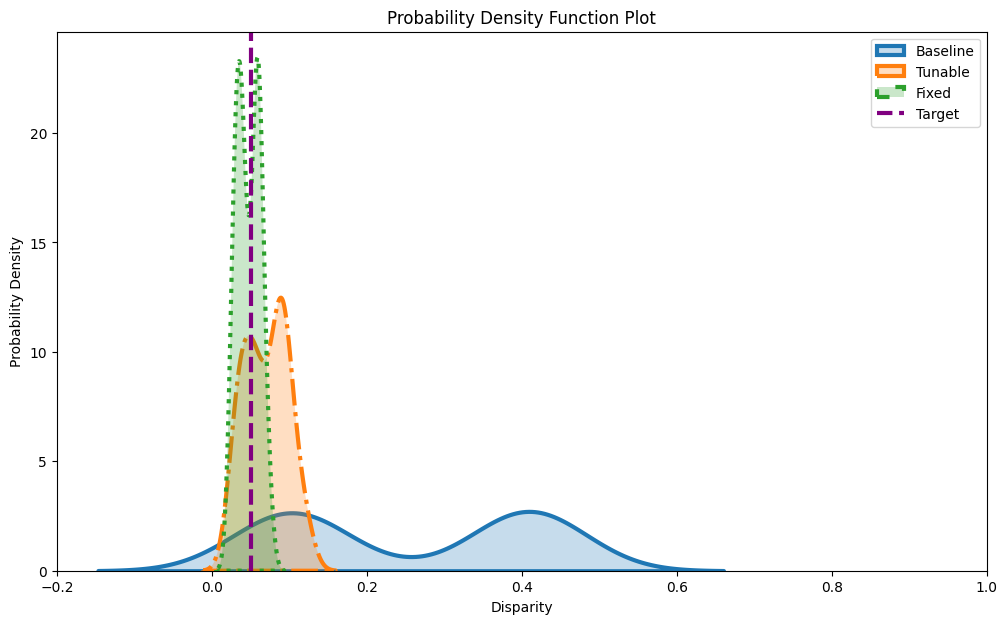

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# change the image size
plt.rcParams["figure.figsize"] = (12, 7)

# Your two sets of data
data1 = baseline_mean
data2 = tunable_mean
data3 = fixed_mean

# Create kernel density estimate plots for both datasets
sns.kdeplot(data1, fill=True, label='Baseline', common_norm=False, linestyle="-", linewidth=3)
sns.kdeplot(data2, fill=True, label='Tunable', common_norm=False, linestyle="dashdot", linewidth=3)
sns.kdeplot(data3, fill=True, label='Fixed', common_norm=False, linestyle="dotted", linewidth=3)

# Set x-axis limits between 0 and 1
plt.xlim(-0.2, 1)

plt.axvline(
        x=0.05,
        color="purple",
        linestyle="--",
        linewidth=3,
        label="Target",
    )

# Add labels and title
plt.xlabel('Disparity')
plt.ylabel('Probability Density')
plt.title('Probability Density Function Plot')

# Show the legend
plt.legend()

# Show the plot
plt.show()

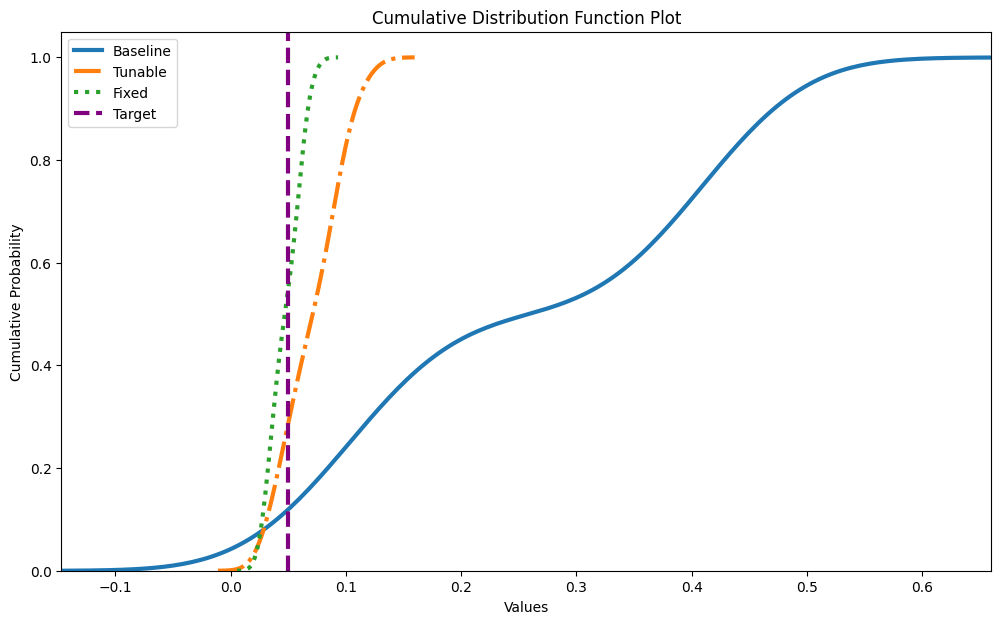

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Your two sets of data
data1 = baseline_mean
data2 = tunable_mean
data3 = fixed_mean

# Create kernel density estimate plots for both datasets with CDF
sns.kdeplot(data1, fill=False, cumulative=True, label='Baseline', linestyle="-", linewidth=3)
sns.kdeplot(data2, fill=False, cumulative=True, label='Tunable', linestyle="dashdot", linewidth=3)
sns.kdeplot(data3, fill=False, cumulative=True, label='Fixed', linestyle="dotted", linewidth=3)

# Set x-axis limits between 0 and 1
# plt.xlim(0, 1)
plt.axvline(
        x=0.05,
        color="purple",
        linestyle="--",
        linewidth=3,
        label="Target",
    )
# Add labels and title
plt.xlabel('Values')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution Function Plot')

# Show the legend
plt.legend()

# Show the plot
plt.show()

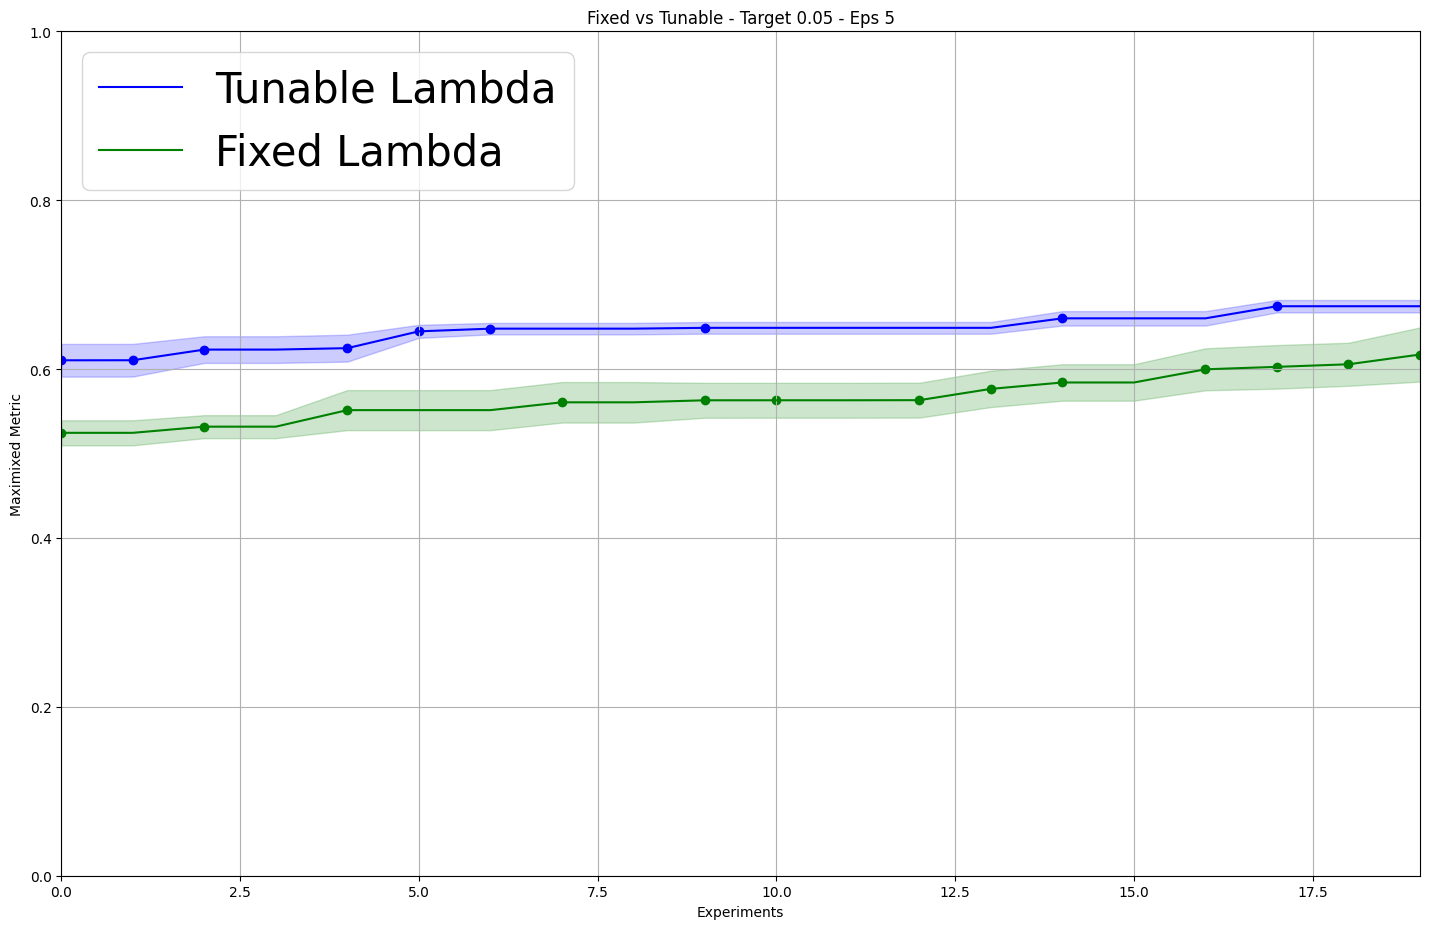

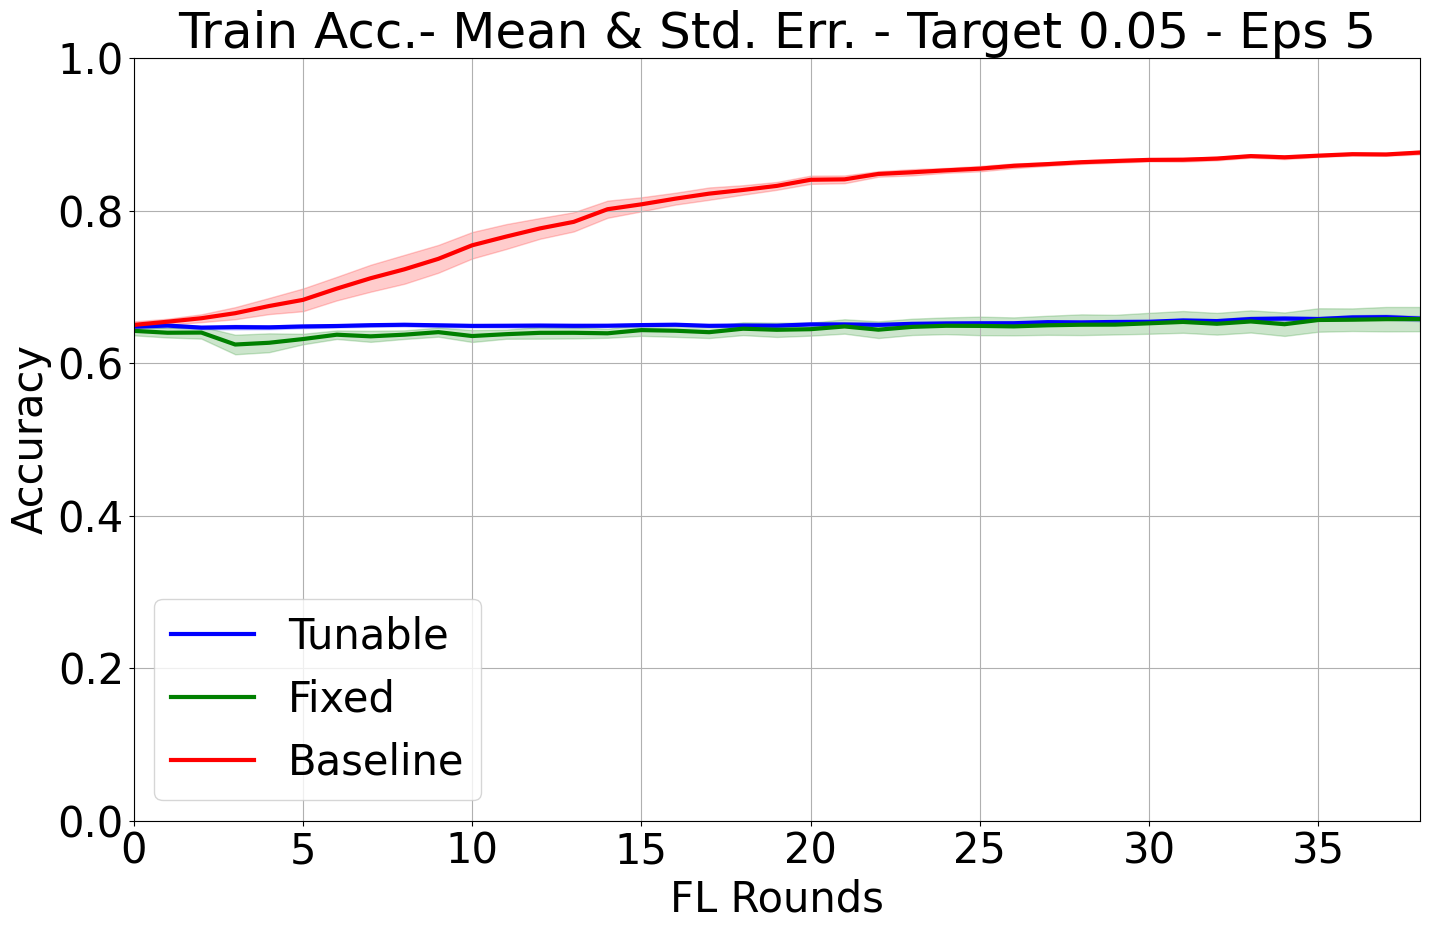

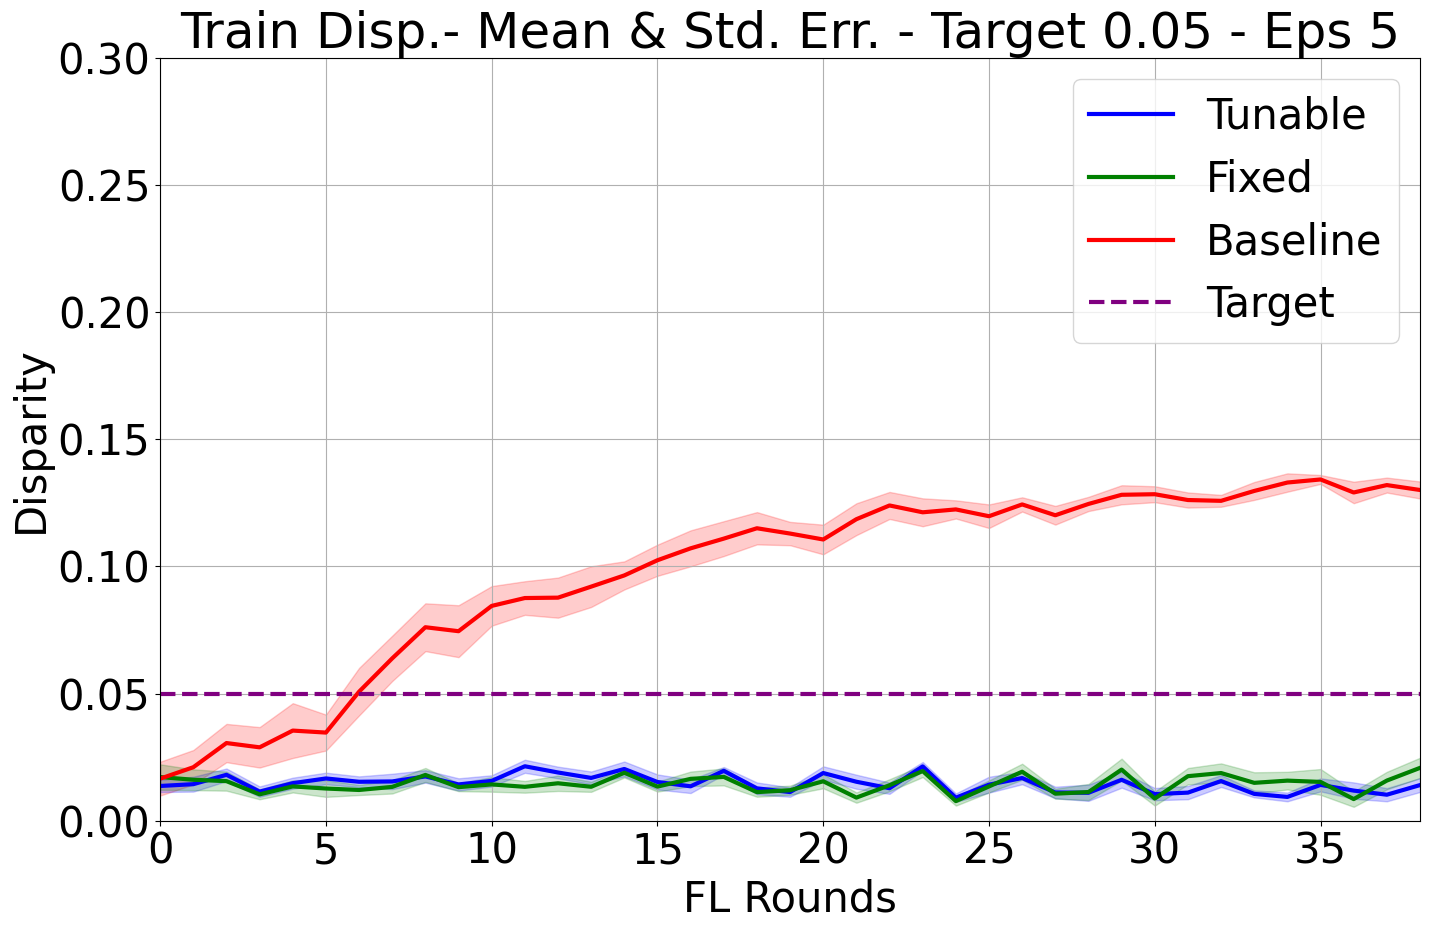

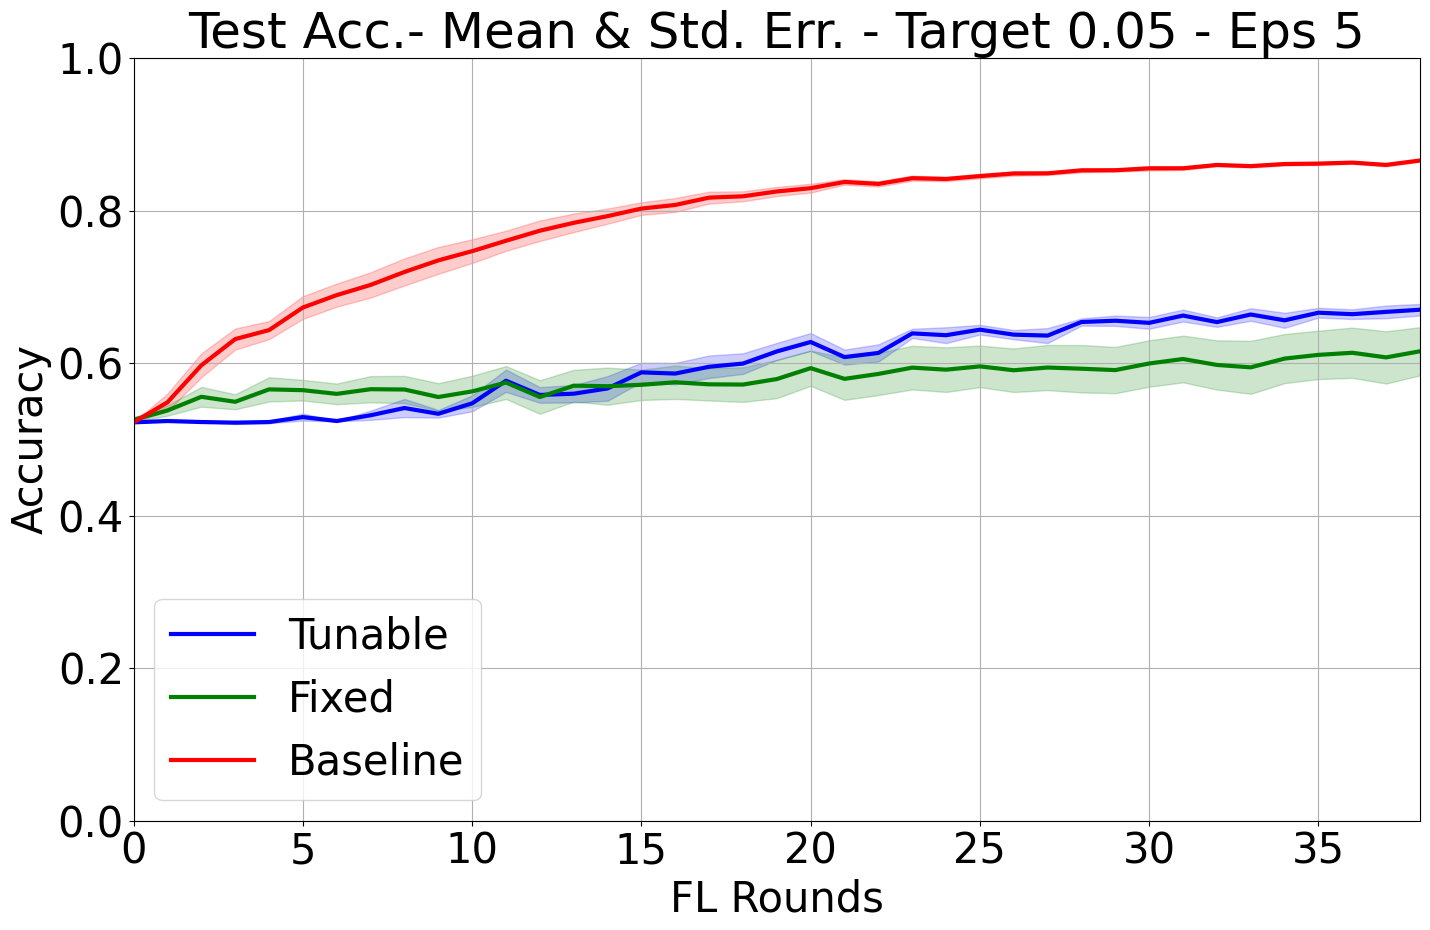

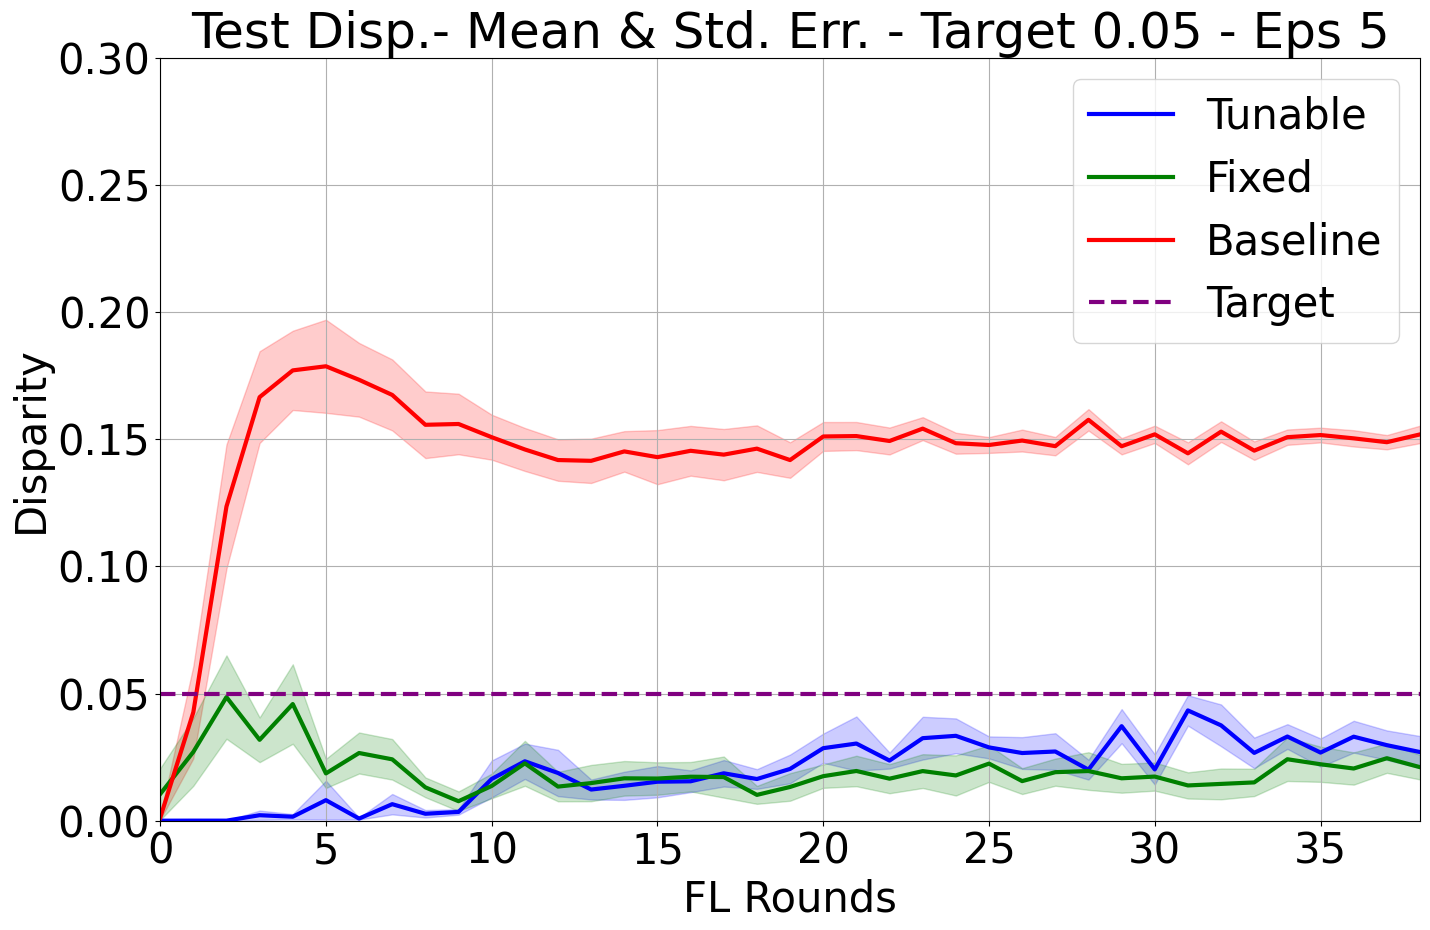

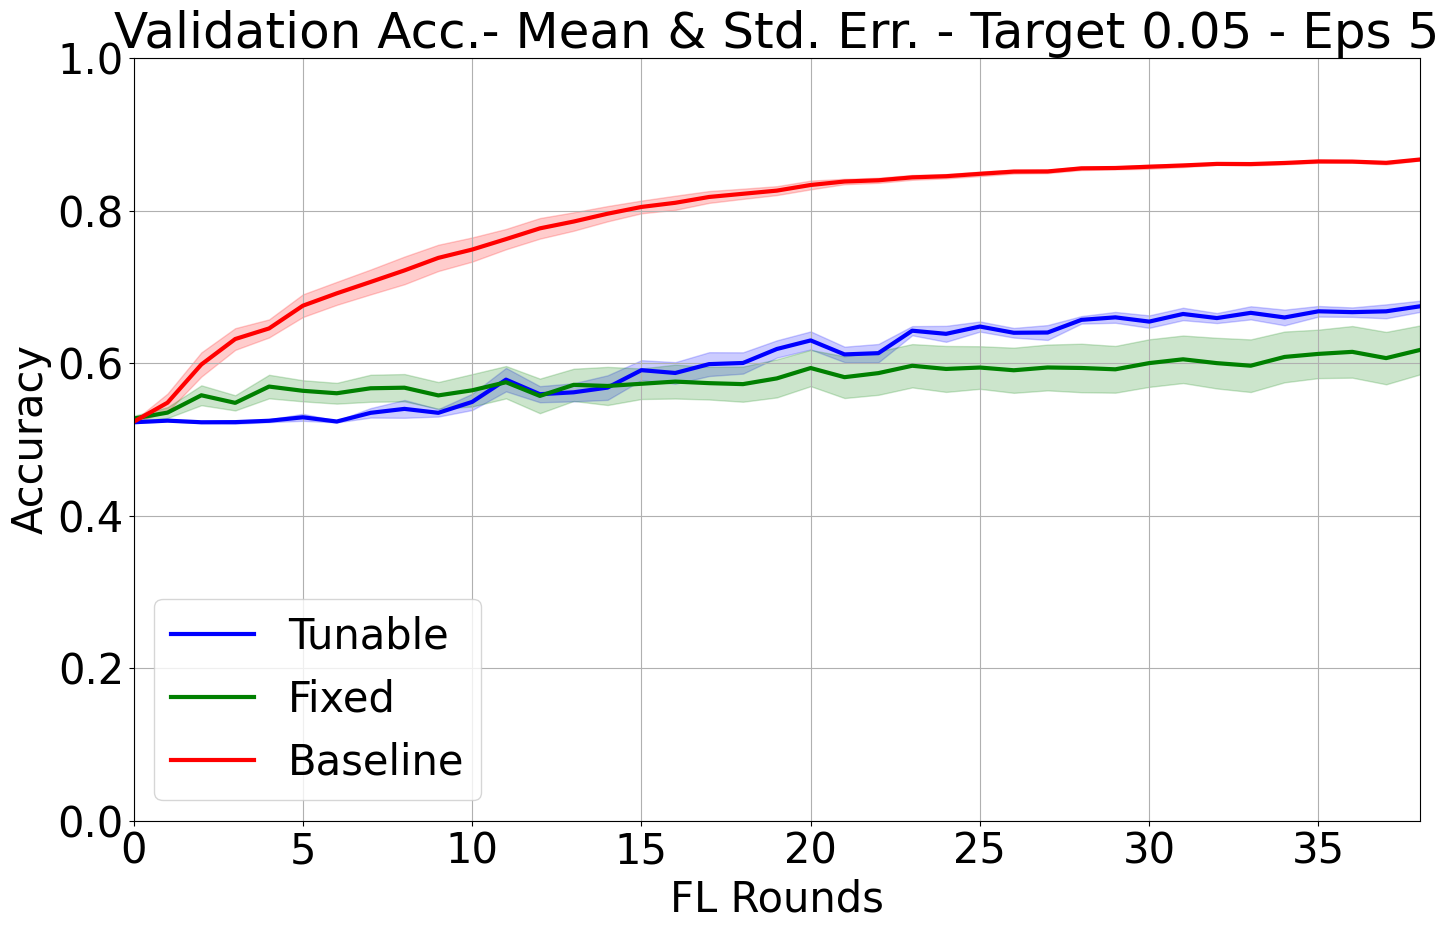

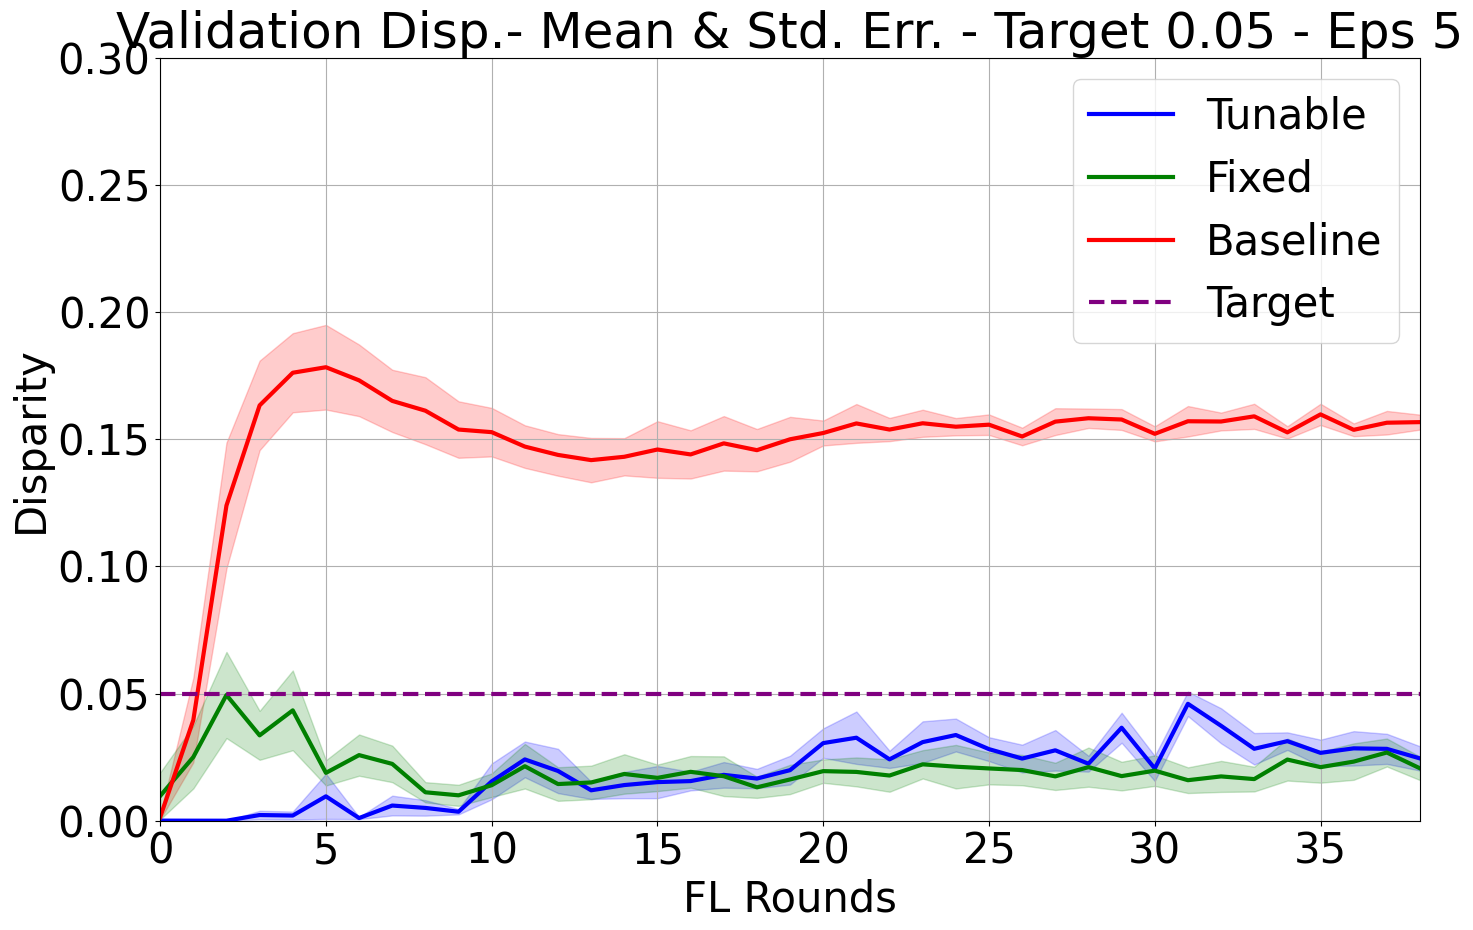

In [12]:
best_runs_tunable, best_runs_fixed, best_run_baseline = manage_plots(
    data=data,
    data_baseline=data_baseline_5,
    target=0.05,
    project_name=project_name,
    epsilon=5,
)

In [13]:
target_005_epsilon_5_tunable_test, target_005_epsilon_5_fixed_test = get_last_accuracy_mean(best_runs_tunable, best_runs_fixed)
target_005_epsilon_5_tunable_validation, target_005_epsilon_5_fixed_validation = get_last_accuracy_mean_validation(best_runs_tunable, best_runs_fixed)
target_005_epsilon_5_tunable_train, target_005_epsilon_5_fixed_train = get_last_accuracy_mean_train(best_runs_tunable, best_runs_fixed)

# Target 0.05 Epsilon 8

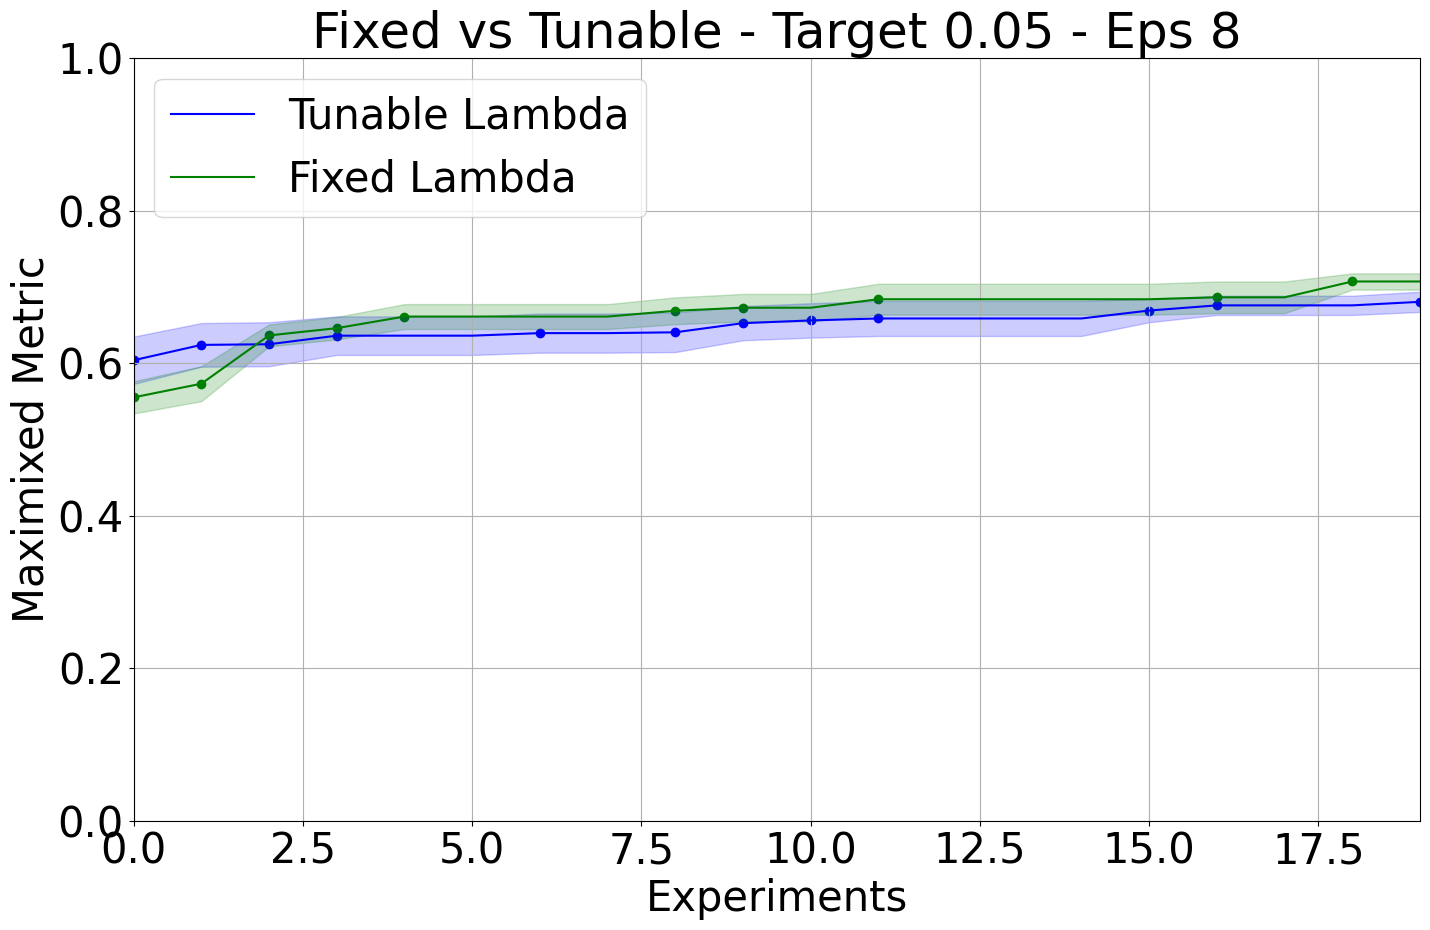

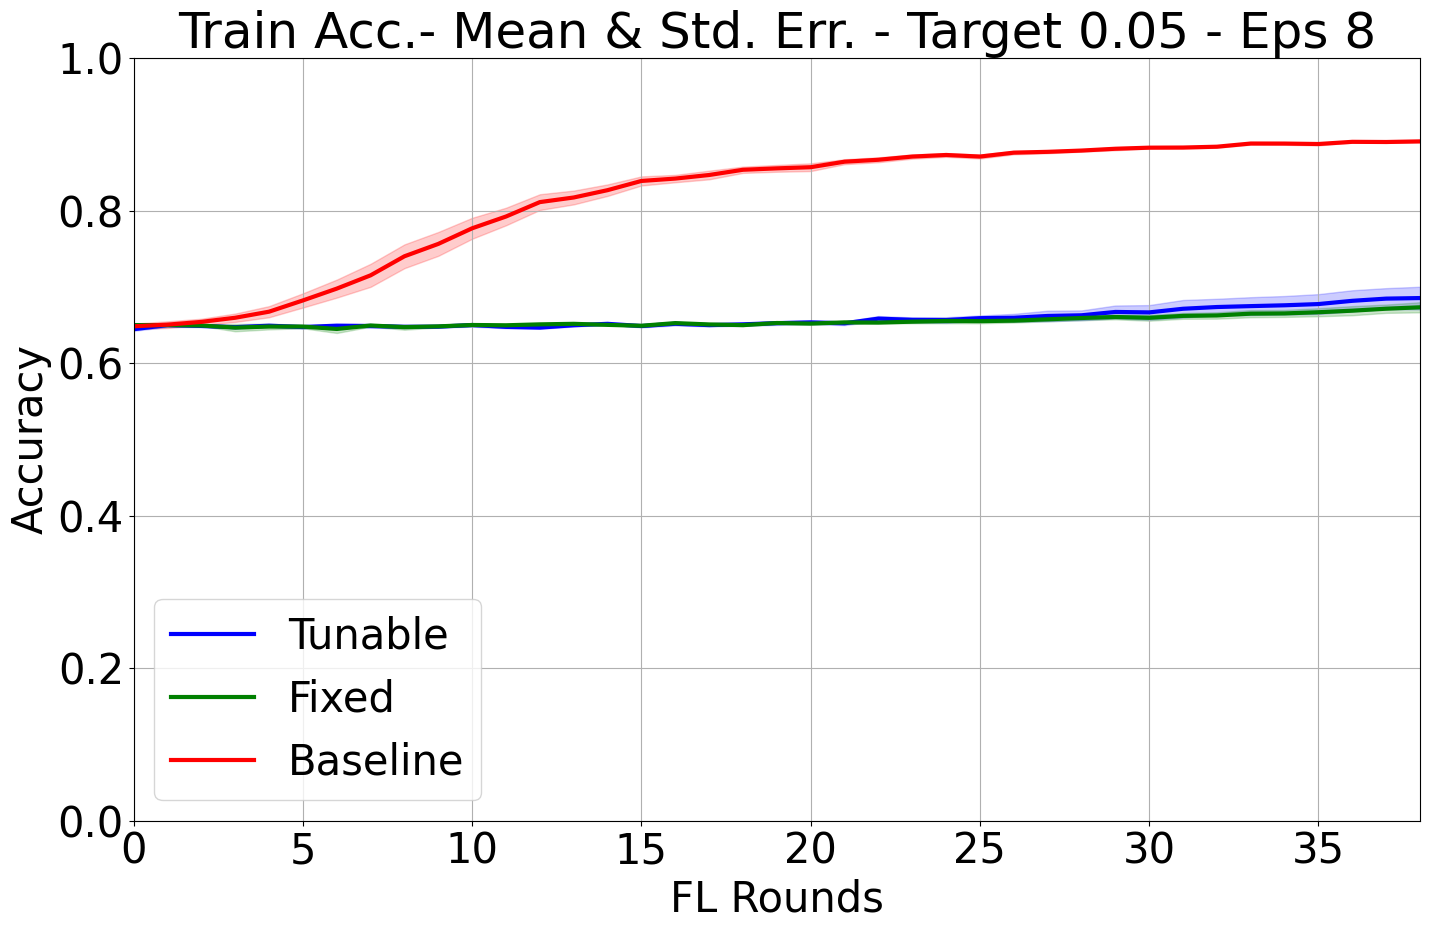

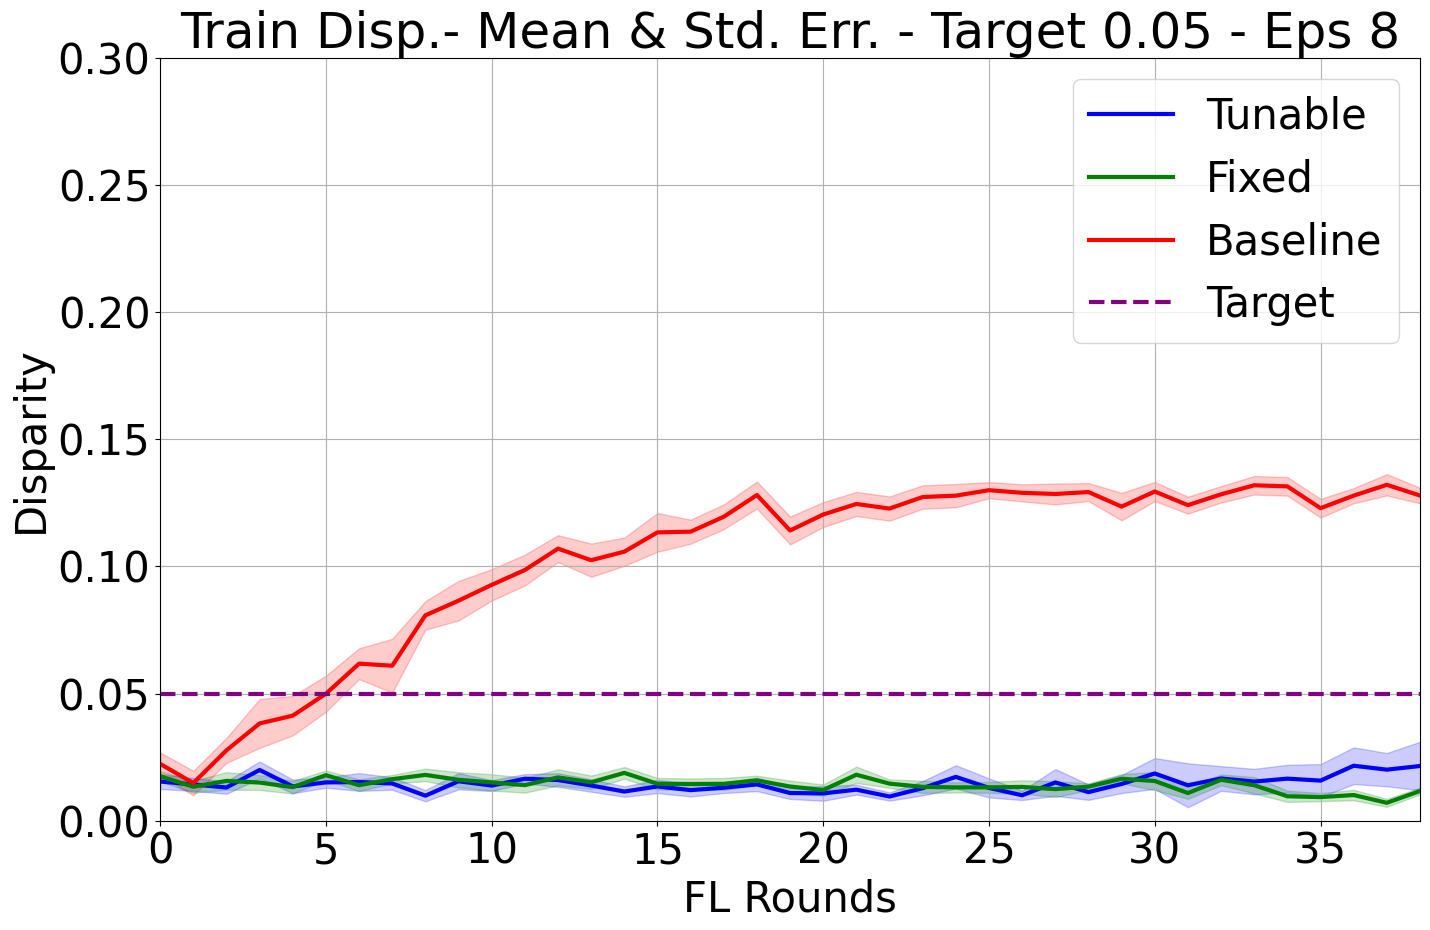

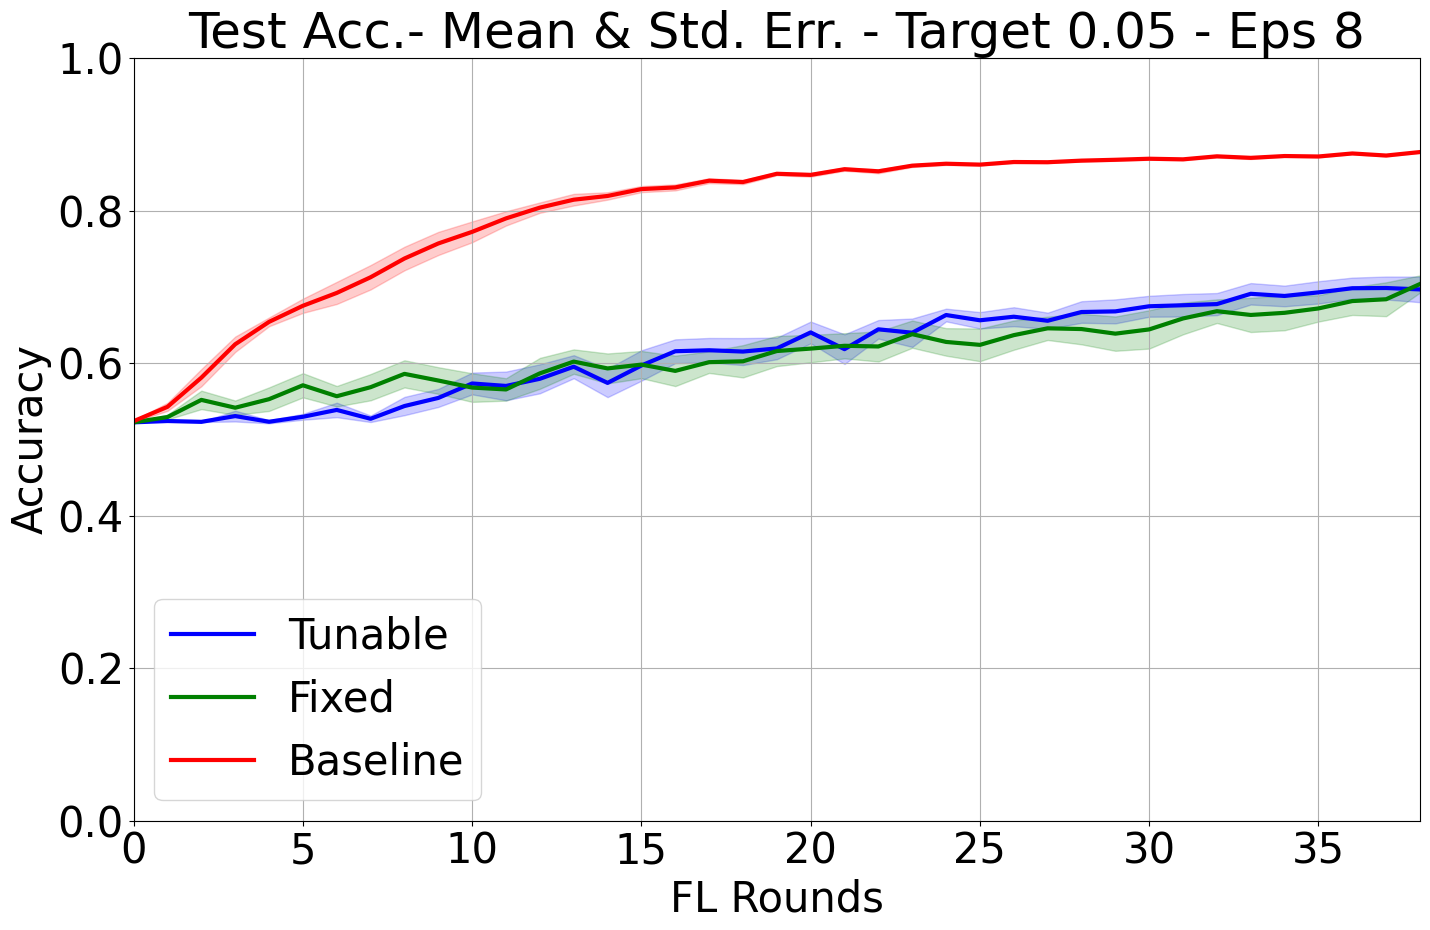

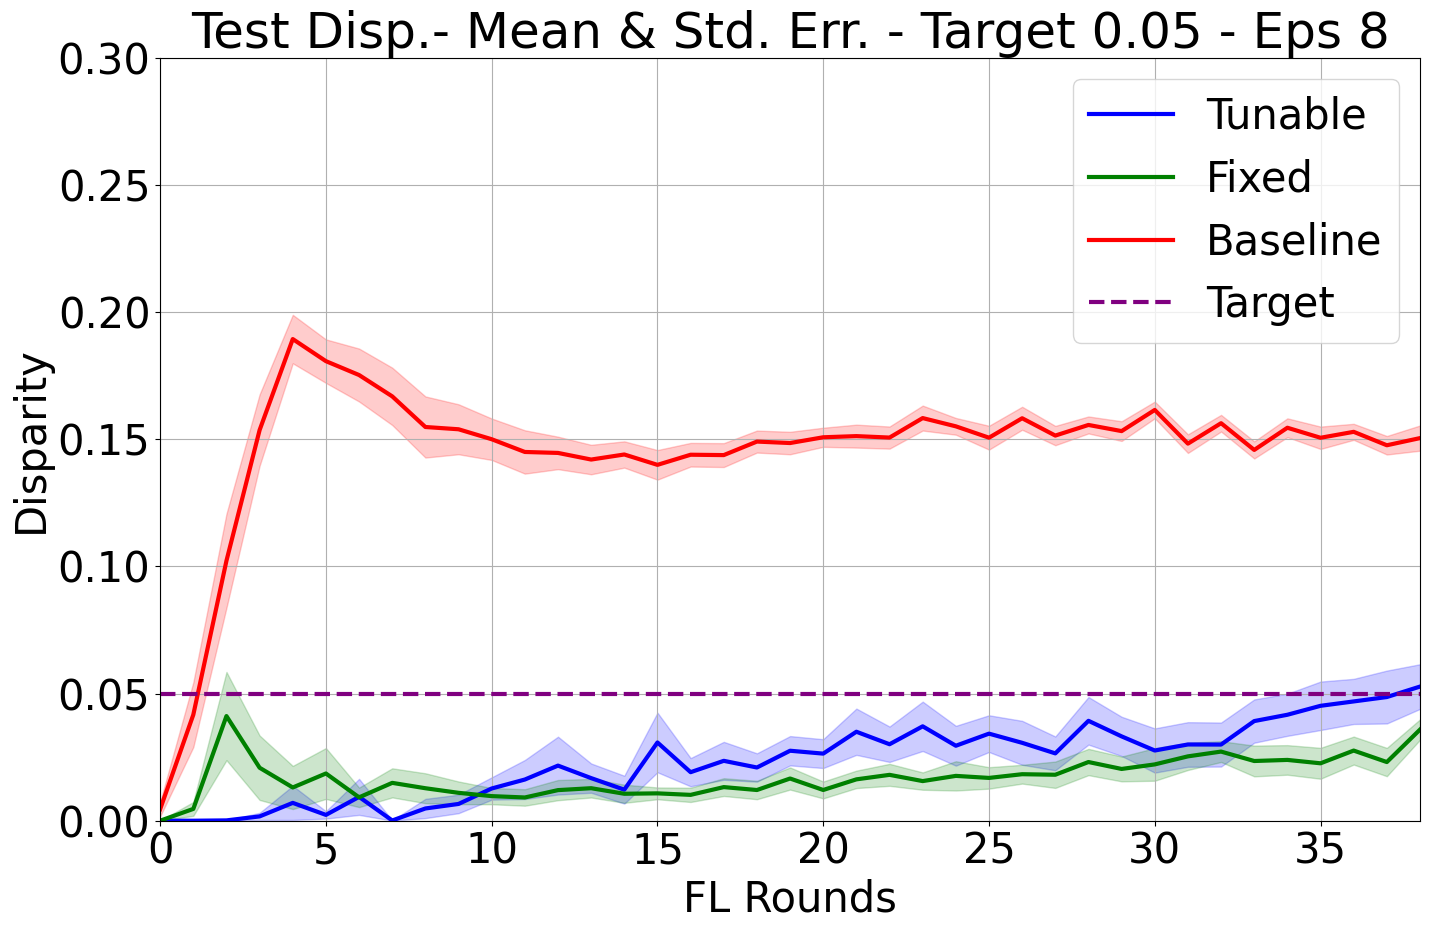

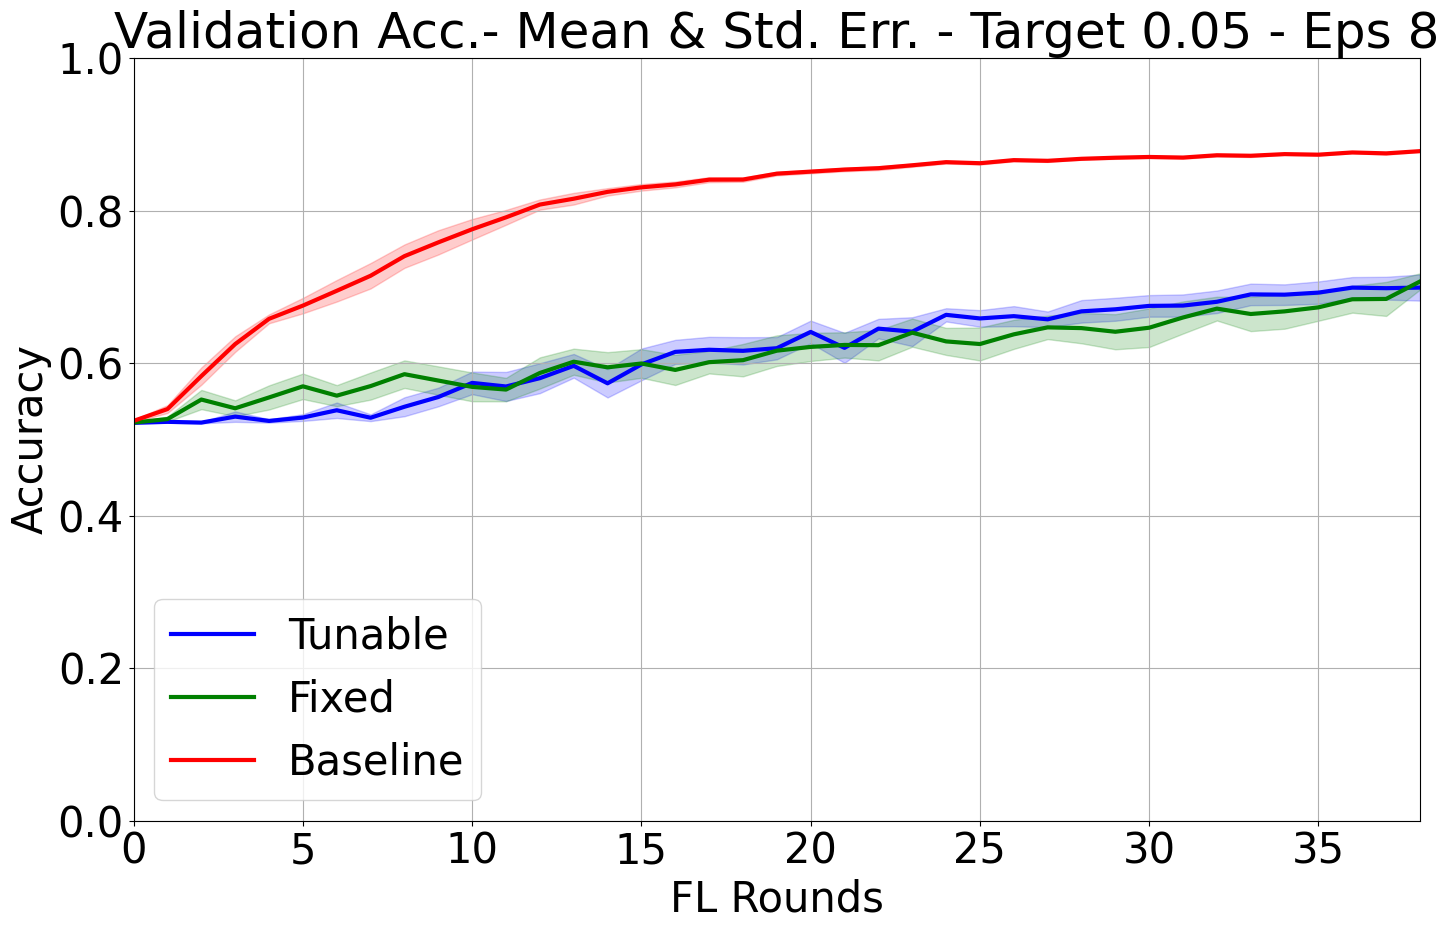

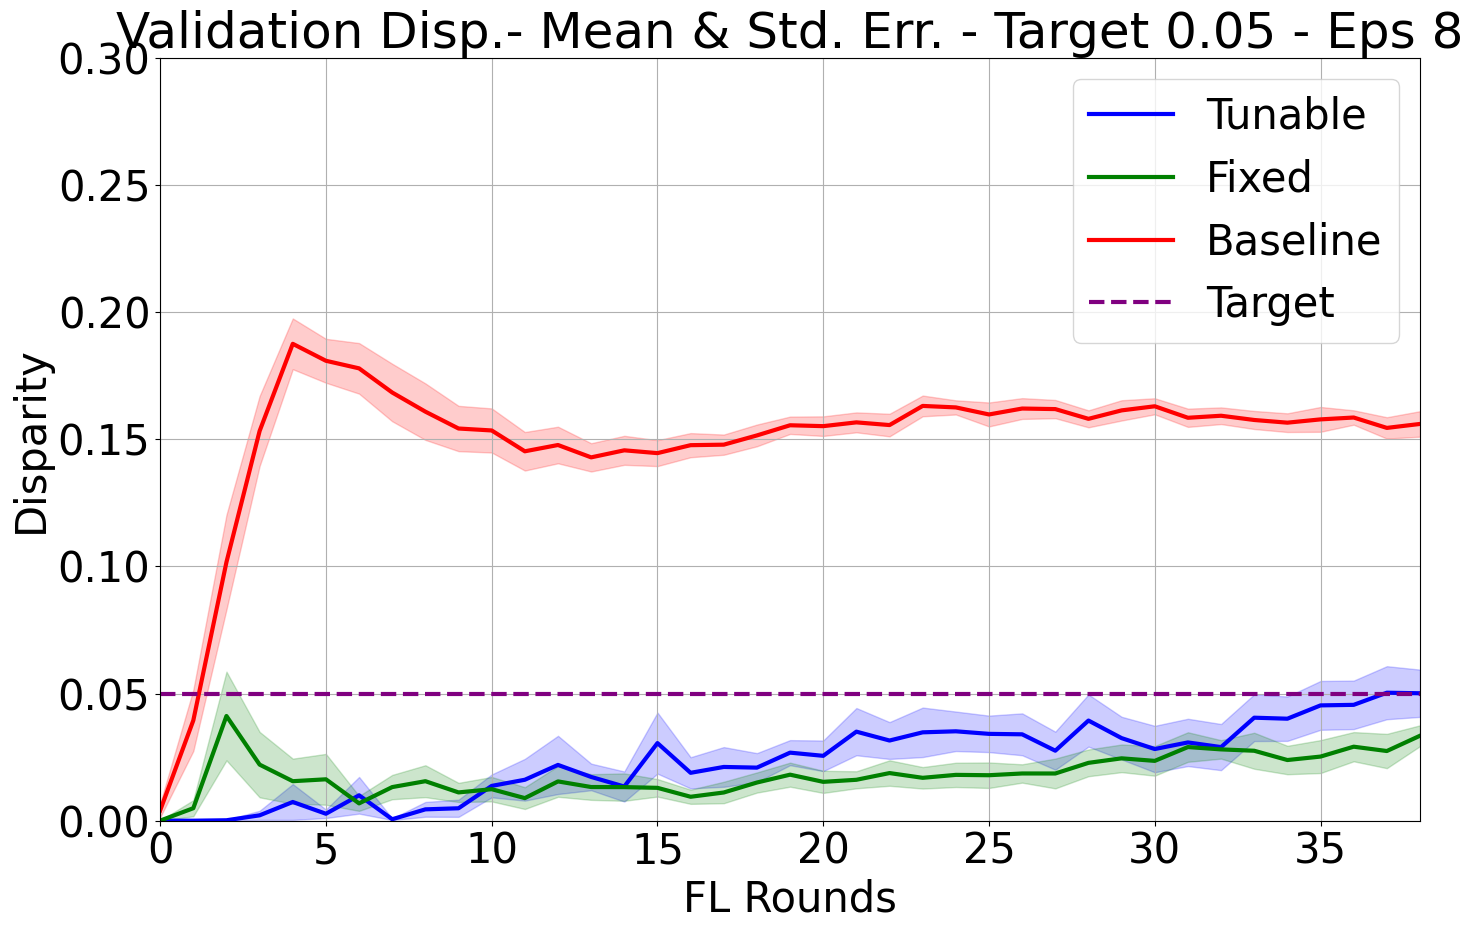

In [14]:
project_name = "Celeba_sweep_005_8"
data = download_data(project_name)
best_runs_tunable, best_runs_fixed, best_run_baseline = manage_plots(
    data=data,
    data_baseline=data_baseline_8,
    target=0.05,
    project_name=project_name,
    epsilon=8,
)

target_005_epsilon_8_tunable_test, target_005_epsilon_8_fixed_test = get_last_accuracy_mean(best_runs_tunable, best_runs_fixed)
target_005_epsilon_8_tunable_validation, target_005_epsilon_8_fixed_validation = get_last_accuracy_mean_validation(best_runs_tunable, best_runs_fixed)
target_005_epsilon_8_tunable_train, target_005_epsilon_8_fixed_train = get_last_accuracy_mean_train(best_runs_tunable, best_runs_fixed)

# Target 0.075 Epsilon 5

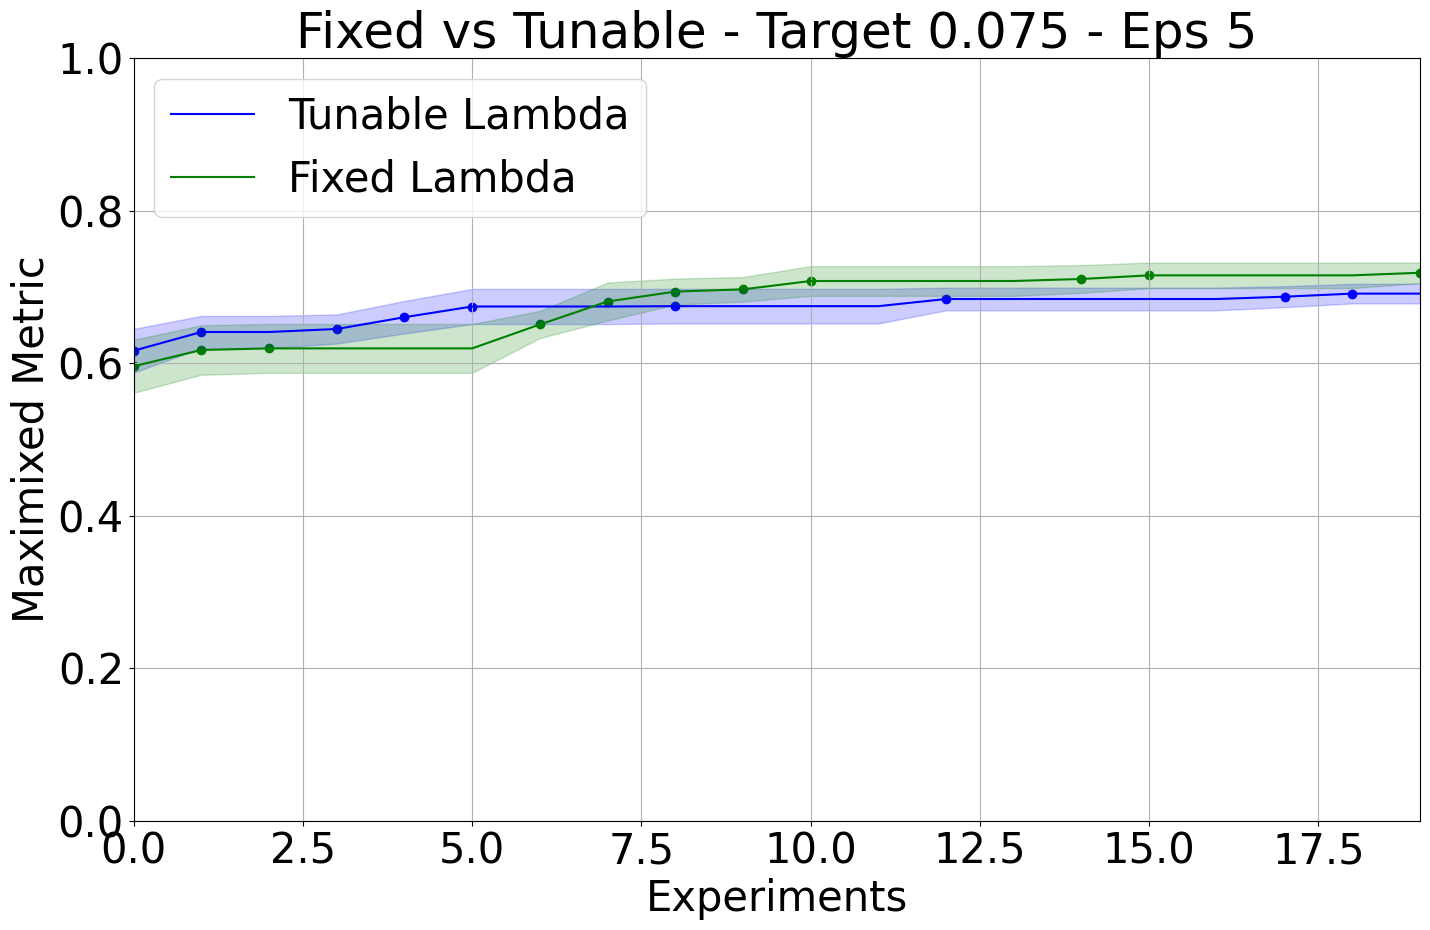

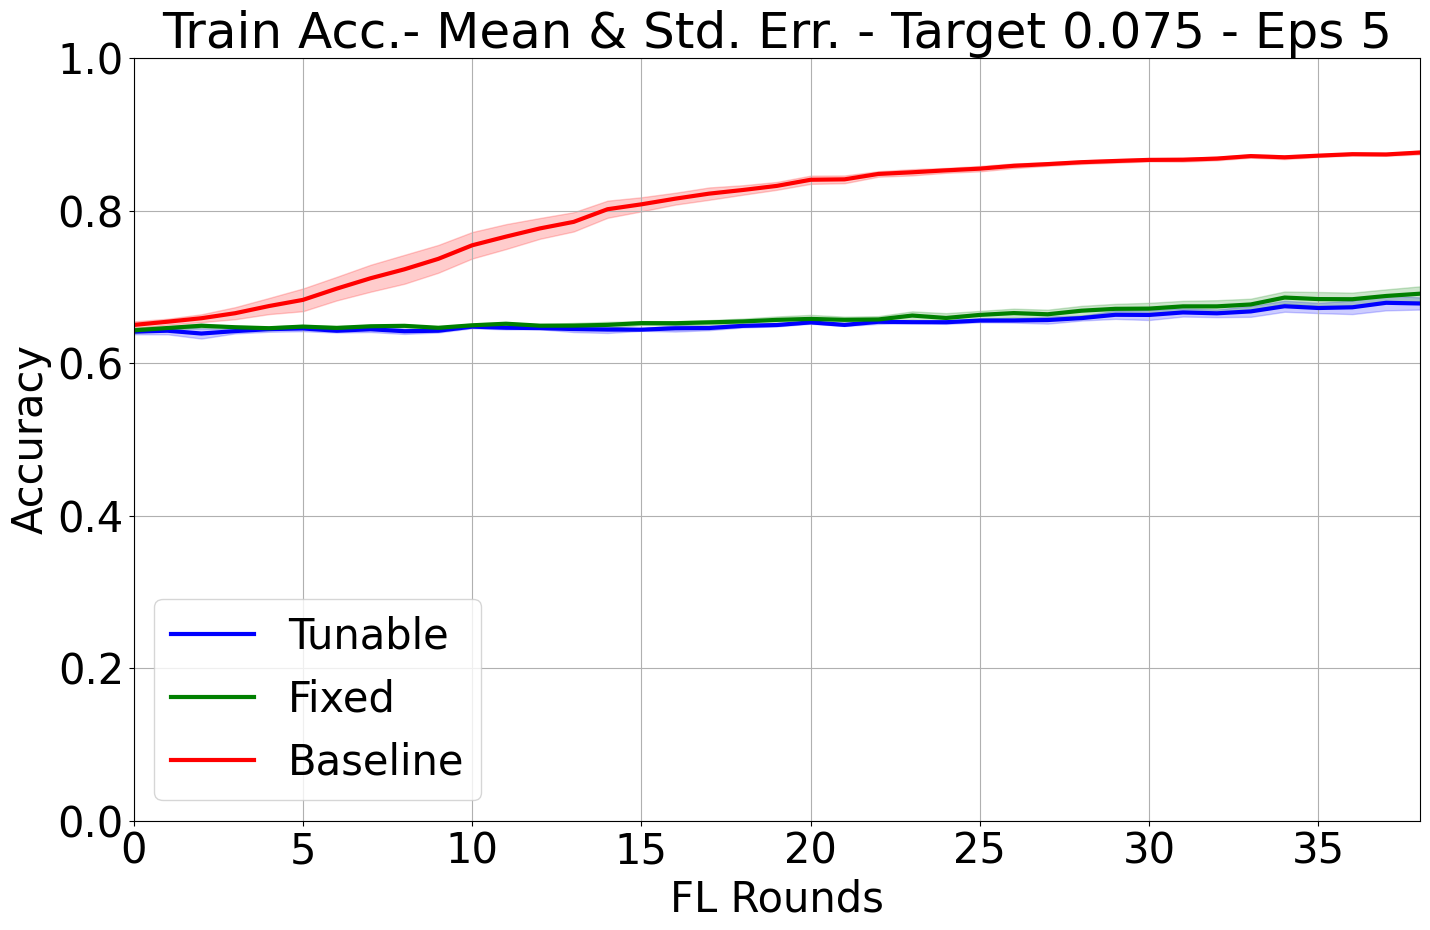

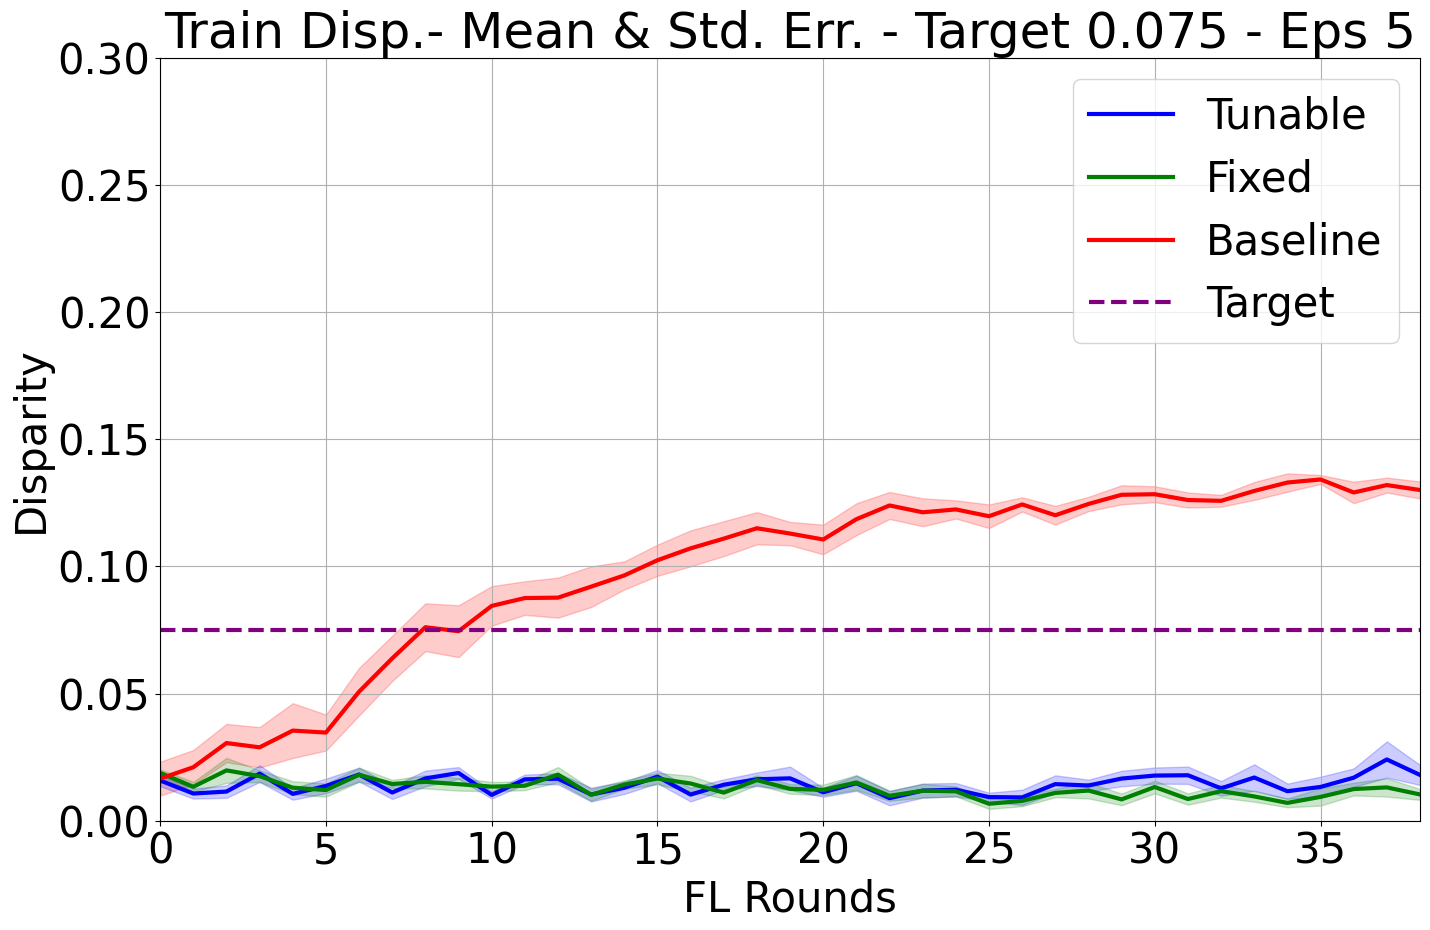

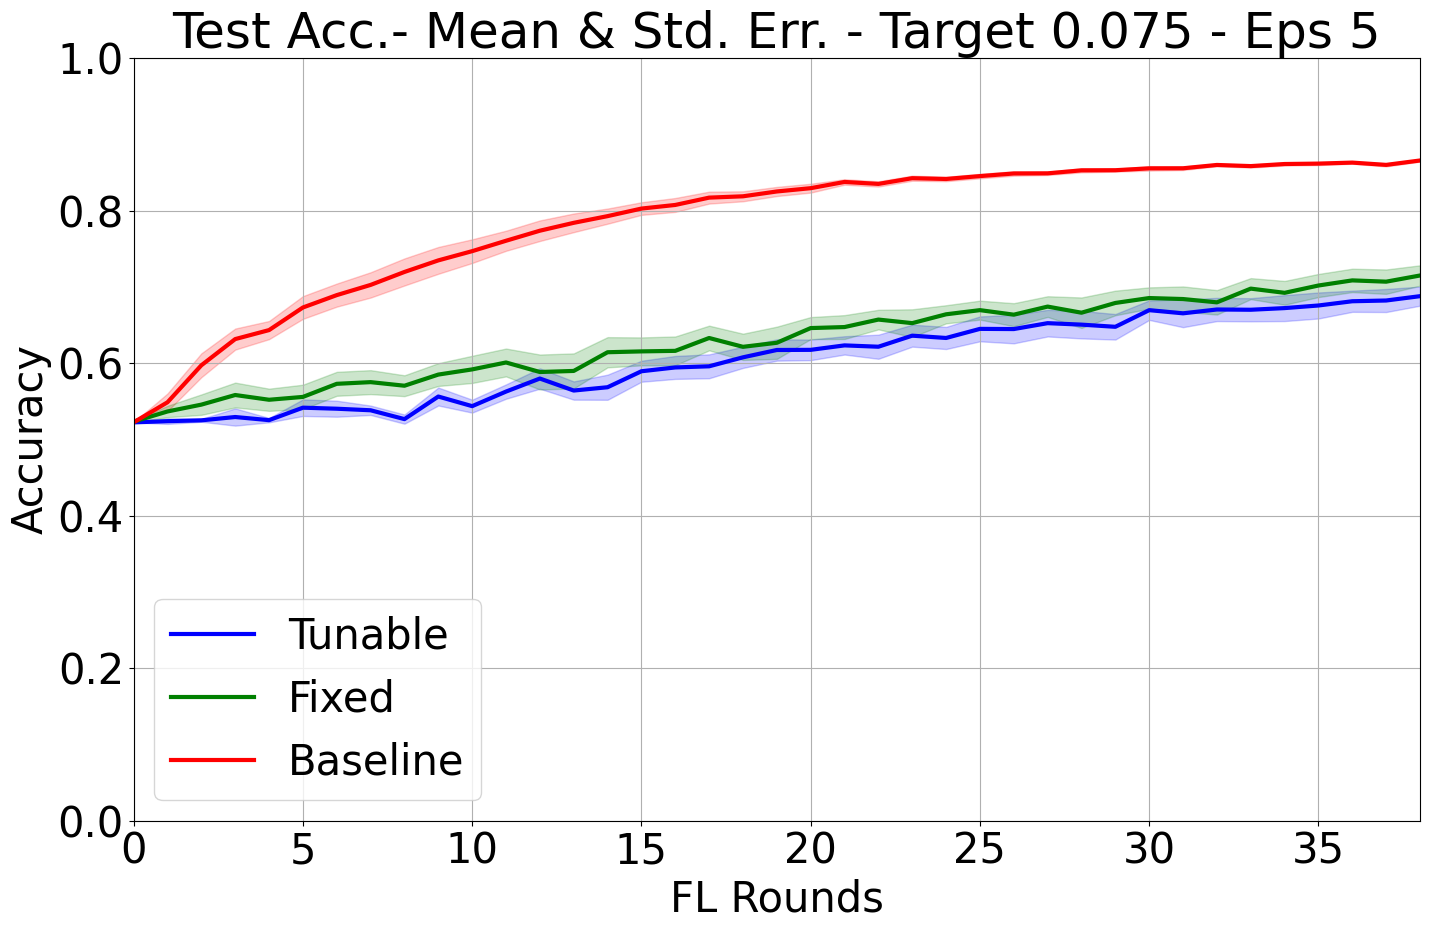

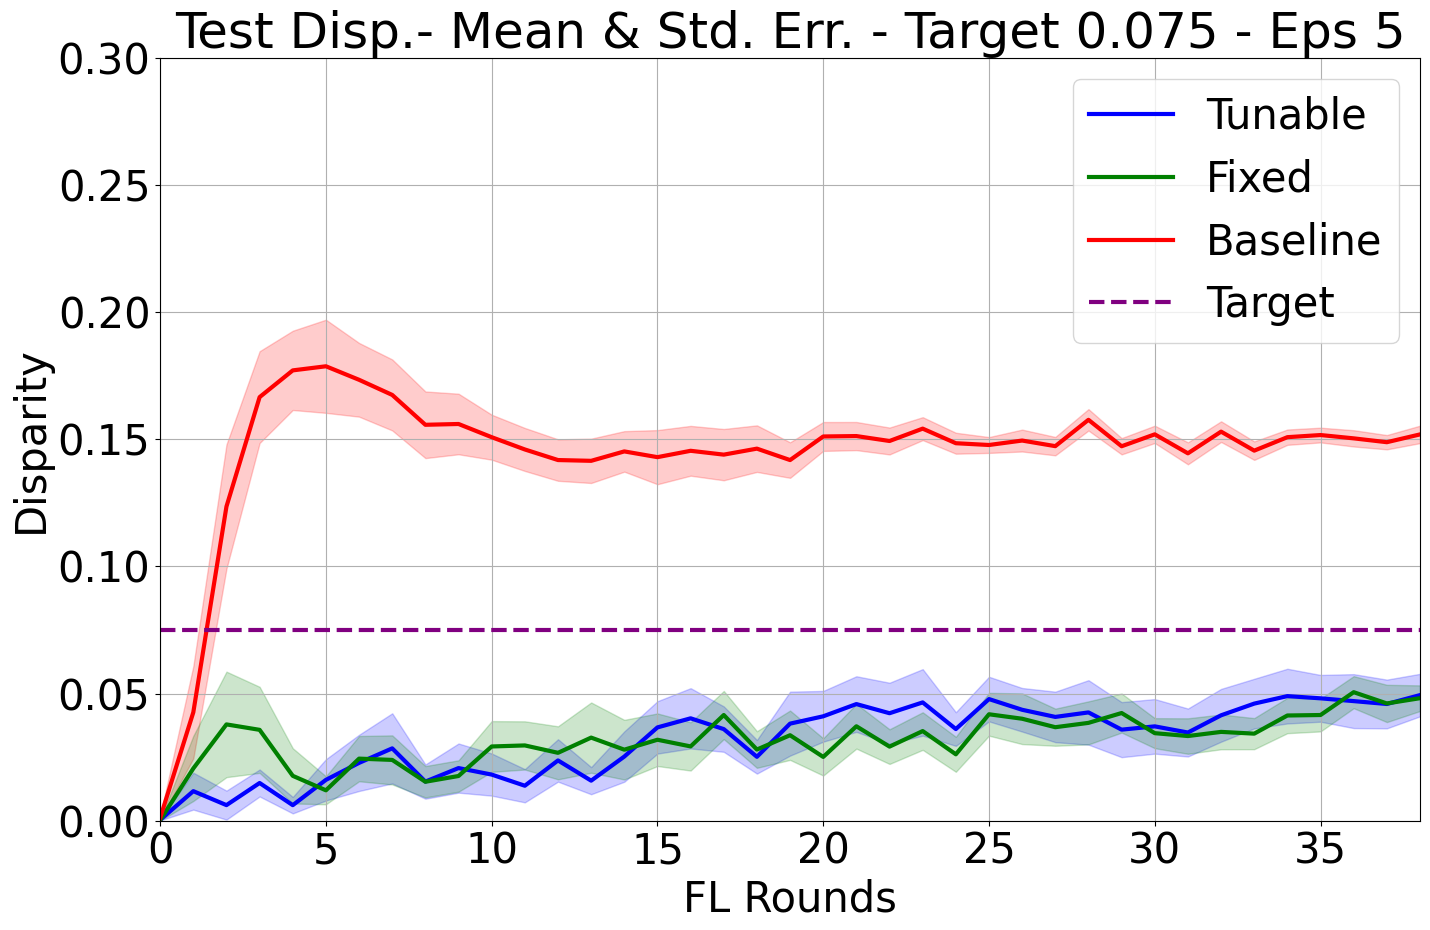

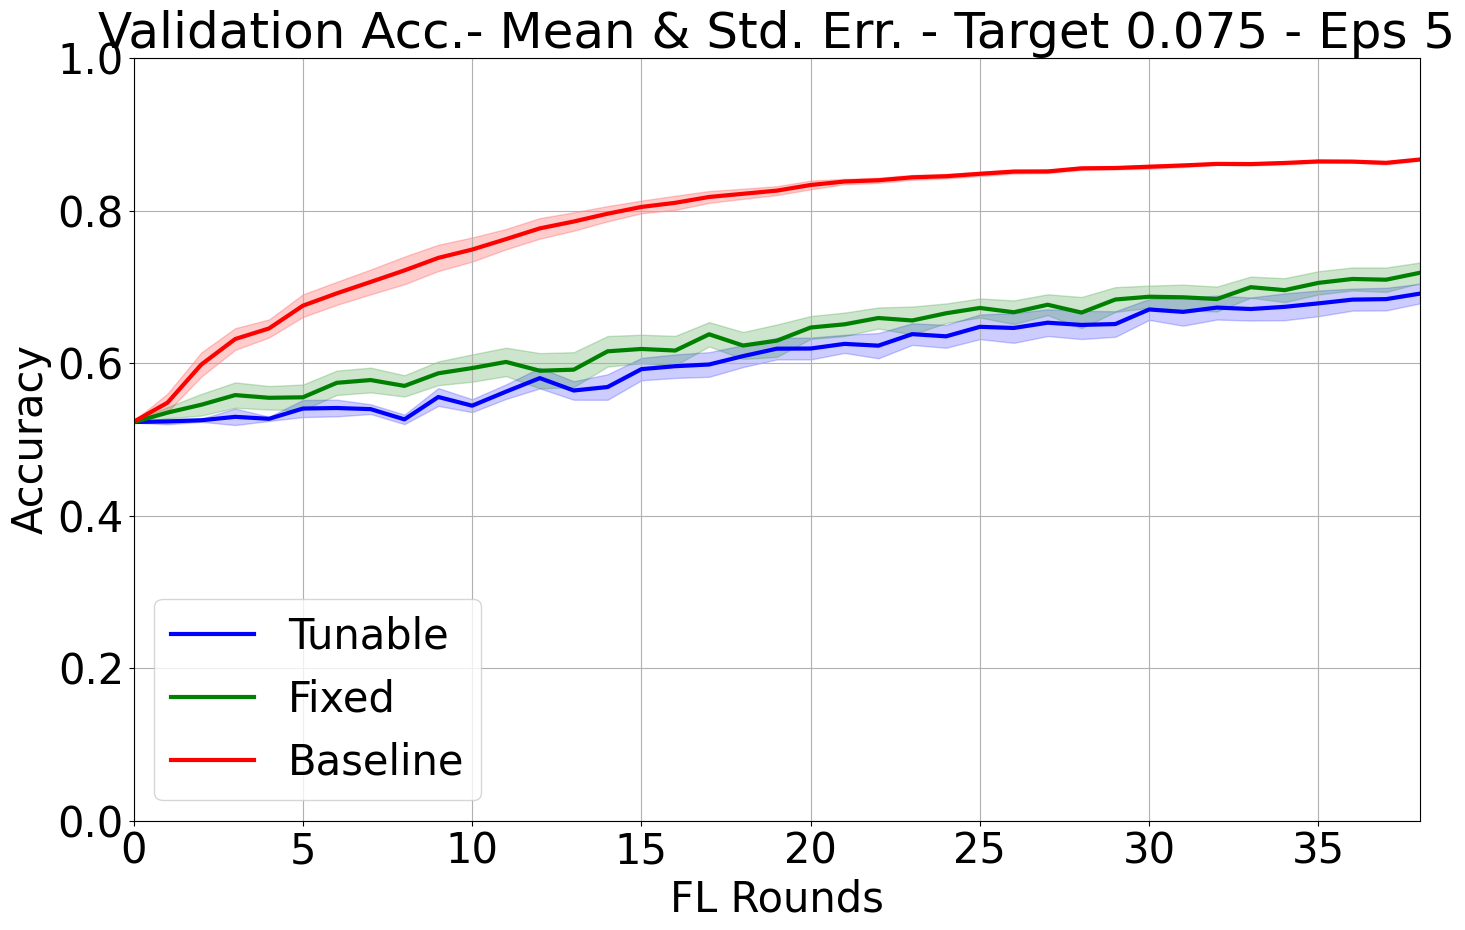

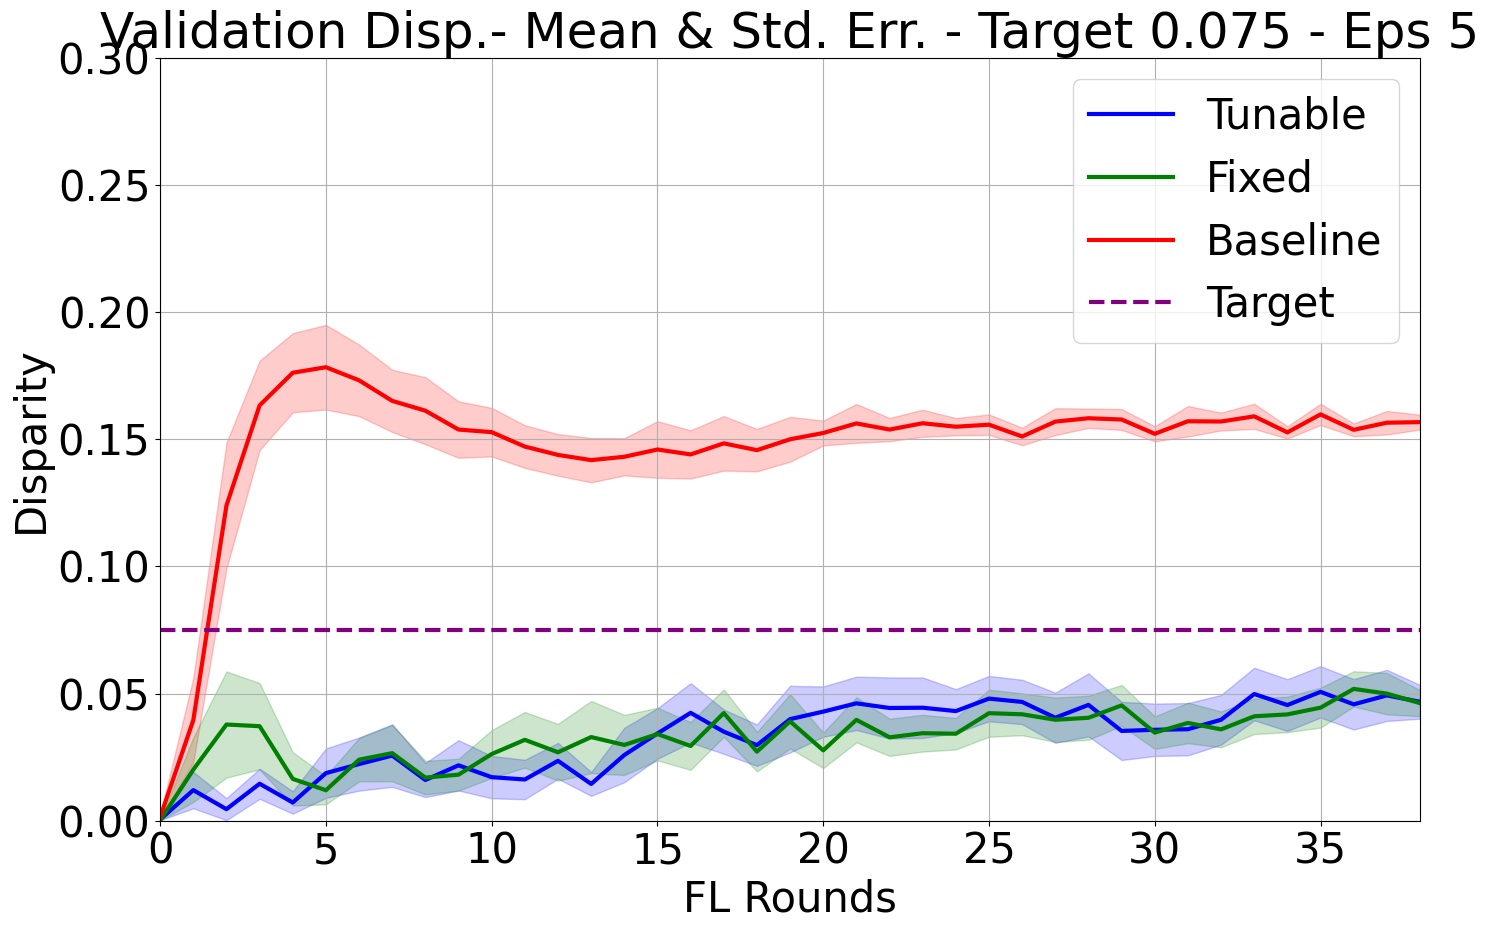

In [15]:
project_name = "Celeba_sweep_0075_5"
data = download_data(project_name)
best_runs_tunable, best_runs_fixed, best_run_baseline = manage_plots(
    data=data,
    data_baseline=data_baseline_5,
    target=0.075,
    project_name=project_name,
    epsilon=5,
)

target_0075_epsilon_5_tunable_test, target_0075_epsilon_5_fixed_test = get_last_accuracy_mean(best_runs_tunable, best_runs_fixed)
target_0075_epsilon_5_tunable_validation, target_0075_epsilon_5_fixed_validation = get_last_accuracy_mean_validation(best_runs_tunable, best_runs_fixed)
target_0075_epsilon_5_tunable_train, target_0075_epsilon_5_fixed_train = get_last_accuracy_mean_train(best_runs_tunable, best_runs_fixed)

# Target 0.075 Epsilon 8

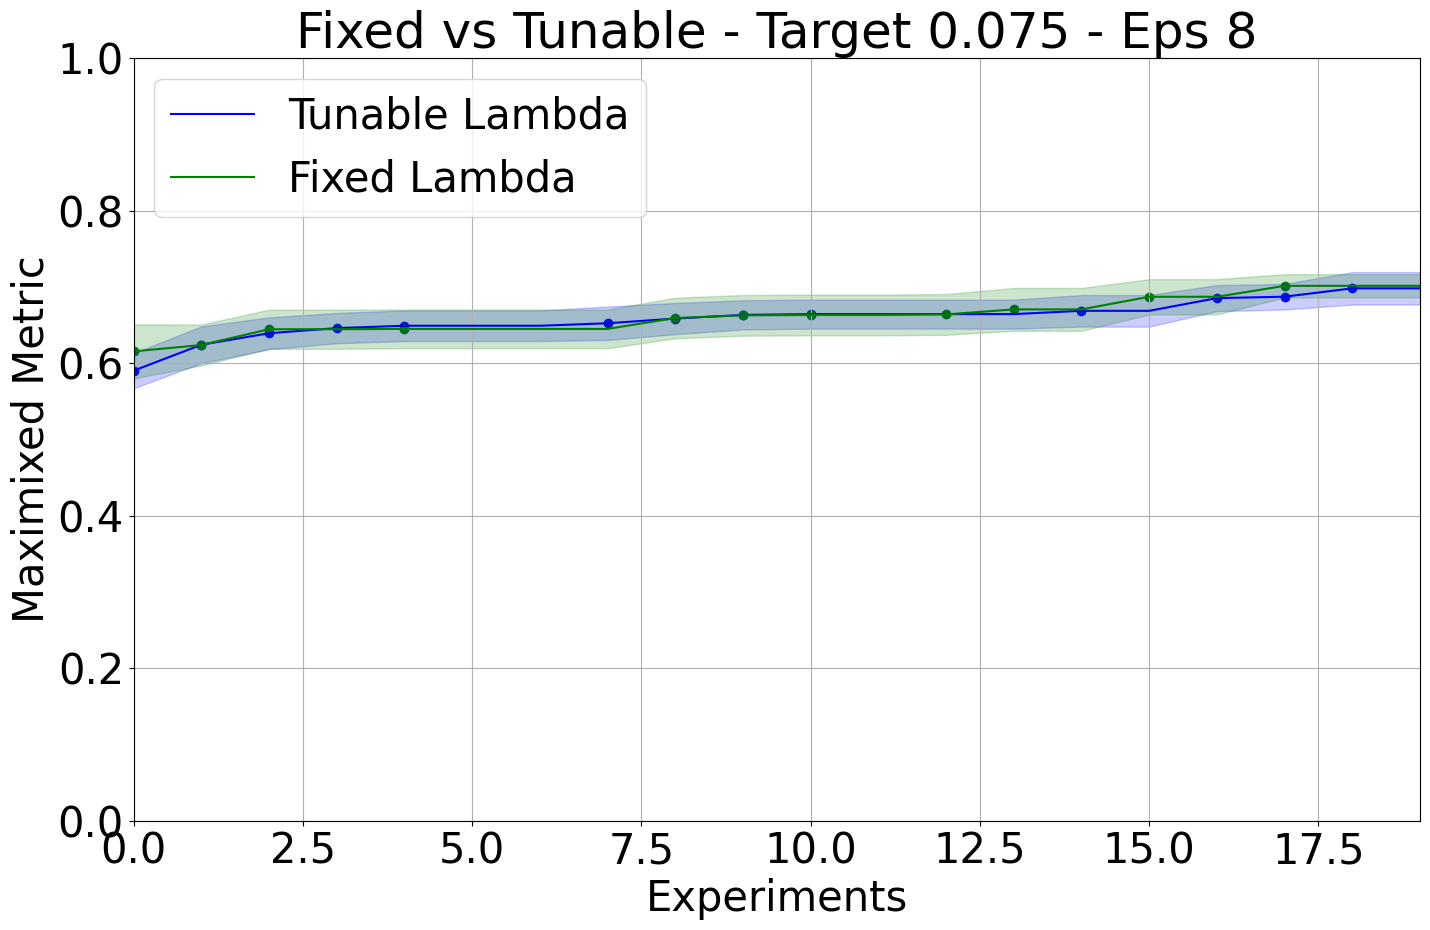

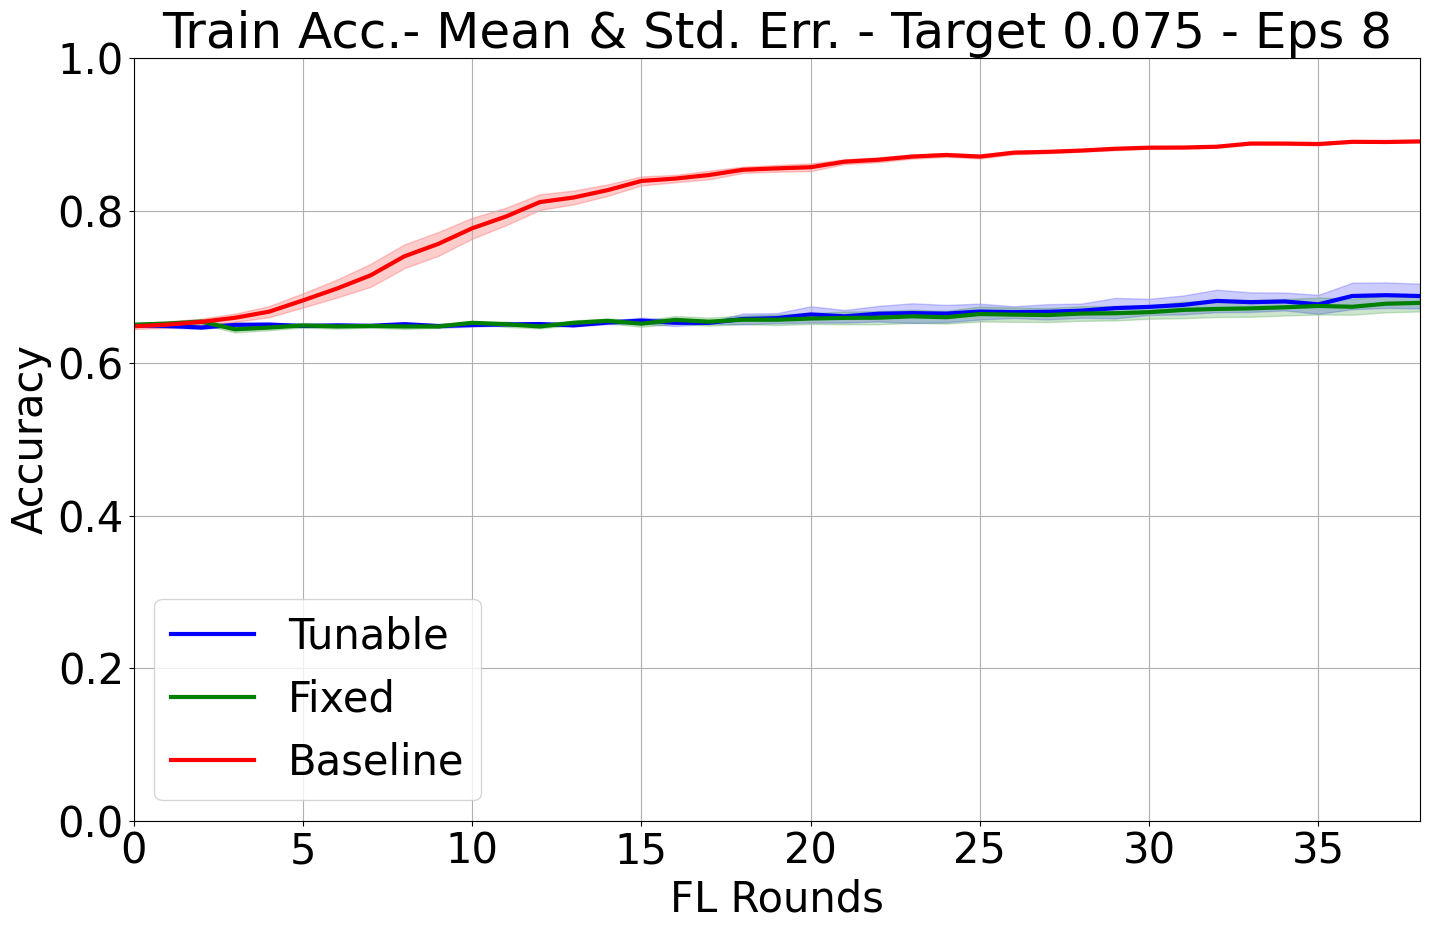

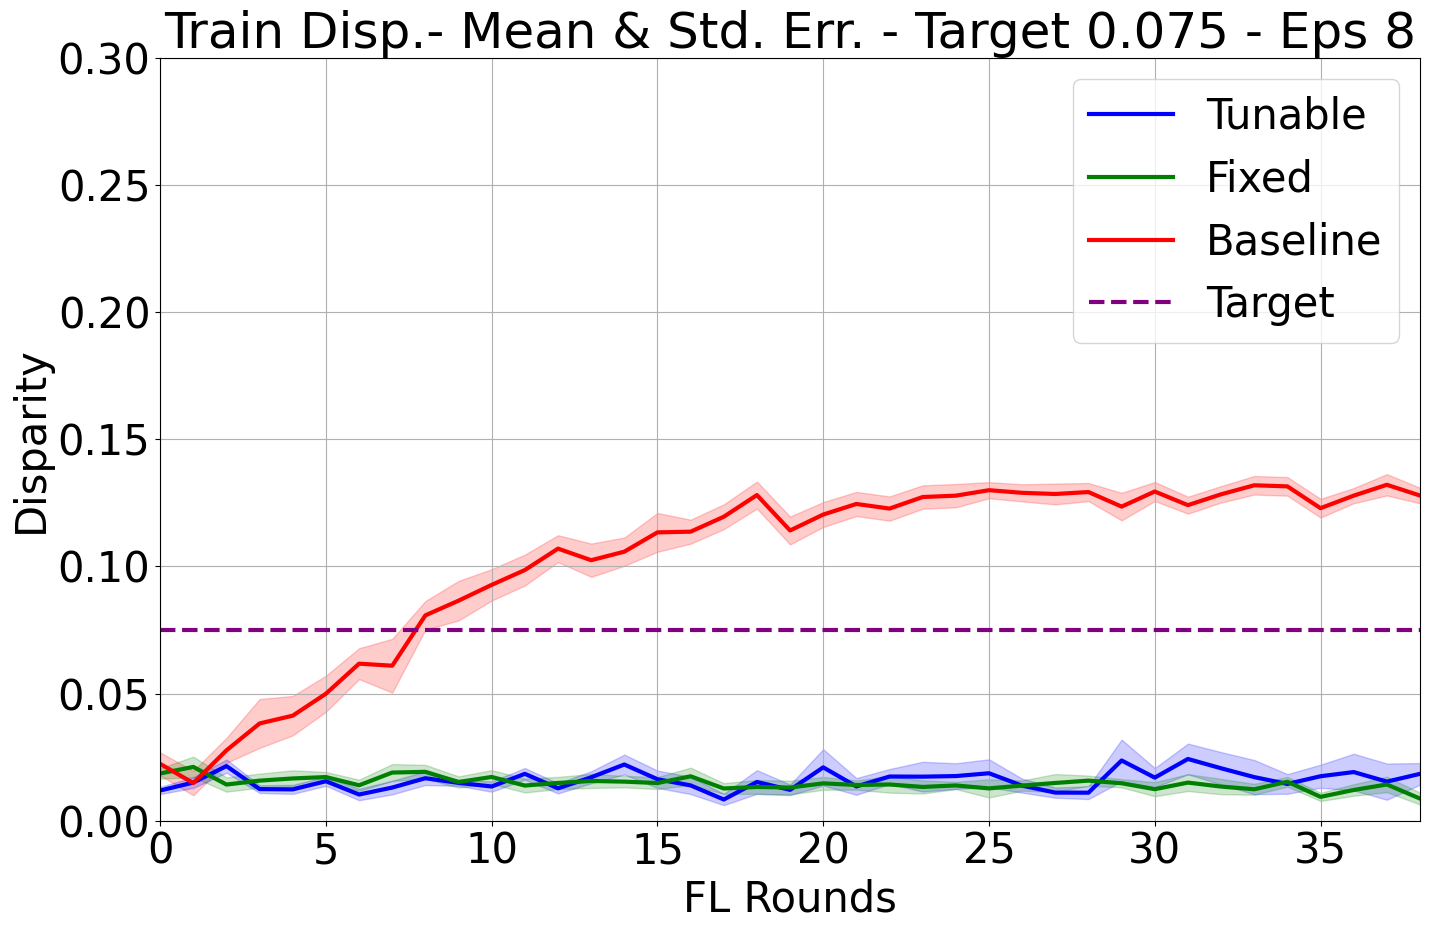

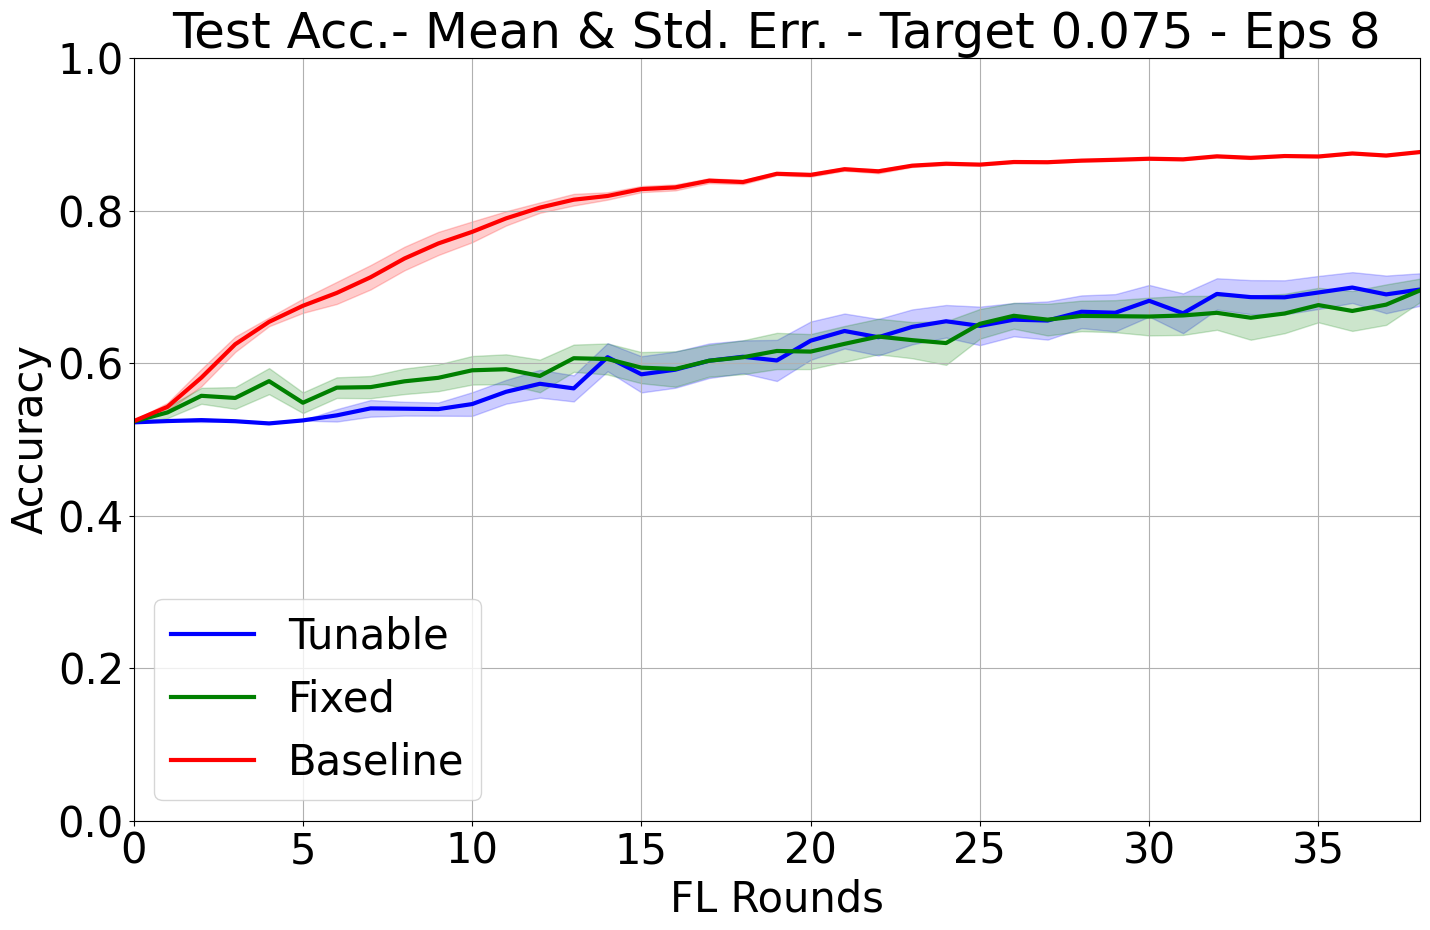

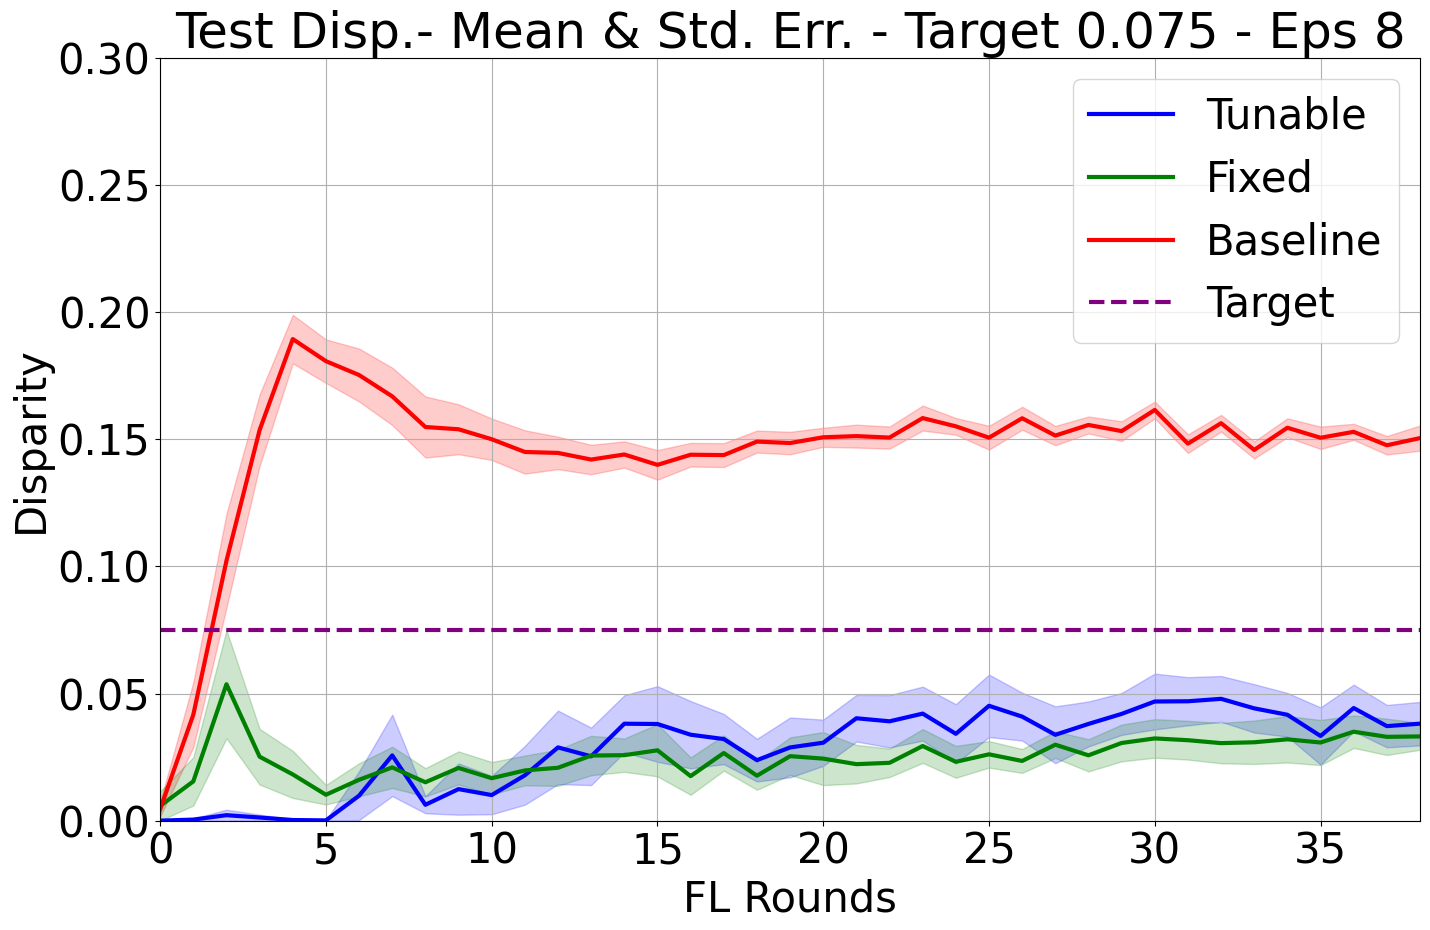

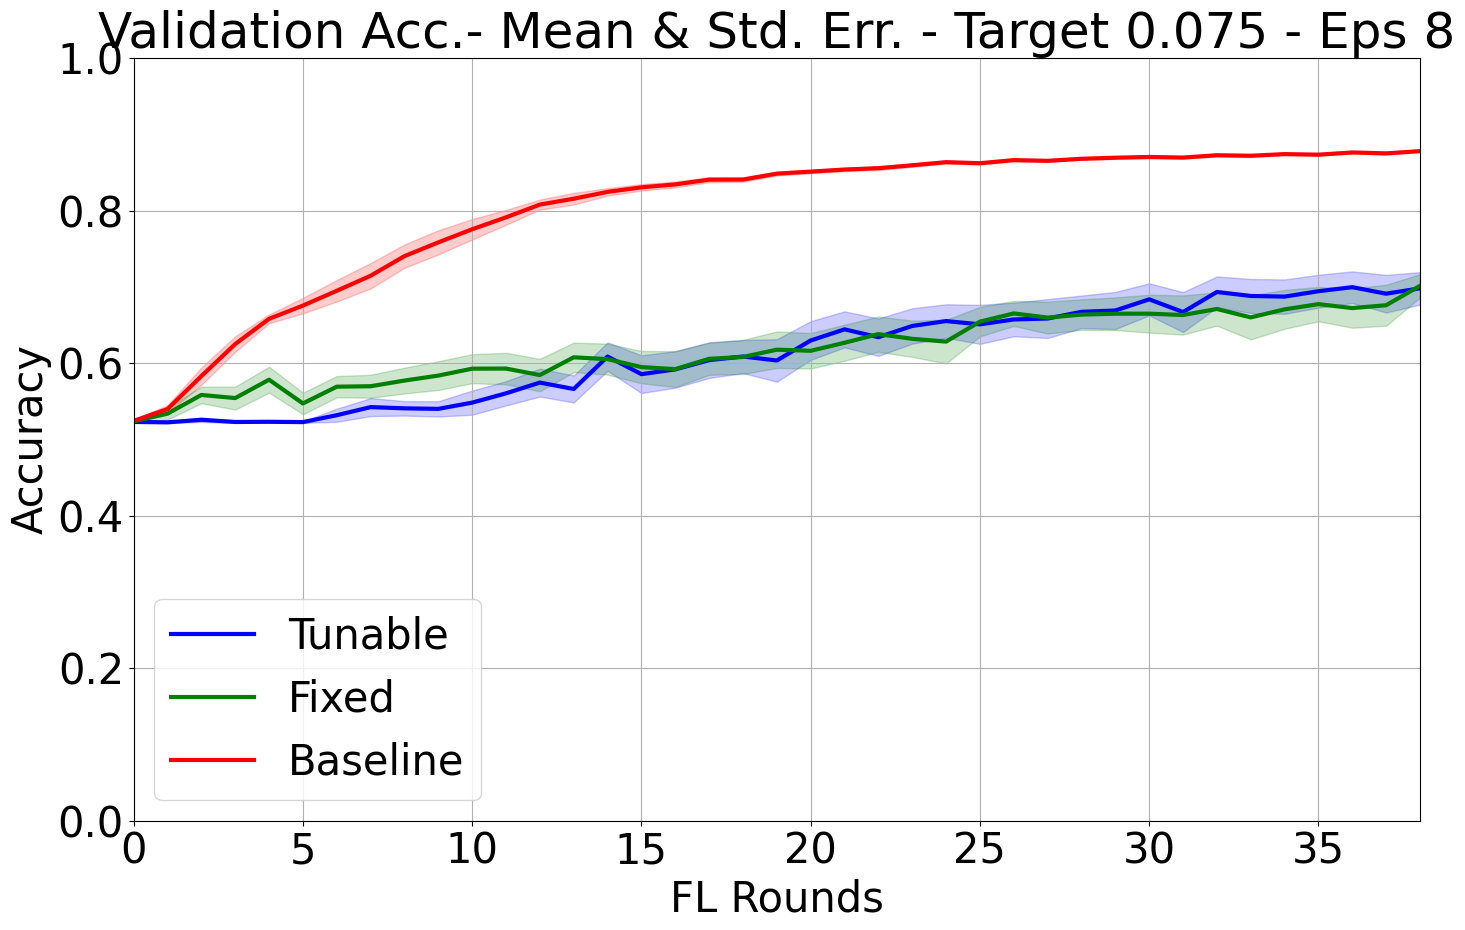

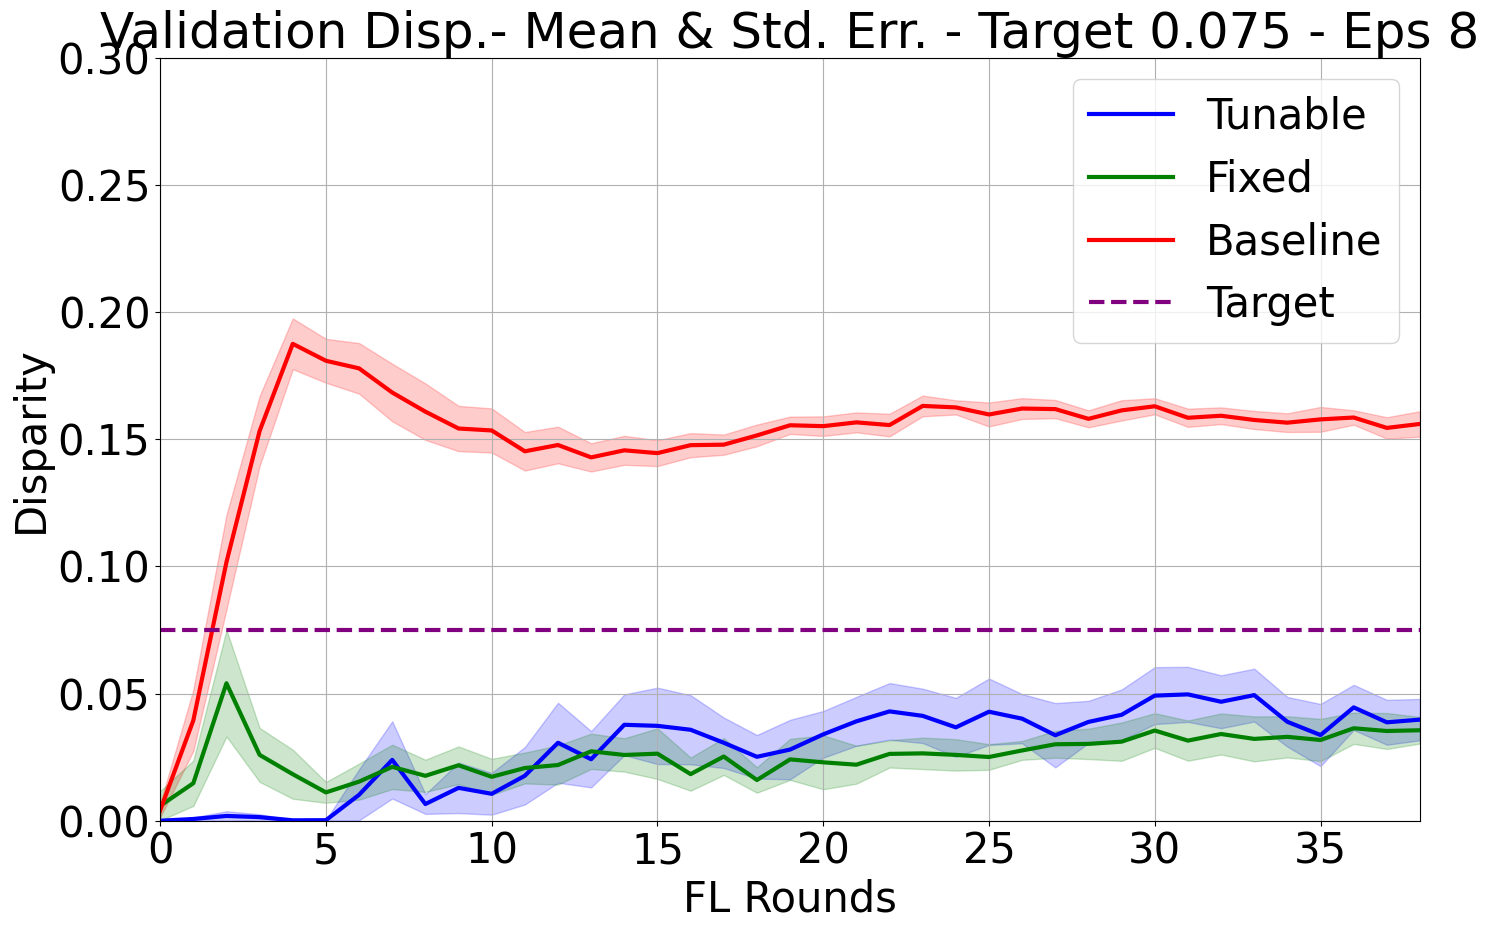

In [16]:
project_name = "Celeba_sweep_0075_8"
data = download_data(project_name)
best_runs_tunable, best_runs_fixed, best_run_baseline = manage_plots(
    data=data,
    data_baseline=data_baseline_8,
    target=0.075,
    project_name=project_name,
    epsilon=8,
)

target_0075_epsilon_8_tunable_test, target_0075_epsilon_8_fixed_test = get_last_accuracy_mean(best_runs_tunable, best_runs_fixed)
target_0075_epsilon_8_tunable_validation, target_0075_epsilon_8_fixed_validation = get_last_accuracy_mean_validation(best_runs_tunable, best_runs_fixed)
target_0075_epsilon_8_tunable_train, target_0075_epsilon_8_fixed_train = get_last_accuracy_mean_train(best_runs_tunable, best_runs_fixed)

# Target 0.1 Epsilon 5

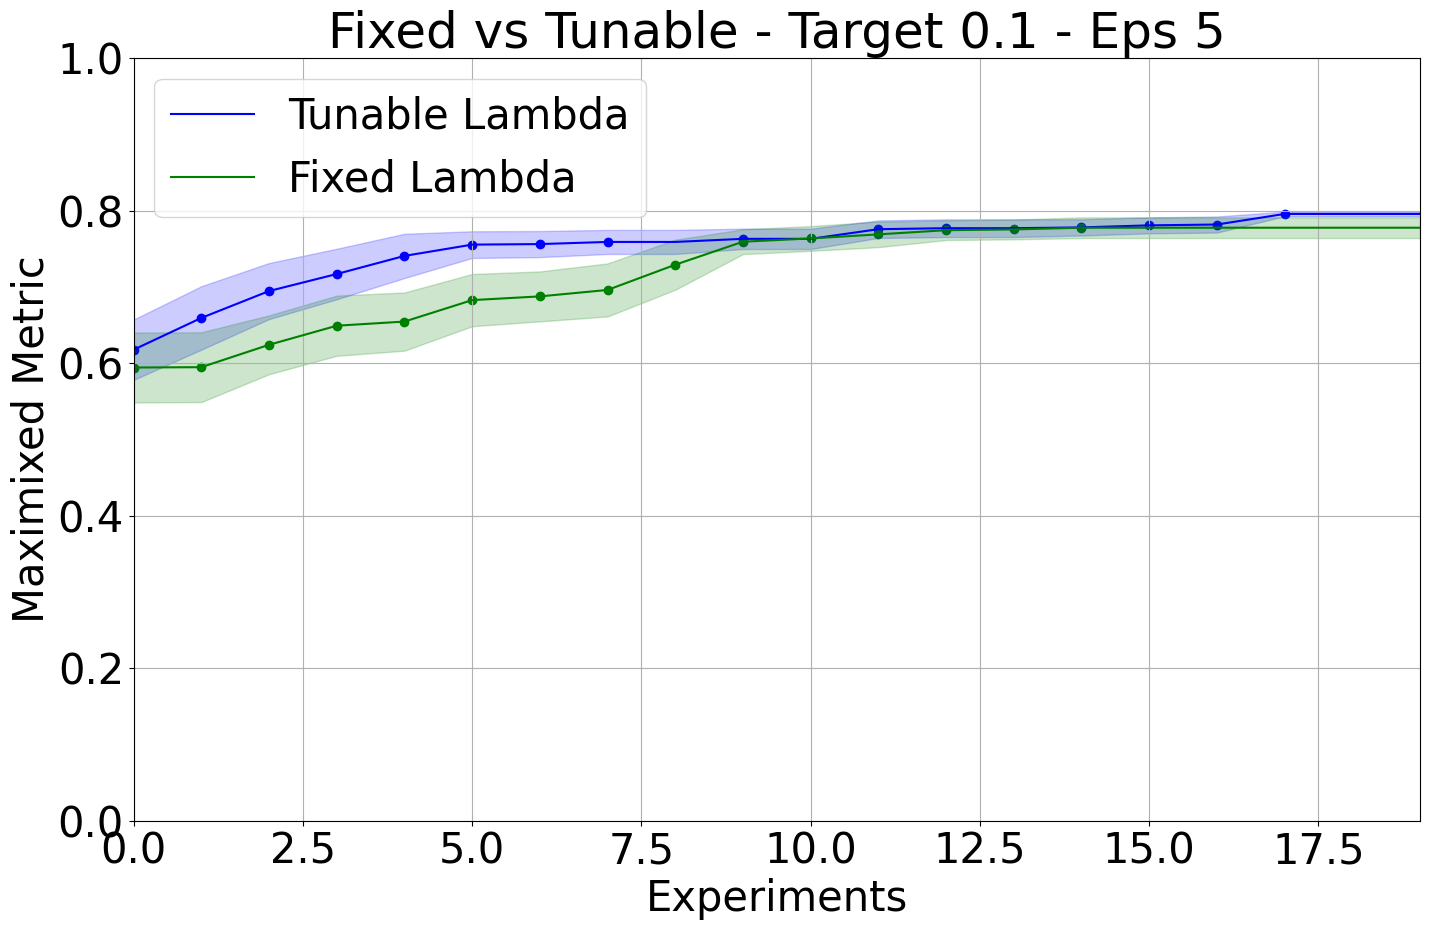

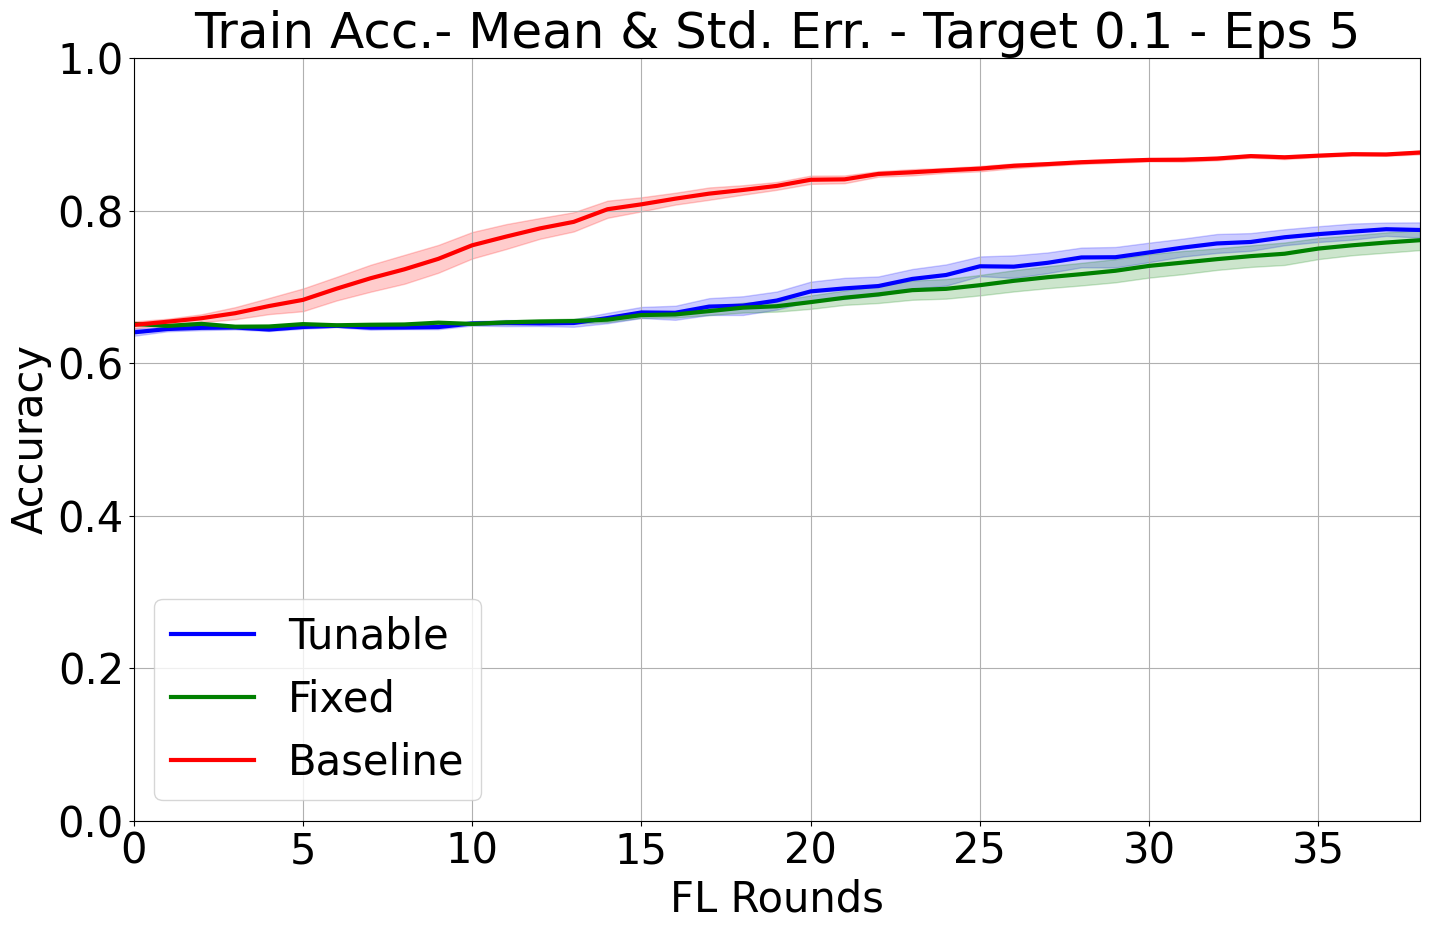

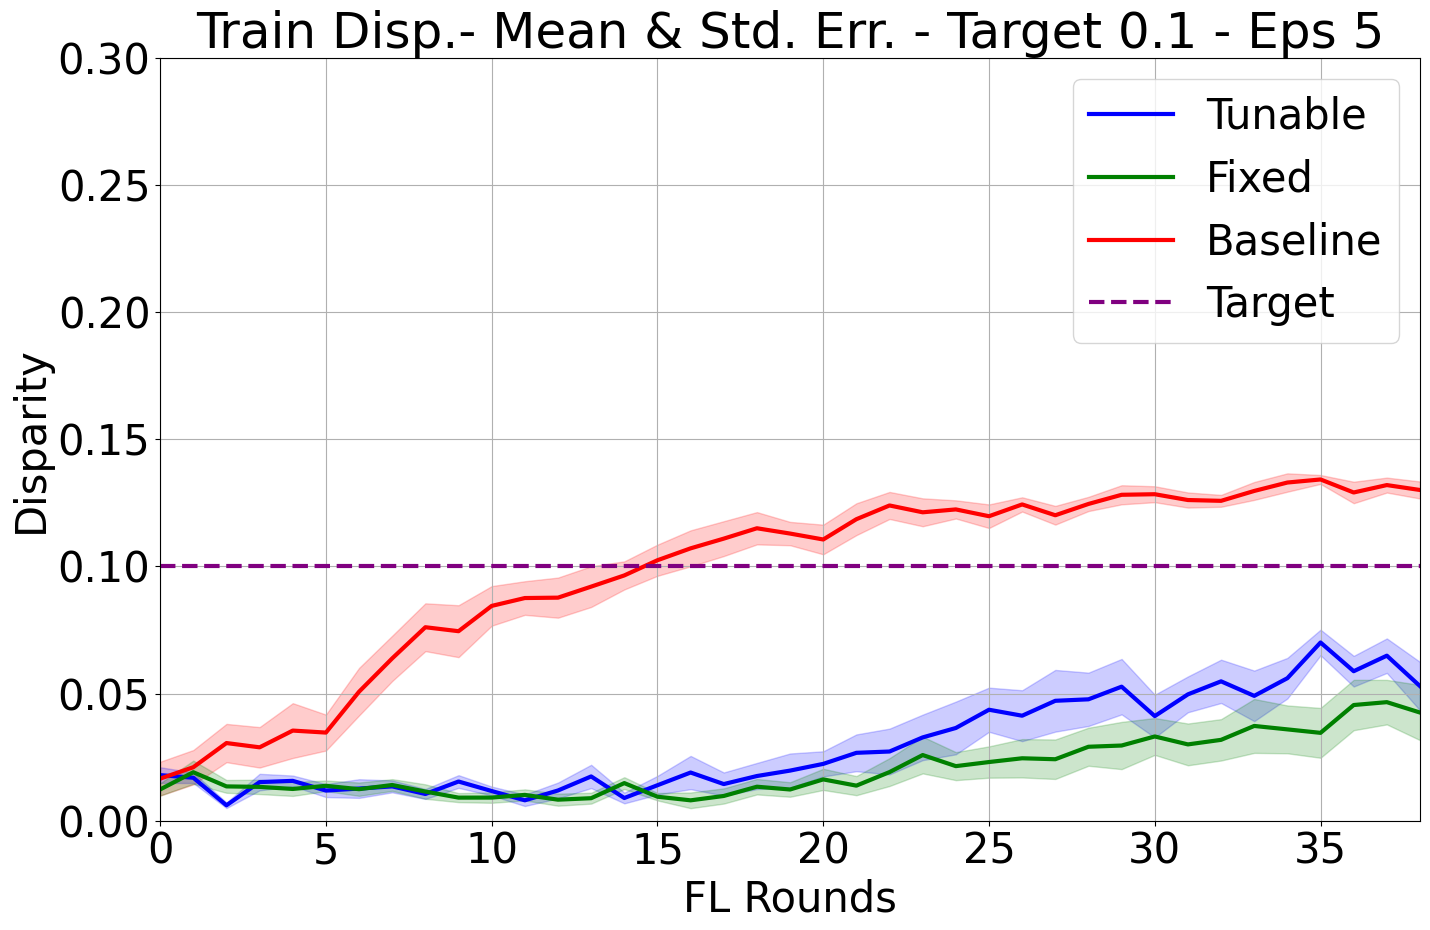

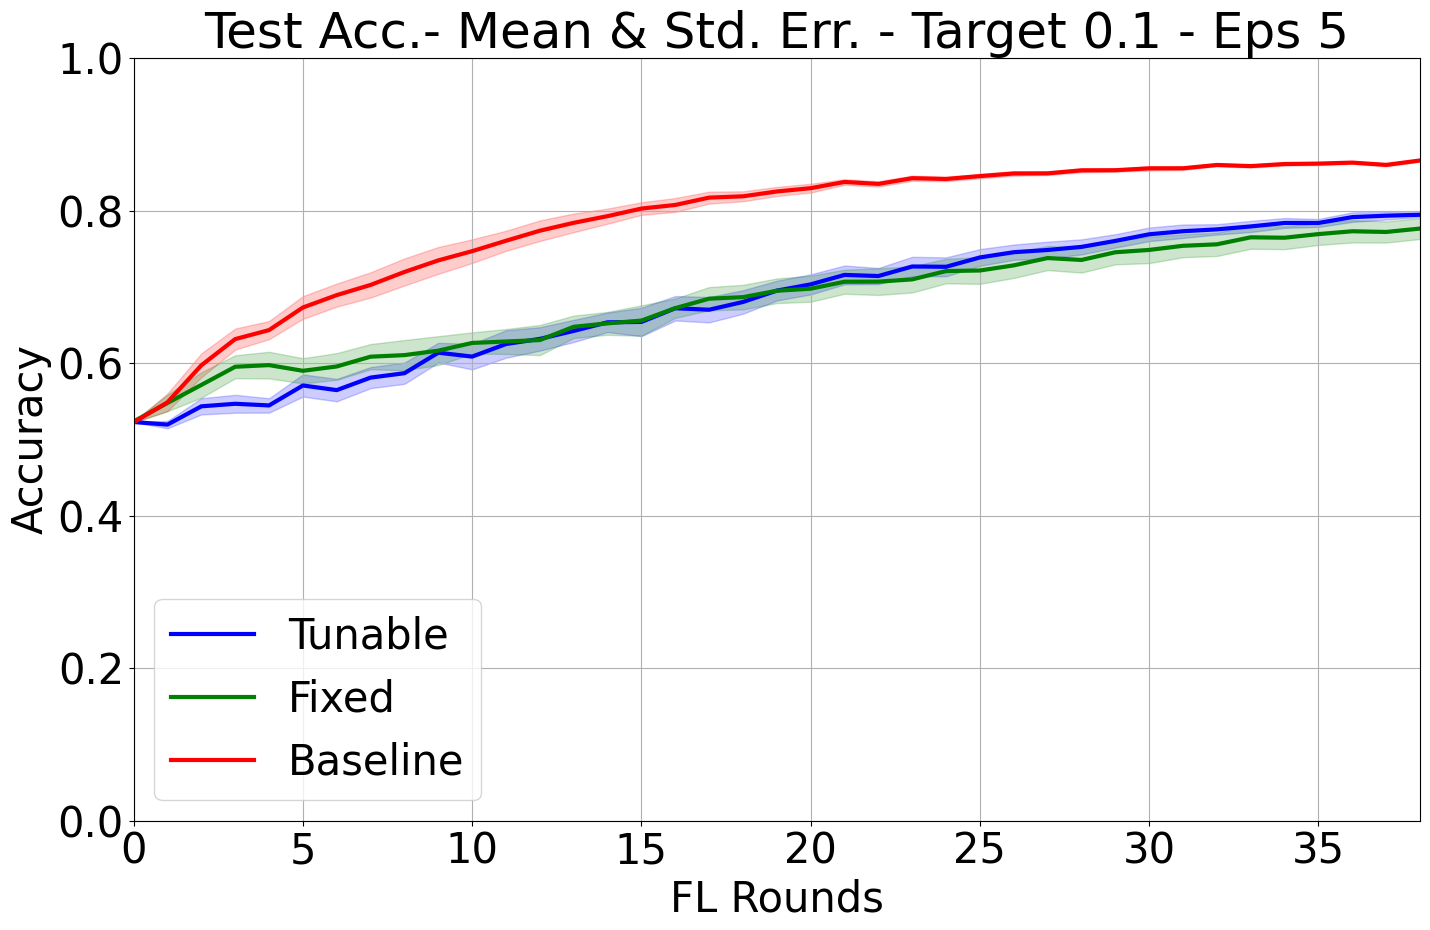

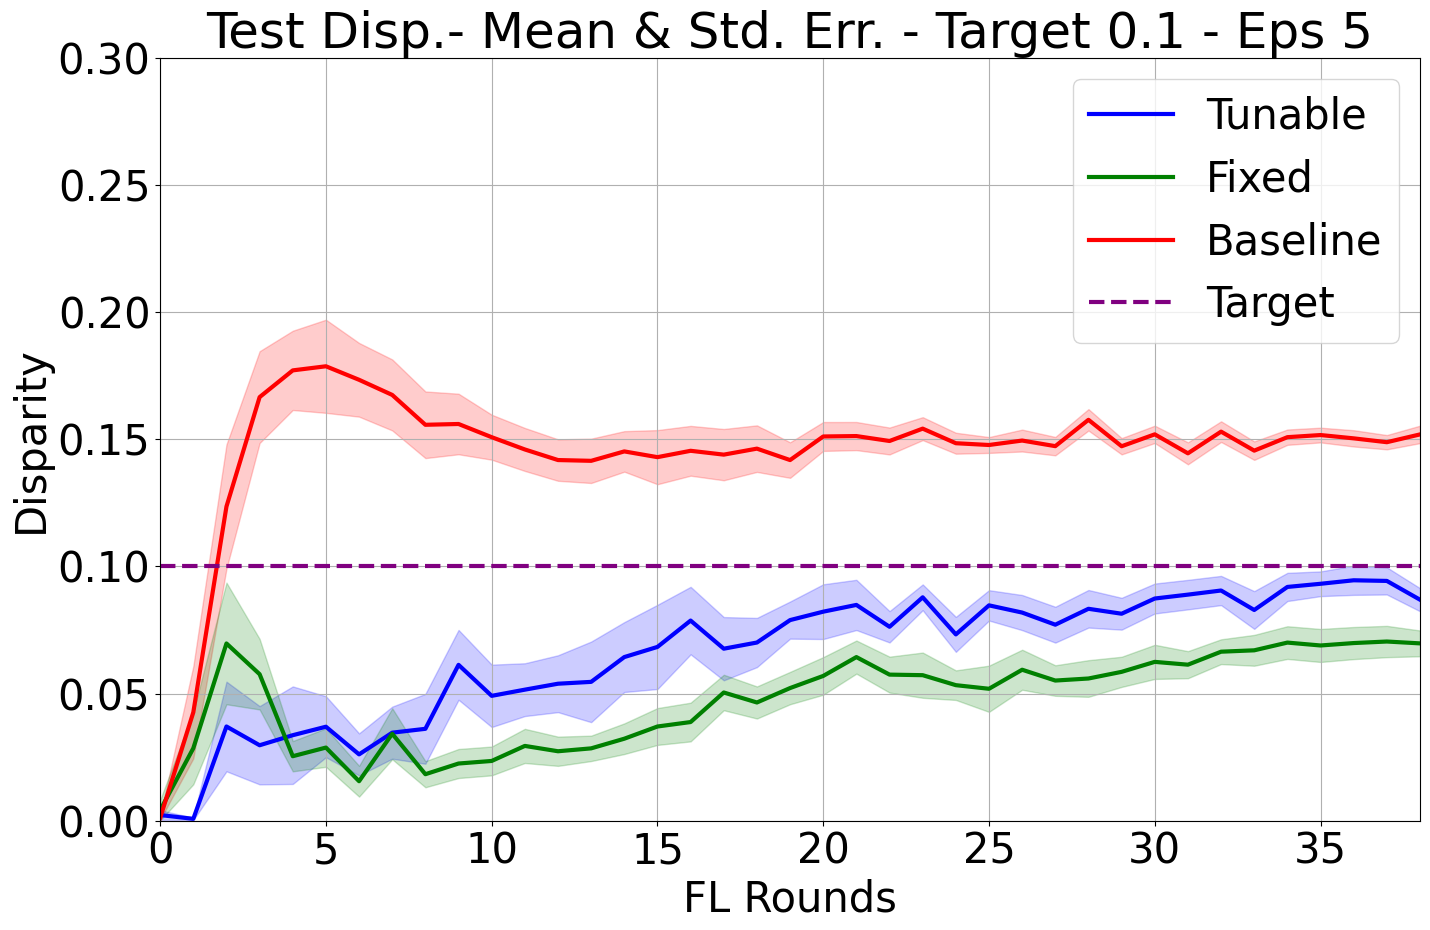

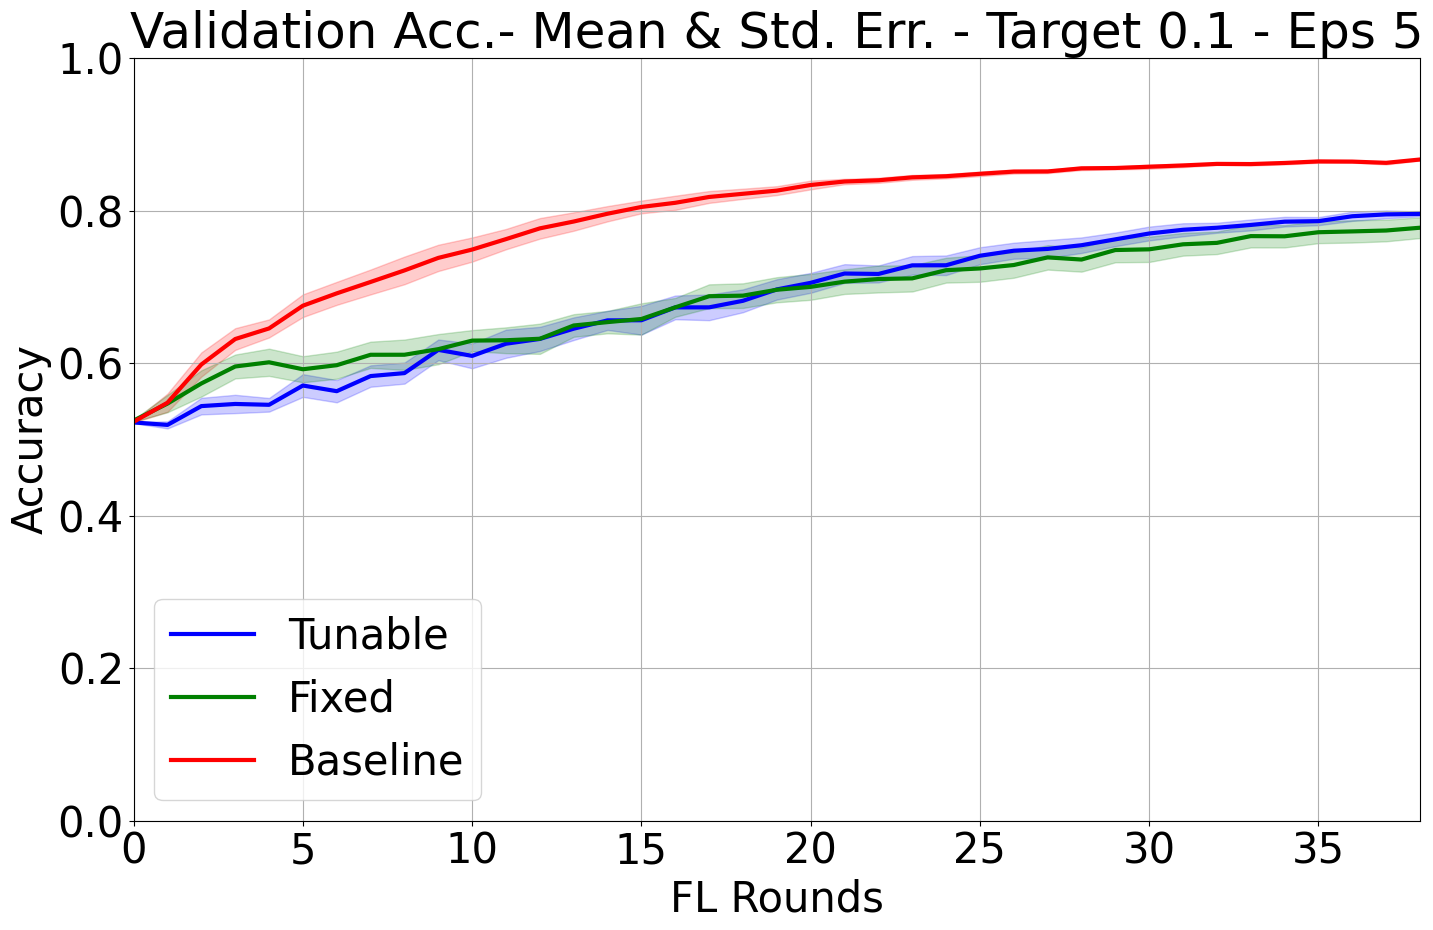

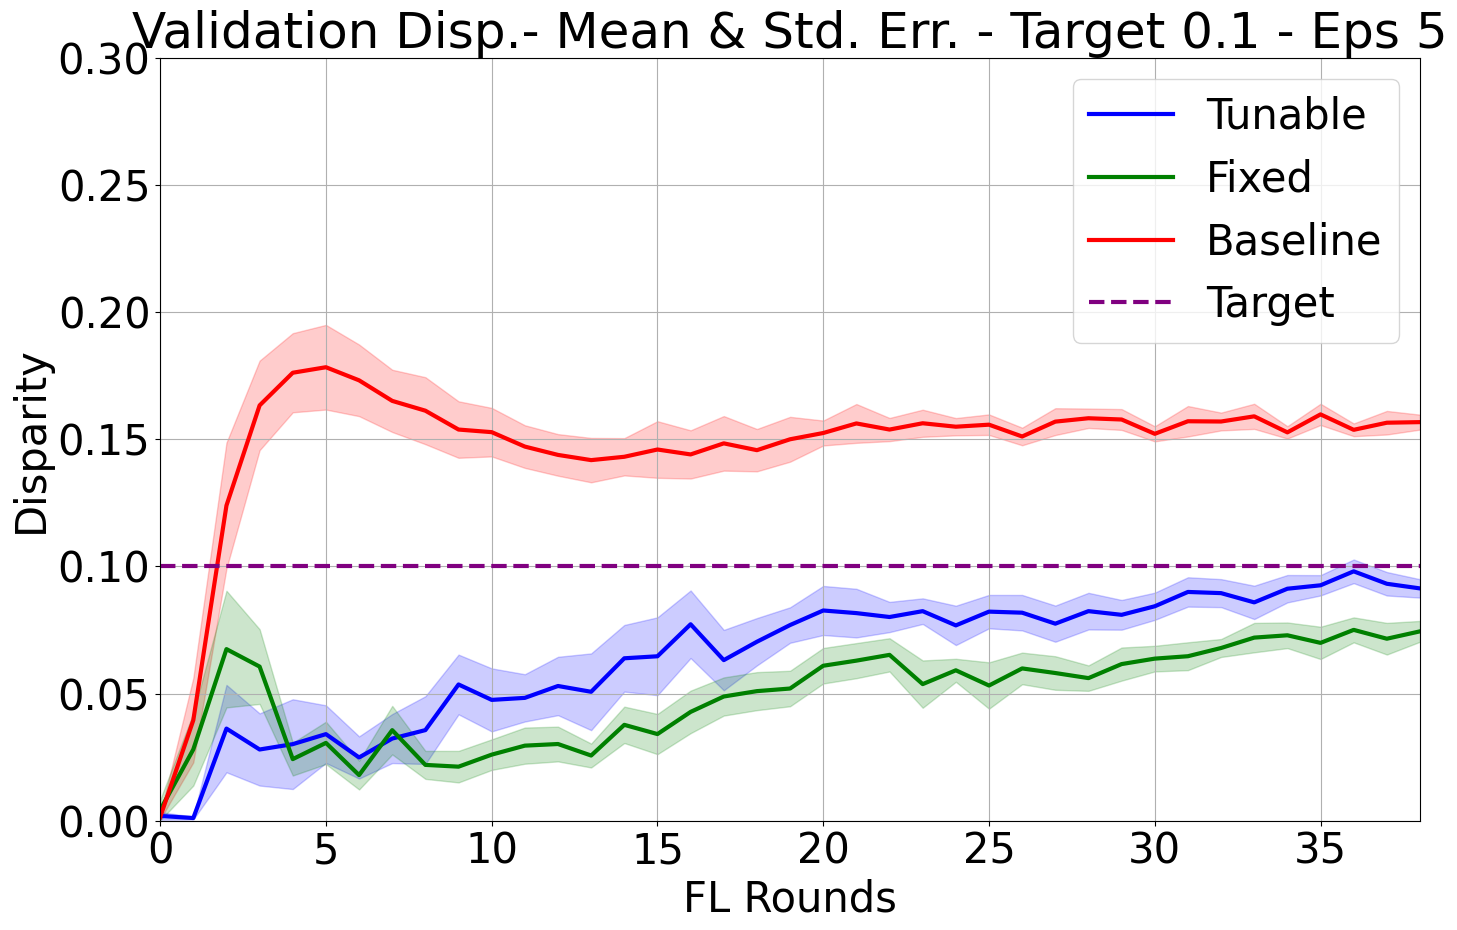

In [17]:
project_name = "Celeba_sweep_01_5"
data = download_data(project_name)
best_runs_tunable, best_runs_fixed, best_run_baseline = manage_plots(
    data=data,
    data_baseline=data_baseline_5,
    target=0.1,
    project_name=project_name,
    epsilon=5,
)

target_01_epsilon_5_tunable_test, target_01_epsilon_5_fixed_test = get_last_accuracy_mean(best_runs_tunable, best_runs_fixed)
target_01_epsilon_5_tunable_validation, target_01_epsilon_5_fixed_validation = get_last_accuracy_mean_validation(best_runs_tunable, best_runs_fixed)
target_01_epsilon_5_tunable_train, target_01_epsilon_5_fixed_train = get_last_accuracy_mean_train(best_runs_tunable, best_runs_fixed)

# Target 0.1 Epsilon 8

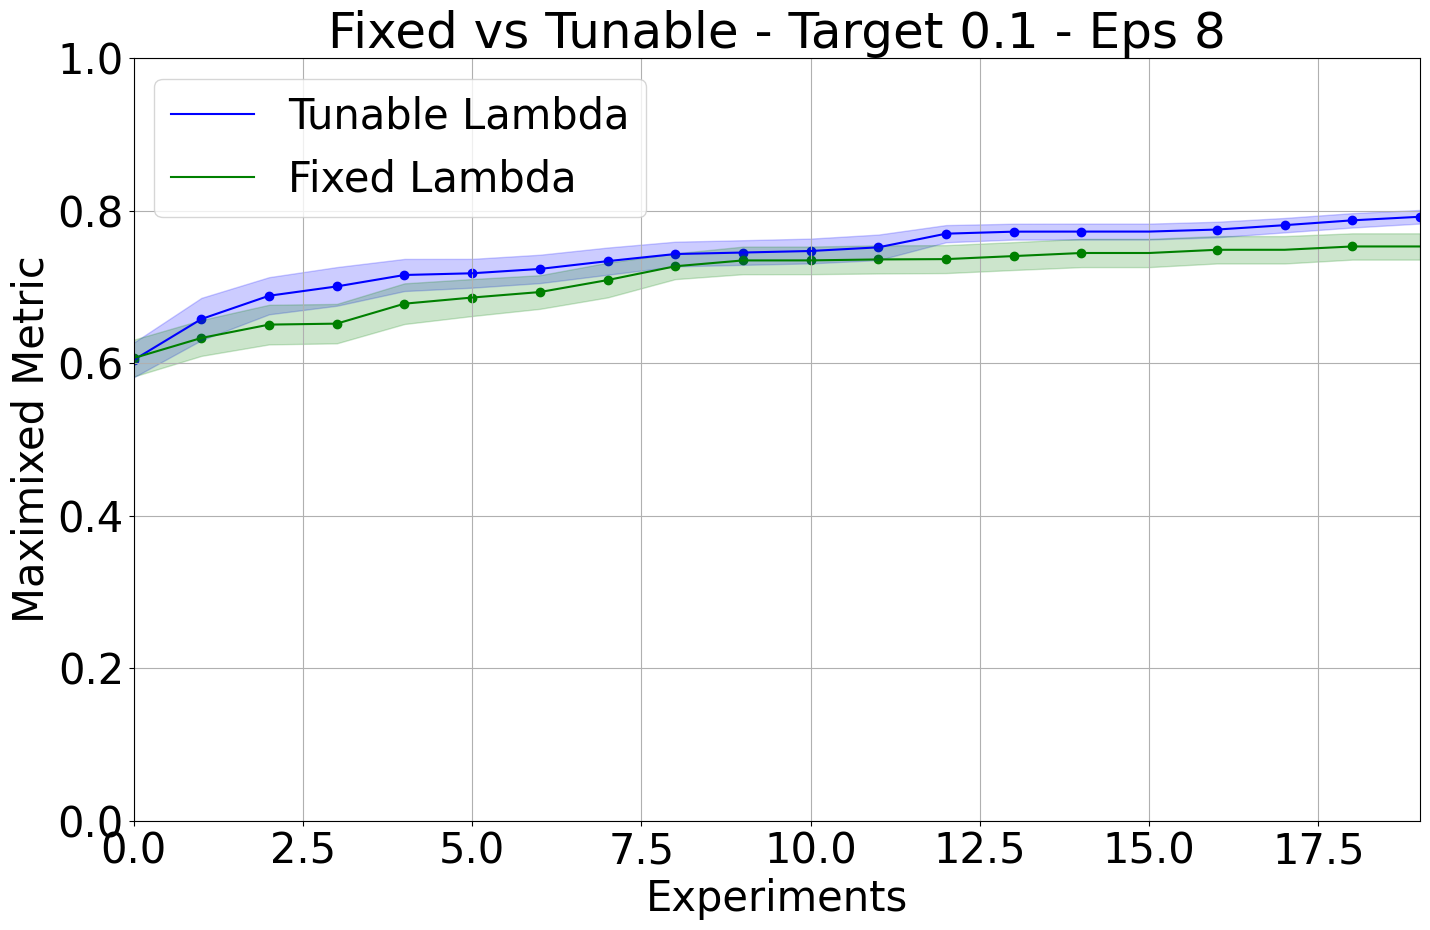

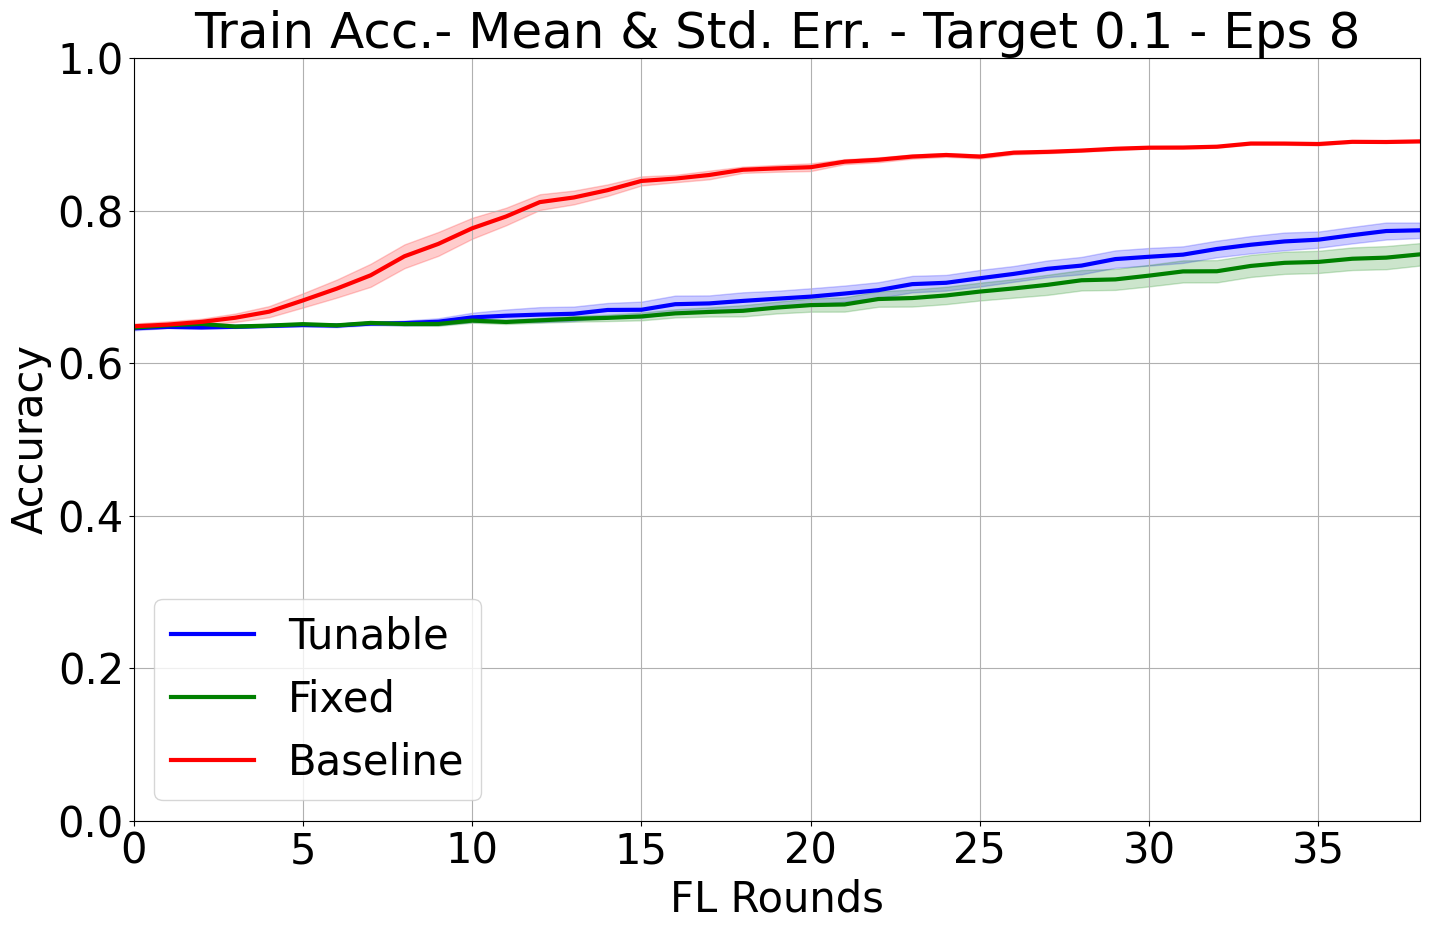

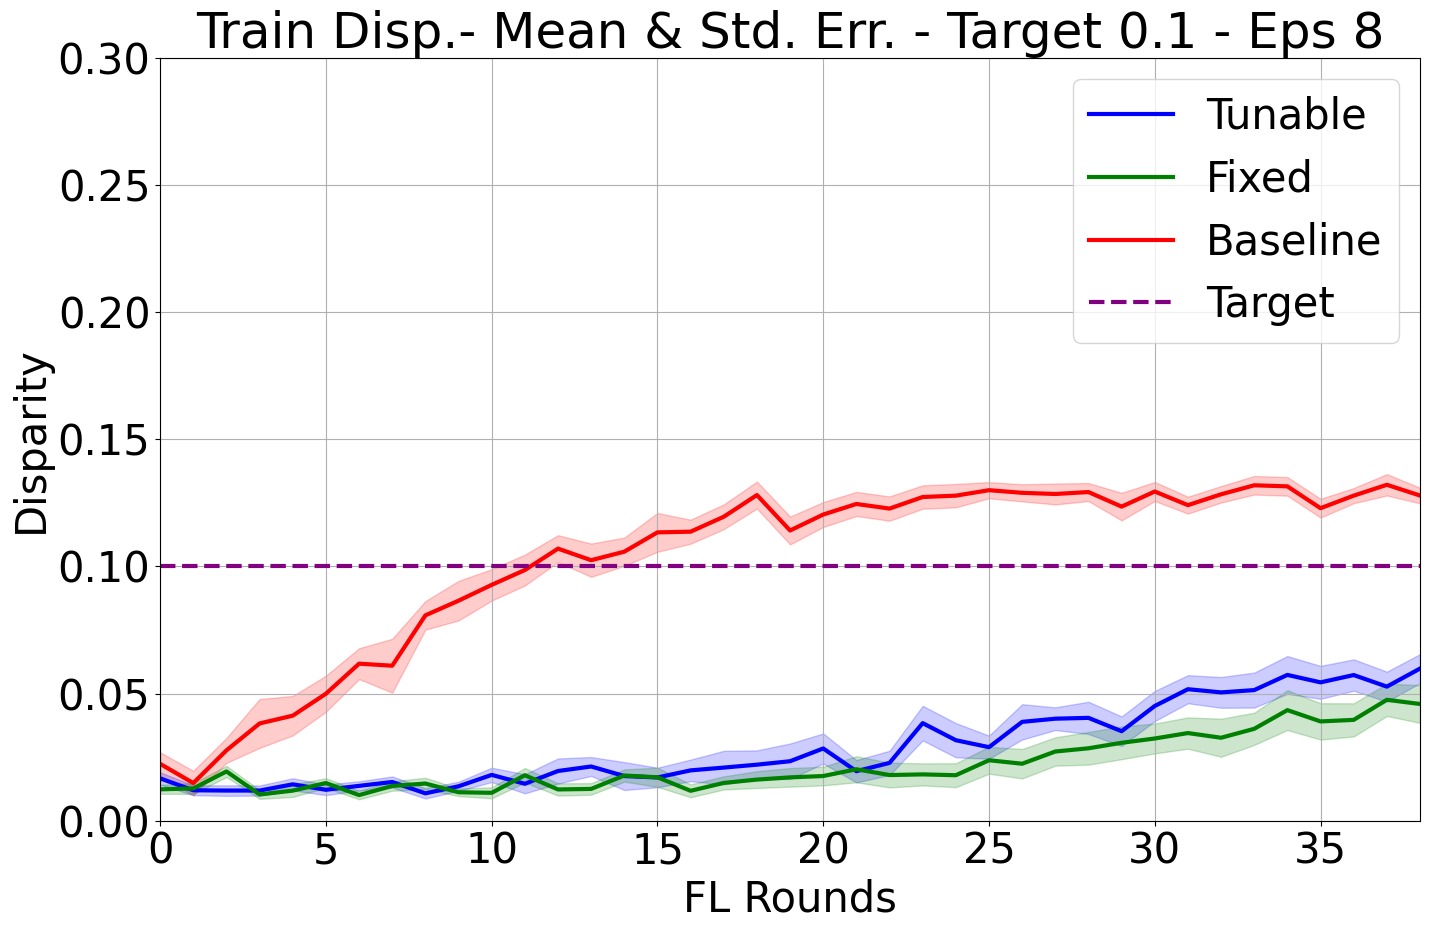

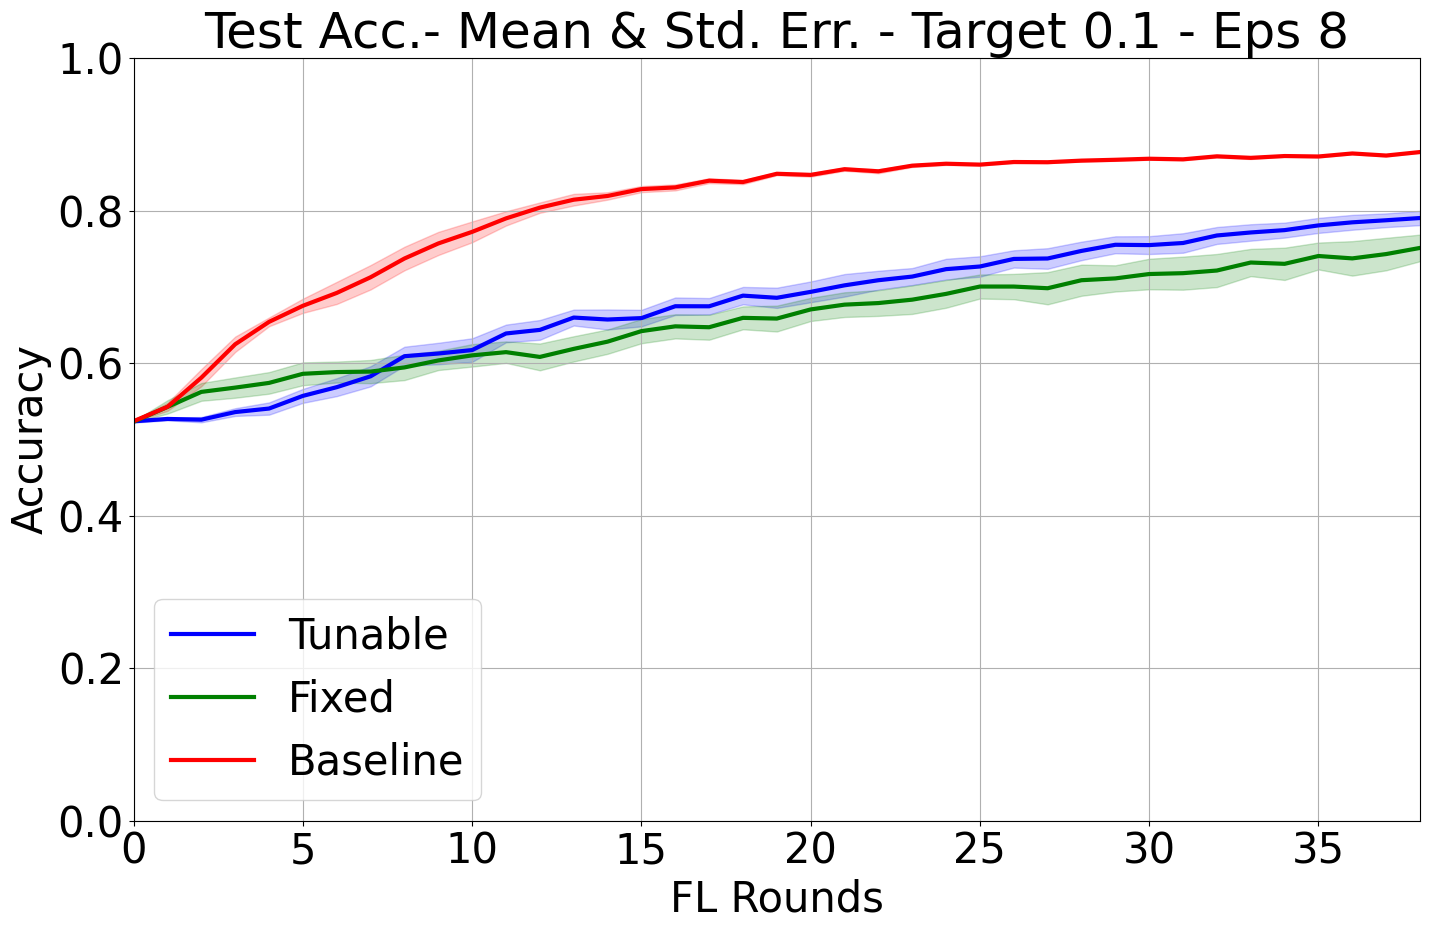

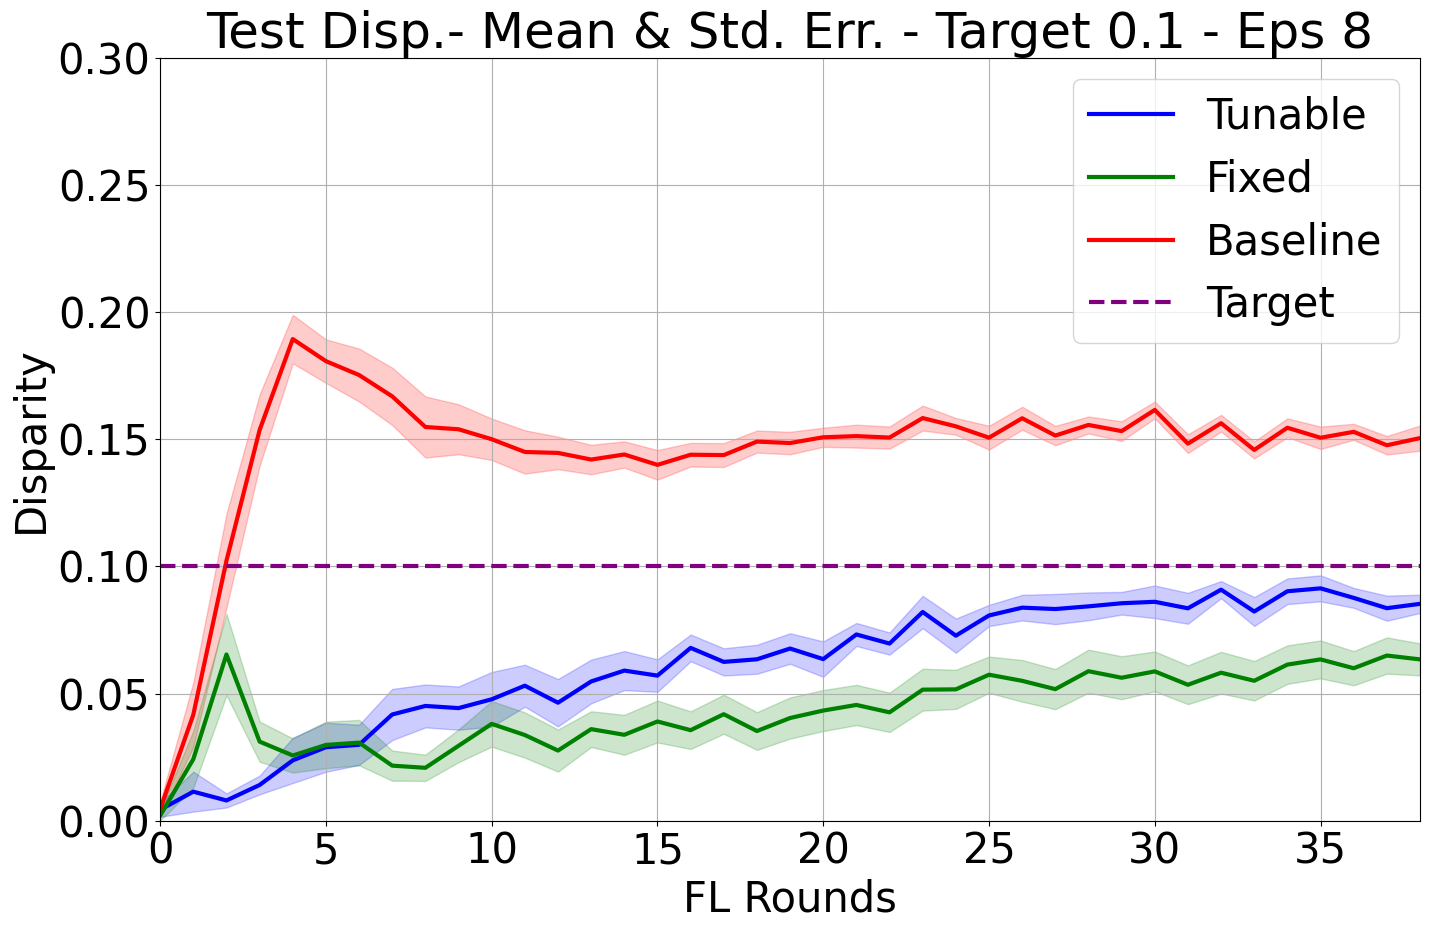

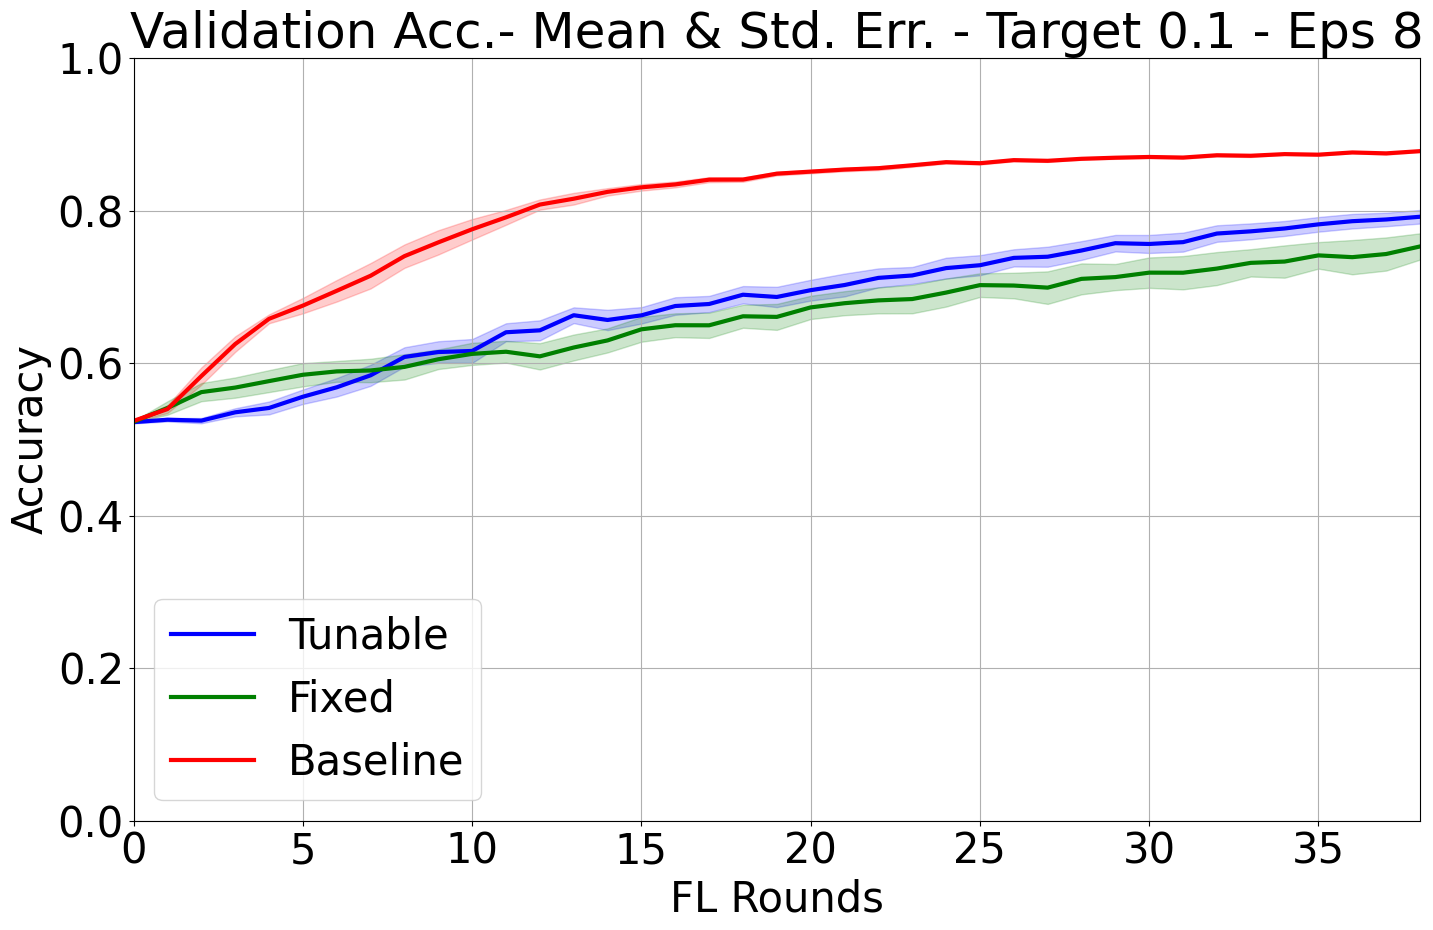

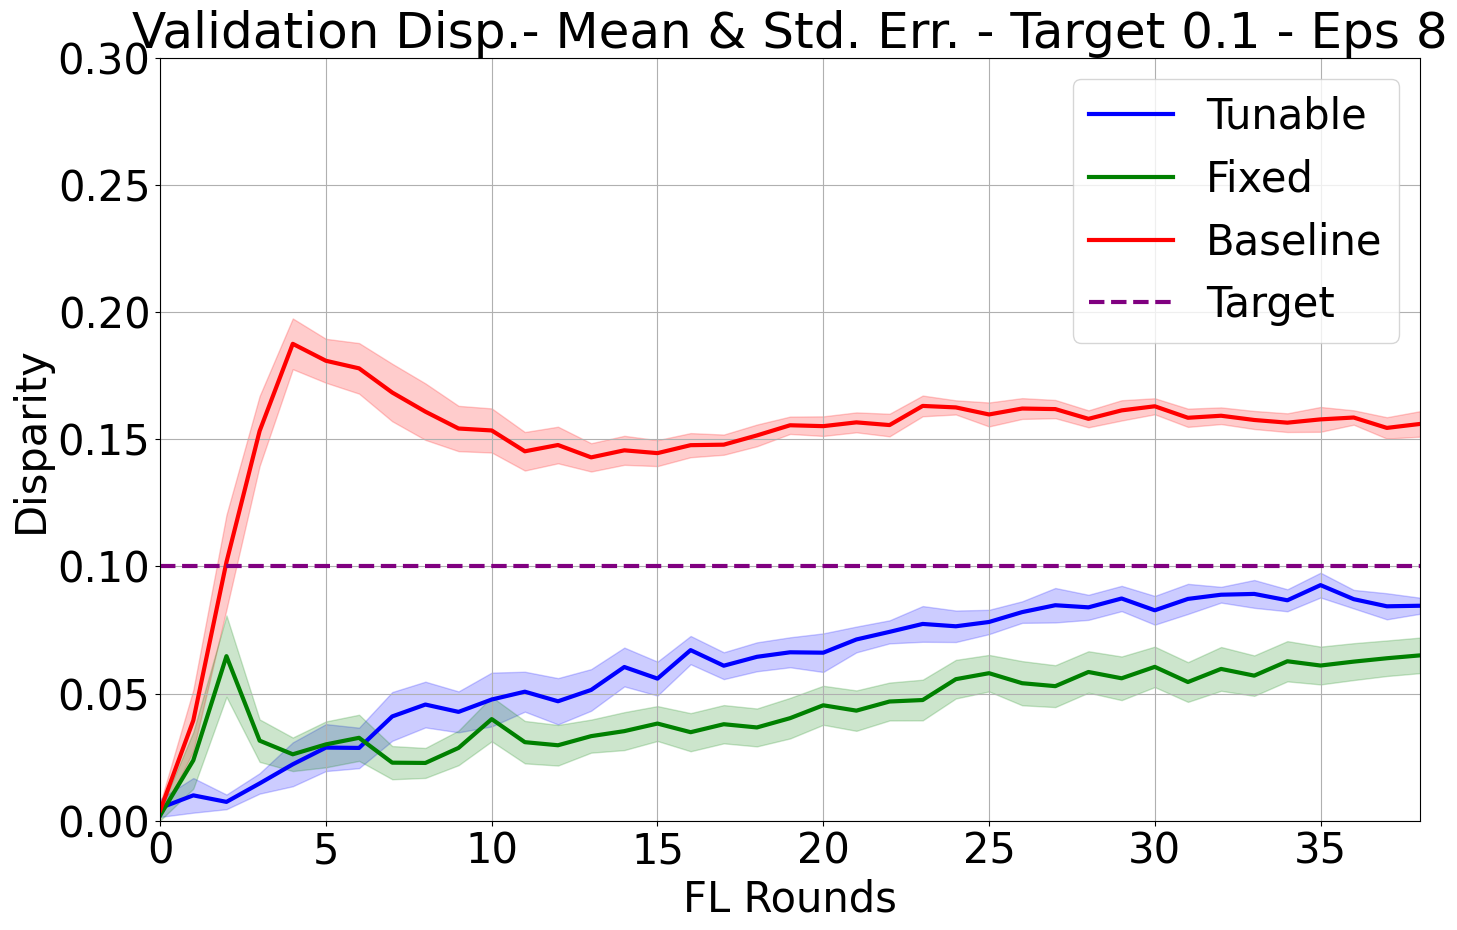

In [18]:
project_name = "Celeba_sweep_01_8"
data = download_data(project_name)
best_runs_tunable, best_runs_fixed, best_run_baseline = manage_plots(
    data=data,
    data_baseline=data_baseline_8,
    target=0.1,
    project_name=project_name,
    epsilon=8,
)
target_01_epsilon_8_tunable_test, target_01_epsilon_8_fixed_test = get_last_accuracy_mean(best_runs_tunable, best_runs_fixed)
target_01_epsilon_8_tunable_validation, target_01_epsilon_8_fixed_validation = get_last_accuracy_mean_validation(best_runs_tunable, best_runs_fixed)
target_01_epsilon_8_tunable_train, target_01_epsilon_8_fixed_train = get_last_accuracy_mean_train(best_runs_tunable, best_runs_fixed)

# Heatmap

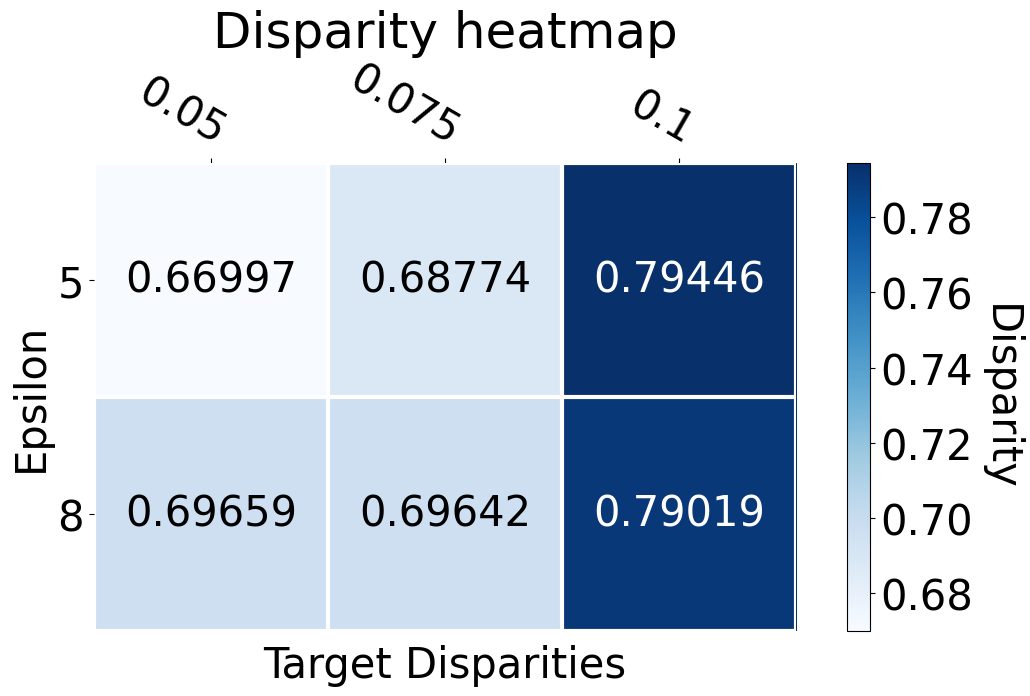

In [19]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib
import matplotlib as mpl


epsilon = [5, 8]
disparities = [0.05, 0.075, 0.1]

harvest = np.array([[target_005_epsilon_5_tunable_test, target_0075_epsilon_5_tunable_test, target_01_epsilon_5_tunable_test], 
                    [target_005_epsilon_8_tunable_test, target_0075_epsilon_8_tunable_test, target_01_epsilon_8_tunable_test]
                    ])

fig, ax = plt.subplots()

im, cbar = heatmap(harvest, epsilon, disparities, ax=ax,
                   cmap="Blues", cbarlabel="Disparity")
texts = annotate_heatmap(im, valfmt="{x:.5f}")

plt.xlabel("Target Disparities")
plt.ylabel("Epsilon")
plt.title("Disparity heatmap")
# font size 22 
plt.rcParams.update({'font.size': 22})
fig.tight_layout()
plt.show()


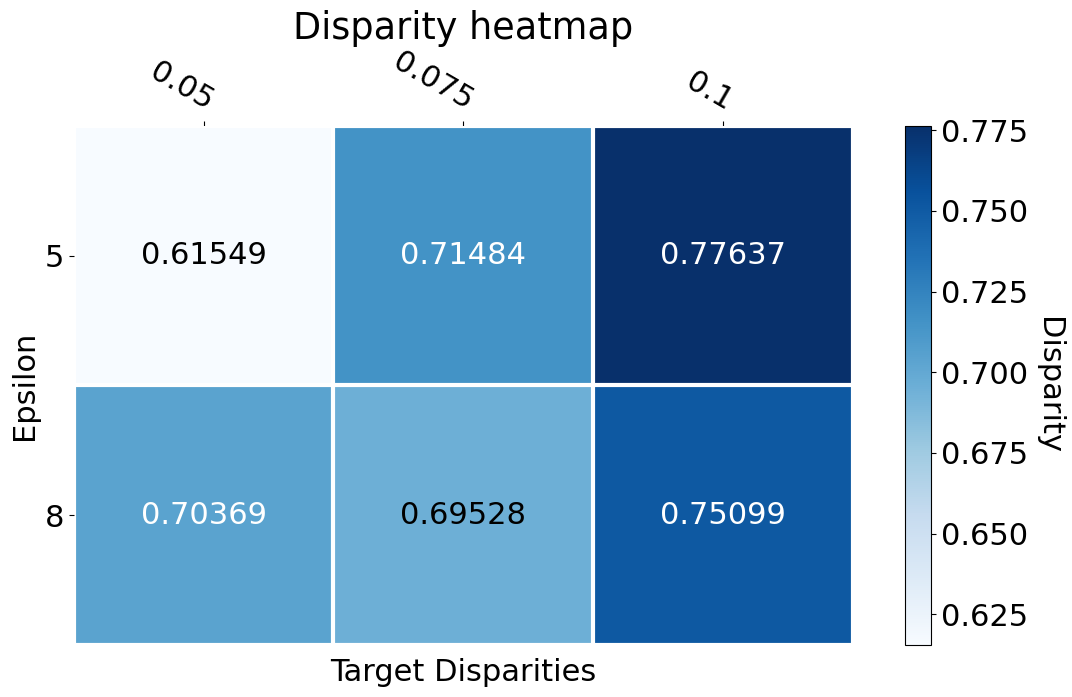

In [20]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib
import matplotlib as mpl


epsilon = [5, 8]
disparities = [0.05, 0.075, 0.1]

harvest = np.array([[target_005_epsilon_5_fixed_test, target_0075_epsilon_5_fixed_test, target_01_epsilon_5_fixed_test], 
                    [target_005_epsilon_8_fixed_test, target_0075_epsilon_8_fixed_test, target_01_epsilon_8_fixed_test]
                    ])

fig, ax = plt.subplots()

im, cbar = heatmap(harvest, epsilon, disparities, ax=ax,
                   cmap="Blues", cbarlabel="Disparity")
texts = annotate_heatmap(im, valfmt="{x:.5f}")

plt.xlabel("Target Disparities")
plt.ylabel("Epsilon")
plt.title("Disparity heatmap")
# font size 22 
plt.rcParams.update({'font.size': 22})
fig.tight_layout()
plt.show()


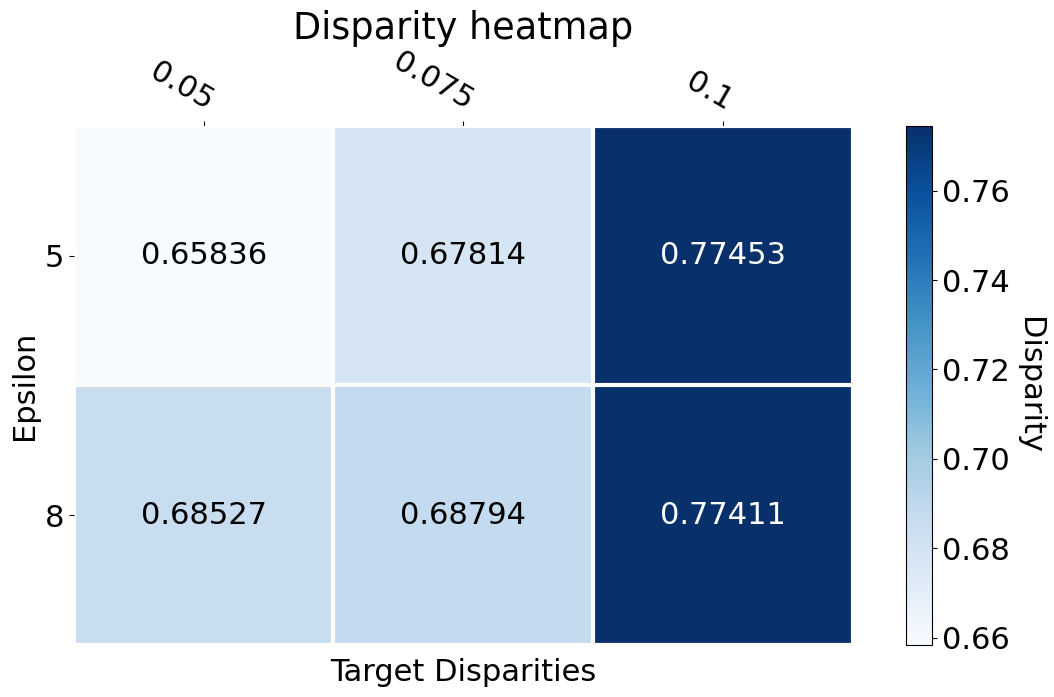

In [21]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib
import matplotlib as mpl


epsilon = [5, 8]
disparities = [0.05, 0.075, 0.1]

harvest = np.array([[target_005_epsilon_5_tunable_train, target_0075_epsilon_5_tunable_train, target_01_epsilon_5_tunable_train], 
                    [target_005_epsilon_8_tunable_train, target_0075_epsilon_8_tunable_train, target_01_epsilon_8_tunable_train]
                    ])

fig, ax = plt.subplots()

im, cbar = heatmap(harvest, epsilon, disparities, ax=ax,
                   cmap="Blues", cbarlabel="Disparity")
texts = annotate_heatmap(im, valfmt="{x:.5f}")

plt.xlabel("Target Disparities")
plt.ylabel("Epsilon")
plt.title("Disparity heatmap")
# font size 22 
plt.rcParams.update({'font.size': 22})
fig.tight_layout()
plt.show()


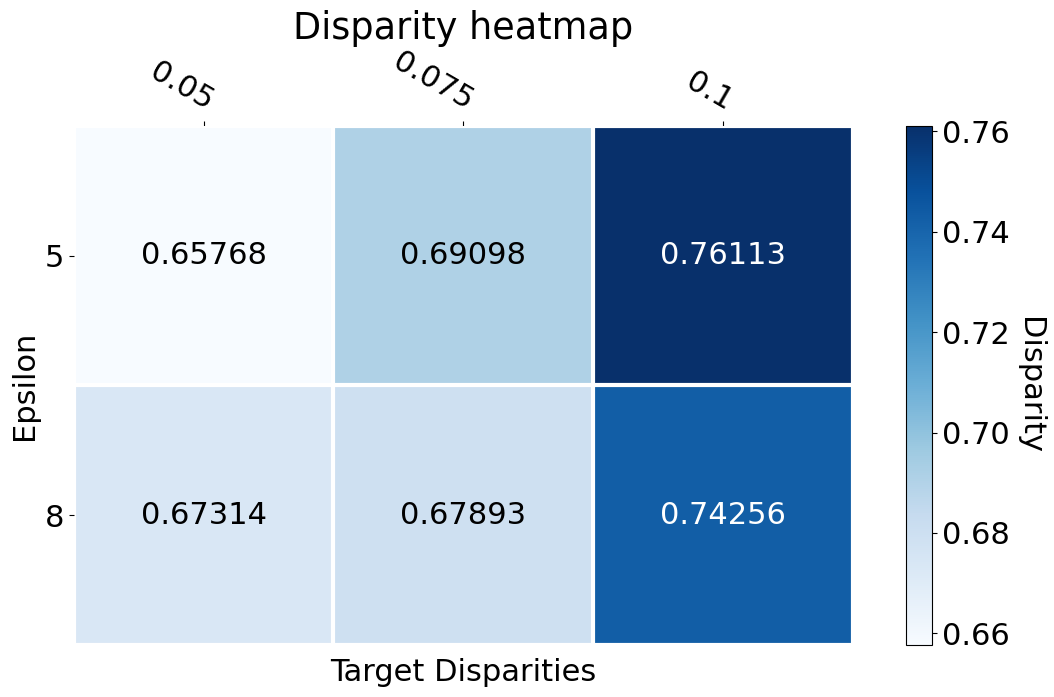

In [22]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib
import matplotlib as mpl


epsilon = [5, 8]
disparities = [0.05, 0.075, 0.1]

harvest = np.array([[target_005_epsilon_5_fixed_train, target_0075_epsilon_5_fixed_train, target_01_epsilon_5_fixed_train], 
                    [target_005_epsilon_8_fixed_train, target_0075_epsilon_8_fixed_train, target_01_epsilon_8_fixed_train]
                    ])

fig, ax = plt.subplots()

im, cbar = heatmap(harvest, epsilon, disparities, ax=ax,
                   cmap="Blues", cbarlabel="Disparity")
texts = annotate_heatmap(im, valfmt="{x:.5f}")

plt.xlabel("Target Disparities")
plt.ylabel("Epsilon")
plt.title("Disparity heatmap")
# font size 22 
plt.rcParams.update({'font.size': 22})
fig.tight_layout()
plt.show()


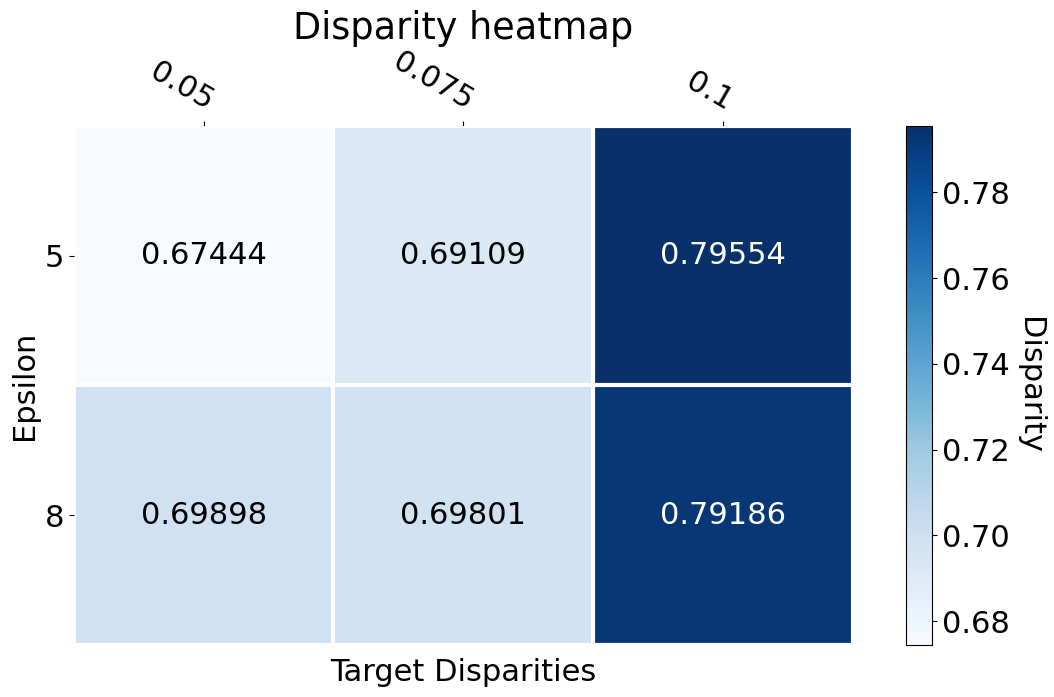

In [23]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib
import matplotlib as mpl


epsilon = [5, 8]
disparities = [0.05, 0.075, 0.1]

harvest = np.array([[target_005_epsilon_5_tunable_validation, target_0075_epsilon_5_tunable_validation, target_01_epsilon_5_tunable_validation], 
                    [target_005_epsilon_8_tunable_validation, target_0075_epsilon_8_tunable_validation, target_01_epsilon_8_tunable_validation]
                    ])

fig, ax = plt.subplots()

im, cbar = heatmap(harvest, epsilon, disparities, ax=ax,
                   cmap="Blues", cbarlabel="Disparity")
texts = annotate_heatmap(im, valfmt="{x:.5f}")

plt.xlabel("Target Disparities")
plt.ylabel("Epsilon")
plt.title("Disparity heatmap")
# font size 22 
plt.rcParams.update({'font.size': 22})
fig.tight_layout()
plt.show()


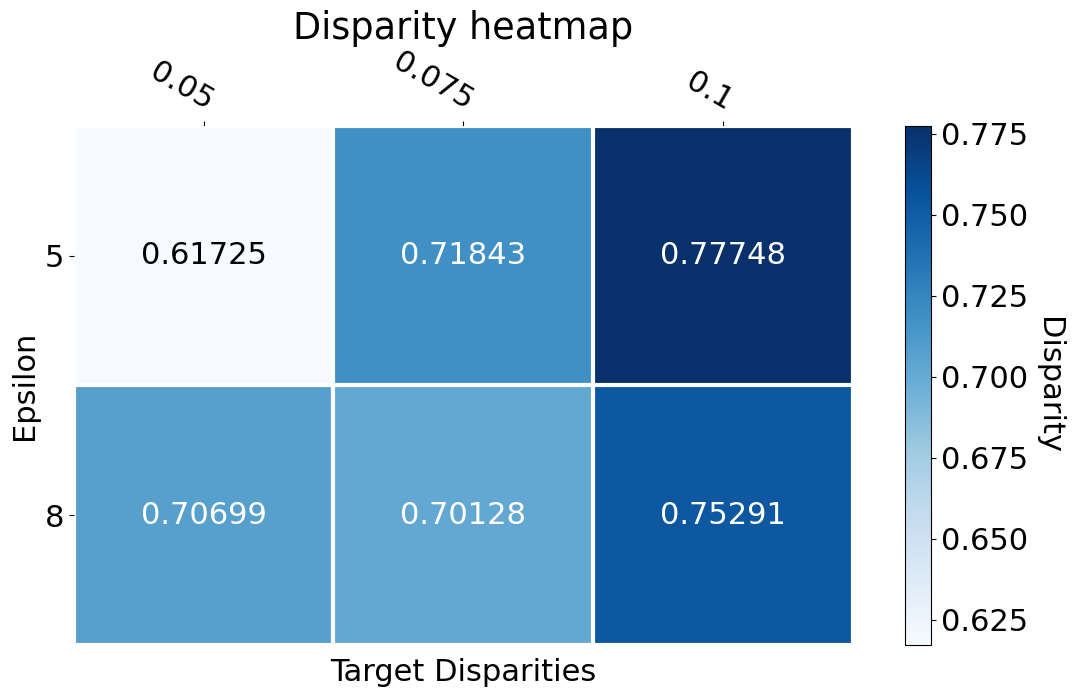

In [24]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib
import matplotlib as mpl


epsilon = [5, 8]
disparities = [0.05, 0.075, 0.1]

harvest = np.array([[target_005_epsilon_5_fixed_validation, target_0075_epsilon_5_fixed_validation, target_01_epsilon_5_fixed_validation], 
                    [target_005_epsilon_8_fixed_validation, target_0075_epsilon_8_fixed_validation, target_01_epsilon_8_fixed_validation]
                    ])

fig, ax = plt.subplots()

im, cbar = heatmap(harvest, epsilon, disparities, ax=ax,
                   cmap="Blues", cbarlabel="Disparity")
texts = annotate_heatmap(im, valfmt="{x:.5f}")

plt.xlabel("Target Disparities")
plt.ylabel("Epsilon")
plt.title("Disparity heatmap")
# font size 22 
plt.rcParams.update({'font.size': 22})
fig.tight_layout()
plt.show()
